In [1]:
#imports
import numpy as np
import arviz as az
import scipy.stats as stats
import pandas as pd
from Bays_model_tareq import BaysModel
from data_manager import DataManager as DataManager
from data_manager_OG import DataManager as DataManager2
from matplotlib.gridspec import GridSpec
from doe import DOE
from WoehlerParams import WoehlerCurve
from WoehlerParams2 import WoehlerCurve2
from scipy.stats import uniform
import plot_functions
import plot_functions_T
import matplotlib.pyplot as plt
import help_functions
import pickle
import statistics
import pymc3 as pm
import tensorflow as tf
from scipy.special import expit as logistic
import math
import random
from collections import defaultdict

#constants
PARAM_LIST = ['k','s_d', 'n_e','one_t_s']

2023-03-09 15:53:22.661742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 15:53:22.738556: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-09 15:53:22.740724: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-09 15:53:22.740734: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [2]:
import sys;print(sys.version)

3.9.13 (main, Aug 25 2022, 23:26:10) 
[GCC 11.2.0]


## Parameters

In [3]:
expNum = 2                        ## the desired test
num_of_samp = 100                 ## number of random samples
scale = 5                         ##the scale for the std relative to the informative prior
confidence = 0.90                 ##the confidence level of the informatice prior
conflict_test = 3+16               ##the desired test in which the prior data conflict is being tested

In [4]:
new_data_manager = DataManager()

Outcome = [0 for i in range(8)]
N = [0 for i in range(8)]
S_a = [0 for i in range(8)]
curve = [0 for i in range(8)]
woehler_params_original = [0 for i in range(8)]
prior_from_ki = [0 for i in range(8)]

for i in range(8):
    
    if i == 0:
        db_id = ['PAO81SGP.1']
    elif i == 1:
        db_id = ['PAO81SGP.5']
    elif i == 2:
        db_id = ['PAO81SGP.7']
    elif i == 3:
        db_id = ['PAO81SGP.8']
    elif i == 4:
        db_id = ['KOL2RNG.1']
    elif i == 5:
        db_id = ['PAO81SGP.12']
    elif i == 6:
        db_id = ['KOL2RNG.29']
    elif i == 7:
        db_id = ['KOL2RNG.35']
        
    new_data_manager.load_ki_predictions_16_from_csv('exp.csv')
    index = new_data_manager.get_index_from_db_id(db_id) #this returns an array list with one element in it
    index = index[0] ##equivalant to i
    
    #for each experiment find:
    N[i], S_a[i], Outcome[i] = new_data_manager.get_woehler_data_from_index(index)
    curve[i] = WoehlerCurve2(S_a[i], N[i], Outcome[i])
    woehler_params_original[i] = new_data_manager.transform_woehler_params(curve[i].Mali_4p_result)
    prior_from_ki[i] = new_data_manager.get_wl_ki_predictions_by_index(index)

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330066, 106.70743358883443), 'ND_50': (4981009.50250396, 929751318.9)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4329597

## Plot the desired experiment priors

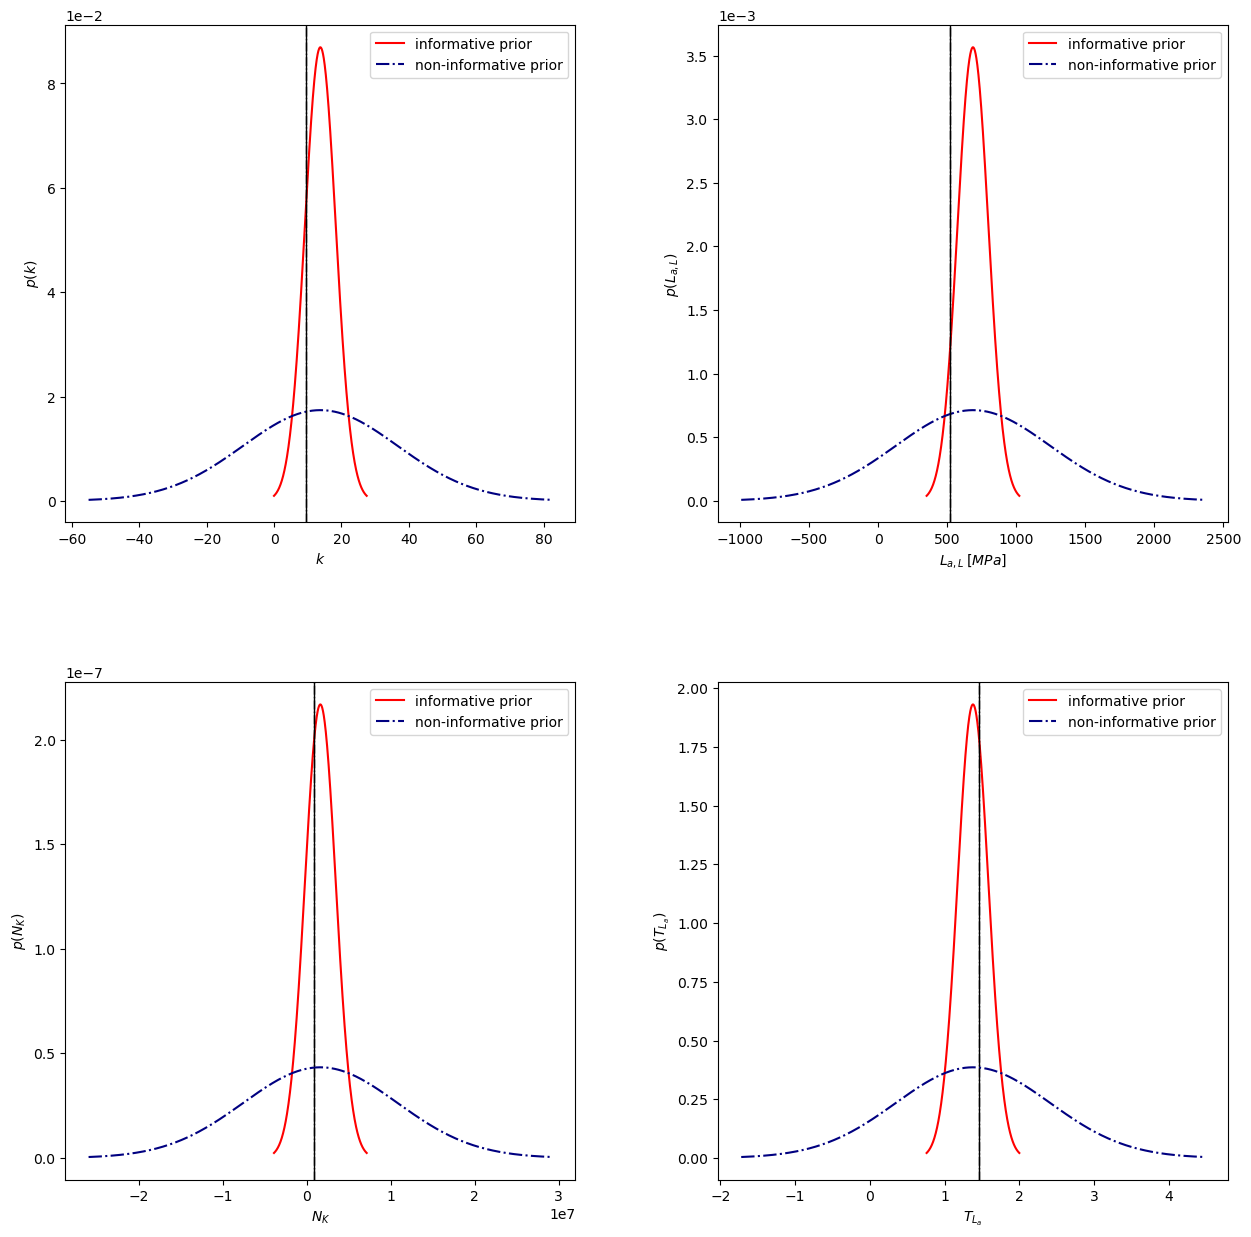

In [5]:
#the black line represents the MLE
#mean and std of each prior:
non_inf = {}
non_inf['k']           = prior_from_ki[expNum]['k']
non_inf['k_std']       = prior_from_ki[expNum]['k_std']      *scale
non_inf['s_d']         = prior_from_ki[expNum]['s_d']
non_inf['s_d_std']     = prior_from_ki[expNum]['s_d_std']    *scale
non_inf['n_e']         = prior_from_ki[expNum]['n_e']
non_inf['n_e_std']     = prior_from_ki[expNum]['n_e_std']    *scale
non_inf['one_t_s']     = prior_from_ki[expNum]['one_t_s']
non_inf['one_t_s_std'] = prior_from_ki[expNum]['one_t_s_std']*scale

fig, axes, gs = plot_functions.create_fig_axes()
plot_functions_T.plot_prior(axes, prior_from_ki[expNum],woehler_params_original[expNum],'red','informative prior','solid')
plot_functions_T.plot_prior(axes, non_inf,woehler_params_original[expNum],'navy','non-informative prior','-.')

## quantile & errors

In [6]:
'''
This code provides the abilitiy to randomize number of samples for the chosen experiment and 
arrange them to have the first three samples as 2 failures and 1 runout in order to draw the woehlermodel 
as soon as possible and to end up with the same number of results which is the number of samples - 2.

randy:   is a dictionary of 2 dimentsion arrays containing all the samples of the chosen experiment, 
where randy['n'] for example is an arry of dimension (num_of_samp X length_of_exp)
'''

length_of_exp_all = [0 for i in range(8)]
for exp in range(8):
    outcome = Outcome[exp]
    s_a = S_a[exp]
    n = N[exp]
    length_of_exp_all[exp] = len(outcome) #represents the number of tests in the experiment
    length_of_exp = length_of_exp_all[exp]    
    s_a_rand_all = [[[0 for i in range(length_of_exp)] for j in range(num_of_samp)]for e in range(8)]
    n_rand_all = [[[0 for i in range(length_of_exp)] for j in range(num_of_samp)]for e in range(8)]
    outcome_rand_all = [[[0 for i in range(length_of_exp)] for j in range(num_of_samp)]for e in range(8)]

for exp in range(8):
    outcome = Outcome[exp]
    s_a = S_a[exp]
    n = N[exp]
    
    randy = {}
    randy['n'] = [[0 for i in range(length_of_exp)] for j in range(num_of_samp)]
    randy['s_a'] = [[0 for i in range(length_of_exp)] for j in range(num_of_samp)]
    randy['outcome'] = [[0 for i in range(length_of_exp)] for j in range(num_of_samp)]
    
    for i in range(num_of_samp):
        random = help_functions.randomize(n, s_a, outcome)
        rand = help_functions.organize(random)
        randy['n'][i] = rand['n']
        randy['s_a'][i] = rand['s_a']
        randy['outcome'][i] = rand['outcome']

    for iii in range(num_of_samp):
        outcome_rand = randy['outcome']
        s_a_rand = randy['s_a']
        n_rand = randy['n']
        failure = 0
        runout = 0

        for ii in range(3): #deciding how many failures and runouts in the first 3 tests
            if 'failure' in outcome_rand[iii][ii]:
                failure += 1
            elif 'runout' in outcome_rand[iii][ii]:
                runout += 1
        runout_indexes, failure_indexes = help_functions.sort_failure_and_runout(outcome_rand[iii])


        i1 = runout_indexes[0]
        i2 = runout_indexes[1]
        ii1 = failure_indexes[0]
        ii2 = failure_indexes[1]

                ## 4 defferent cases for the outcome of the first 3 tests ##
            
        # 2 failures and 1 runout which is what we want to draw the woehler curve
        if failure == 2 and runout == 1:
            s_a_rand = s_a_rand
            n_rand = n_rand
            outcome_rand = outcome_rand
        
        # 3 failures which means that we need to swap one of them for a runout test
        elif failure == 3:
            #print('case2')
            s_a_rand[iii][ii1], s_a_rand[iii][i1] = s_a_rand[iii][i1], s_a_rand[iii][ii1]
            n_rand[iii][ii1], n_rand[iii][i1] = n_rand[iii][i1], n_rand[iii][ii1]
            outcome_rand[iii][ii1], outcome_rand[iii][i1] = outcome_rand[iii][i1], outcome_rand[iii][ii1]

            runout_indexes, failure_indexes = help_functions.sort_failure_and_runout(outcome_rand[iii])
        
        # 3 runouts which means that we need to swap one of them for a failure test
        elif runout == 3:
            s_a_rand[iii][ii1], s_a_rand[iii][i1], s_a_rand[iii][ii2], s_a_rand[iii][i2] = s_a_rand[iii][i1], s_a_rand[iii][ii1], s_a_rand[iii][i2], s_a_rand[iii][ii2]
            n_rand[iii][ii1], n_rand[iii][i1], n_rand[iii][ii2], n_rand[iii][i2] = n_rand[iii][i1], n_rand[iii][ii1], n_rand[iii][i2], n_rand[iii][ii2]
            outcome_rand[iii][ii1], outcome_rand[iii][i1], outcome_rand[iii][ii2], outcome_rand[iii][i2] = outcome_rand[iii][i1], outcome_rand[iii][ii1], outcome_rand[iii][i2], outcome_rand[iii][ii2]

            runout_indexes, failure_indexes = help_functions.sort_failure_and_runout(outcome_rand[iii])
        
        # 1 failures and 2 runout which means that we need to swap one of the runouts with a failure test
        elif failure == 1:
            s_a_rand[iii][ii2], s_a_rand[iii][i1] = s_a_rand[iii][i1], s_a_rand[iii][ii2]
            n_rand[iii][ii2], n_rand[iii][i1] = n_rand[iii][i1], n_rand[iii][ii2]
            outcome_rand[iii][ii2], outcome_rand[iii][i1] = outcome_rand[iii][i1], outcome_rand[iii][ii2]

            runout_indexes, failure_indexes = help_functions.sort_failure_and_runout(outcome_rand[iii])

        i1 = runout_indexes[0]
        i2 = runout_indexes[1]
        ii1 = failure_indexes[0]
        ii2 = failure_indexes[1]
        s_a_rand_all[exp] = s_a_rand
        n_rand_all[exp] = n_rand
        outcome_rand_all[exp] = outcome_rand
        
        #this loop is to prevent any repetetion in the tests especially for the first 3 test
        #in order to draw the woehler curve as fast as possible.
        'If there were repititions the woehler curve will not be drawn until a new point without repition'
        'has been provided'
        for f in failure_indexes:
            ## for loop that sort the sample such that no duplicates appears in the first 2 failures
            ## sometimes two failures happen for the same load level which prevent the optimizer from 
            ## finding the MLE for all the parameters
            if s_a_rand[iii][ii1] == s_a_rand[iii][ii2] and s_a_rand[iii][f] != s_a_rand[iii][ii2]:
                s_a_rand[iii][f], s_a_rand[iii][ii2] = s_a_rand[iii][ii2], s_a_rand[iii][f]
                n_rand[iii][f], n_rand[iii][ii2] = n_rand[iii][ii2], n_rand[iii][f]
                outcome_rand[iii][f],outcome_rand[iii][ii2] = outcome_rand[iii][ii2], outcome_rand[iii][f]
                break
            else:
                continue

        ##print('...end...')

In [7]:
#The MLE(Maximum Likelihood Estimate) for all the parameters in every test of the experiment 

num = num_of_samp-2 #num_of_samples from the parameters
experiments = [0 for i in range(8)]

for exp in range(8):
    l = length_of_exp_all[exp] #number of tests in the experiment
    experiments[exp] = l-2 #number of MLE of the paramter which first appear after 2 failures and a runout

s1,s2,s3 = help_functions.sort_arrays(experiments,num,length_of_exp_all,l,s_a_rand_all,n_rand_all,outcome_rand_all)

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (6.382923700893699, 106.38206168156167), 'ND_50': (312070.3836388453, 12719700.0)}
trying mystic
using scipy
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (6.382923700893699, 106.38206168156167), 'ND_50': (312070.3836388453, 10897200.0)}
trying mystic
using scipy
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (6.382923700893699, 106.38206168156167), 'ND_50': (312070.3836388453, 10897200.0)}
trying mystic
using scipy
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (6.382923700893699, 106.38206168156167), 'ND_50': (312070.3836388453, 10759500.0)}
trying mystic
using scipy
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.258493594344906, 70.97489323908177), 'ND_50': (197591.84083985077, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bo

self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.2000537191308562, 53.33422865218094), 'ND_50': (14332.124333853433, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (46885.07337168835, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.3833462351563708, 23.055770585939513), 'ND_50': (29270.60587674017, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.1730297622019108, 19.550496036698515), 'ND_50': (35302.83509520313, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.1730297622019108, 19.550496036698515), 'ND_50': (35302.83509520313, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.9199470284045329, 15.332450473408883)

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.7118729940239851, 11.864549900399751), 'ND_50': (20967.215907821446, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.5532450363335835, 9.220750605559724), 'ND_50': (26288.320206085078, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.4083319998571395, 6.805533330952326), 'ND_50': (32321.585536247956, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (53585.294341457186, 11505600.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (65464.624860011616, 11505600.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (65585.96545237982, 11505600.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (75238.28437028194, 11505600.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (75238.28437028194, 10897200.0)}
trying mystic
self.

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.6207075989548199, 10.345126649246998), 'ND_50': (34825.21530456354, 10926000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.7921324655526063, 13.202207759210104), 'ND_50': (46639.94147689437, 10926000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.7921324655526063, 13.202207759210104), 'ND_50': (46639.94147689437, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.1491766742198323, 2.4862779036638716), 'ND_50': (35936.669164538645, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.1491766742198323, 2.4862779036638716), 'ND_50': (35936.669164538645, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.6415263738401792, 10.692106230669653), 'ND_50': (32060.545810489228, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.6415263738401792, 10.692106230669653), 'ND_50': (32060.545810489228, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.40833199985713975, 6.805533330952329), 'ND_50': (32321.585536247956, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.40833199985713975, 6.805533330952329), 'ND_50': (32321.585536247956, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016436, 14.734677885027395), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016436, 14.734677885027395), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016436, 14.734677885027395), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016436, 14.734677885027395), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016436, 14.734677885027395), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.9313599986327326, 82.18933331054555), 'ND_50': (147183.15350267317, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.9313599986327326, 82.18933331054555), 'ND_50': (147183.15350267317, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.9313599986327326, 82.18933331054555), 'ND_50': (147183.15350267317, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.9732783585958735, 49.554639309931225), 'ND_50': (96586.48027868499, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.746541693092815, 62.44236155154692), 'ND_50': (154528.8317568219, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.7900953641929009, 13.168256069881682), 'ND_50': (33249.01864061692, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.7900953641929009, 13.168256069881682), 'ND_50': (33249.01864061692, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.4774133546906625, 7.956889244844375), 'ND_50': (29289.883209144467, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.4774133546906625, 7.956889244844375), 'ND_50': (29289.883209144467, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.4774133546906625, 7.956889244844375), 'ND_50': (29289.883209144467, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (4.108250056546781, 68.4708342757797), 'ND_50': (1068239.6204326998, 12928500.0)}
trying mystic
using scipy
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (4.108250056546781, 68.4708342757797), 'ND_50': (1068239.6204326998, 12928500.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.7430942670676415, 45.7182377844607), 'ND_50': (61625.06083196338, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.653062639190646, 27.55104398651077), 'ND_50': (38413.94445470687, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.653062639190646, 27.55104398651077), 'ND_50': (38413.94445470687, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.195910960156118, 19.9318493359353), 'ND_50': (31506.54213932578, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.2801866821579095, 21.336444702631823), 'ND_50': (27939.421355391358, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.2556410726196785, 37.59401787699464), 'ND_50': (11697.012759487321, 12719700.0)}
trying mystic
using scipy
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.2556410726196785, 37.59401787699464), 'ND_50': (11697.012759487321, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.2556410726196785, 37.59401787699464), 'ND_50': (11697.012759487321, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0),

self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1.4873373329277582, 24.78895554879597), 'ND_50': (48927.39826013045, 10926000.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1.4873373329277582, 24.78895554879597), 'ND_50': (48927.39826013045, 10926000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.4873373329277582, 24.78895554879597), 'ND_50': (24067.766142859706, 10926000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.4873373329277582, 24.78895554879597), 'ND_50': (24067.766142859706, 10926000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.2152094582290904, 20.25349097048484), 'ND_50': (21783.297903591574, 10926000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.1569710986159722, 19.282851643599535), 'ND_50': (26414.577128164252, 10926000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.1569710986159722, 19.282851643599535), 'ND_50': (26414.577128164252, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.1762011859583203, 19.603353099305338), 'ND_50': (23312.991861277307, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.1762011859583203, 19.603353099305338), 'ND_50': (23312.991861277307, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.1762011859583203, 19.603353099305338), 'ND_50': (23312.991861277307, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (71059.01597817043, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (42863.144286234325, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (42783.843184503814, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (40548.85747460478, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (40548.85747460478, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (40548.85747460478, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8647381612373887, 14.412302687289811), 'ND_50': (36047.12203424349, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8647381612373887, 14.412302687289811), 'ND_50': (36047.12203424349, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8647381612373887, 14.412302687289811), 'ND_50': (36047.12203424349, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8647381612373887, 14.412302687289811), 'ND_50': (36047.12203424349, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8647381612373887, 14.412302687289811), 'ND_50': (36047.12203424349, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (8.796371709372886, 146.6061951562148), 'ND_50': (11655701.481707683, 10926000.0)}
trying mystic
using scipy
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (8.796371709372886, 146.6061951562148), 'ND_50': (11655701.481707683, 10926000.0)}
trying mystic
using scipy
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 90

using scipy
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.115357672466944, 68.58929454111573), 'ND_50': (17814.819023278396, 10759500.0)}
trying mystic
using scipy
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.115357672466944, 68.58929454111573), 'ND_50': (17814.819023278396, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.115357672466944, 68.58929454111573), 'ND_50': (17814.819023278396, 10759500.0)}
trying mystic
using scipy
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.1623370807434554, 52.70561801239093), 'ND_50': (14512.478153378192, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.986501029329846, 33.108350488830766), 'ND_50': (17219.857210711543, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_5

self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1.2191590051497205, 20.319316752495343), 'ND_50': (59983.15482120426, 16094700.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1.2381932233891617, 20.636553723152694), 'ND_50': (61075.94129419017, 16094700.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1.2381932233891617, 20.636553723152694), 'ND_50': (61075.94129419017, 13463100.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1.2381932233891617, 20.636553723152694), 'ND_50': (61075.94129419017, 10926000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.2381932233891617, 20.636553723152694), 'ND_50': (33835.020636649315, 10926000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.9166325420941613, 15.27720903490269), 'ND_50': (25732.565994817203, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.238425182195058, 37.307086369917634), 'ND_50': (11653.771511053148, 12719700.0)}
trying mystic
using scipy
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.238425182195058, 37.307086369917634), 'ND_50': (11653.771511053148, 12719700.0)}
trying mystic
using scipy
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.238425182195058, 37.307086369917634), 'ND_50': (11653.771511053148, 11505600.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (30

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.3792492096474078, 22.9874868274568), 'ND_50': (29377.644861454977, 11505600.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.6986766047181237, 28.311276745302063), 'ND_50': (28563.91038311191, 11505600.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.6691603166393187, 27.819338610655315), 'ND_50': (34600.26195635925, 11505600.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.6691603166393187, 27.819338610655315), 'ND_50': (34600.26195635925, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.2558988522777657, 20.931647537962764), 'ND_50': (28923.86834596215, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.3110416234365028, 38.51736039060838), 'ND_50': (47855.10108842045, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.7926493696938555, 29.877489494897592), 'ND_50': (37997.76133025788, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.1907749222012423, 19.846248703354036), 'ND_50': (29070.754980345868, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.9166325420941611, 15.277209034902686), 'ND_50': (25732.565994817203, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.9166325420941611, 15.277209034902686), 'ND_50': (25732.565994817203, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (7776.770144169778, 10897200.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (7776.770144169778, 10897200.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (18641.166185921793, 10897200.0)}
trying mystic
WARNING!!! The  SD_50 boundary was reached
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (16076.346244945811, 10897200.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (16076.346244945811, 10897200.0)}
trying mystic
sel

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (40607.89086503457, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (40607.89086503457, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (40607.89086503457, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (50049.85689186721, 10759500.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (50049.85689186721, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (39709.05222904458, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.2500528729981202, 4.167547883302004), 'ND_50': (30416.81082944838, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.4083319998571397, 6.805533330952328), 'ND_50': (32321.585536247956, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.4083319998571397, 6.805533330952328), 'ND_50': (32321.585536247956, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bo

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (4.880208429299165, 81.33680715498608), 'ND_50': (2039476.1848585338, 12928500.0)}
trying mystic
using scipy
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (28855.288980424975, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (28855.288980424975, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.4286493854043359, 7.144156423405599), 'ND_50': (17669.417006301286, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.2851016493978646, 21.418360823297746), 'ND_50': (18131.323211178944, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.1320793027650777, 18.867988379417962), 'ND_50': (17142.505830266582, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.33264664930780913, 5.544110821796819), 'ND_50

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.22590654630434032, 3.765109105072339), 'ND_50': (35581.75935537998, 10759500.0)}
trying mystic
WARNING!!! The  k_1 boundary was reached
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.31234462134915186, 5.205743689152531), 'ND_50': (37061.91214905911, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.43564096746545217, 7.26068279109087), 'ND_50': (31087.300170930117, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8937300859195253, 14.895501431992088), 'ND_50': (29859.87840184748, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8937300859195253, 14.895501431992088), 'ND_50': (29859.87840184748, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_boun

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.2697389524097975, 21.162315873496627), 'ND_50': (37429.510005618664, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (12100.151296929744, 12928500.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_5

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (29089.24016265238, 10759500.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (29089.24016265238, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (29089.24016265238, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (44760.49649310304, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (44760.49649310304, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (44760.49649310304, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

using scipy
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.2093164890199675, 36.82194148366612), 'ND_50': (11822.293668943645, 12719700.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.3493018356309185, 22.48836392718198), 'ND_50': (12751.073006020591, 12719700.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.3493018356309185, 22.48836392718198), 'ND_50': (12751.073006020591, 12719700.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.2301157709920865, 20.501929516534773), 'ND_50': (27653.848831700623, 12719700.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.2301157709920865, 20.501929516534773), 'ND_50': (27653.848831700623, 10926000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0),

using scipy
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.1921005985953466, 36.53500997658911), 'ND_50': (11778.589284917492, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.2007085438076563, 36.67847573012761), 'ND_50': (11800.421243844068, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.2862203723882633, 21.437006206471057), 'ND_50': (13479.501138830634, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.7040408561374287, 28.400680935623814), 'ND_50': (16414.710890037666, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.9939101832660151, 16.565169721100254), 'ND_50': (24760.387913908246, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0)

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.39169345123876054, 6.528224187312675), 'ND_50': (30151.425637821583, 10926000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.39169345123876054, 6.528224187312675), 'ND_50': (30151.425637821583, 10926000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8991038799408182, 14.985064665680303), 'ND_50': (28835.616423478717, 10926000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8991038799408182, 14.985064665680303), 'ND_50': (28835.616423478717, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8991038799408182, 14.985064665680303), 'ND_50': (28835.616423478717, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.40833199985713947, 6.805533330952325), 'ND_50': (32321.58553624802, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.40833199985713947, 6.805533330952325), 'ND_50': (32321.58553624802, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016442, 14.734677885027402), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (1.3298049162490826, 22.163415270818042), 'ND_50': (10871.82953034252, 11505600.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (1.3298049162490826, 22.163415270818042), 'ND_50': (10871.82953034252, 11505600.0)}
trying mystic
using scipy
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (1.3298049162490826, 22.163415270818042), 'ND_50': (10871.82953034252, 10926000.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (1.8361752336366752, 30.602920560611256), 'ND_50': (13263.038515959899, 10926000.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0),

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (29200.506071295793, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (37462.17341429174, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (50839.77684586131, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (50839.77684586131, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.7823045418739049, 13.038409031231748), 'ND_50': (36129.72763384286, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.7823045418739049, 13.038409031231748), 'ND_50': (36129.72763384286, 10759500.0)}
trying mystic
self.fatg_lim 600

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016442, 14.734677885027402), 'ND_50': (31791.265135410533, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016442, 14.734677885027402), 'ND_50': (31791.265135410533, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016442, 14.734677885027402), 'ND_50': (31791.265135410533, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016442, 14.734677885027402), 'ND_50': (31791.265135410533, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016442, 14.734677885027402), 'ND_50': (31791.265135410533, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016436, 14.734677885027395), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016436, 14.734677885027395), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016436, 14.734677885027395), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016436, 14.734677885027395), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016436, 14.734677885027395), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': 

using scipy
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (4.258493594344906, 70.97489323908177), 'ND_50': (526133.9461387937, 13463100.0)}
trying mystic
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (1.2333802104099885, 20.556336840166477), 'ND_50': (41736.40191232221, 13463100.0)}
trying mystic
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (1.2333802104099885, 20.556336840166477), 'ND_50': (41736.40191232221, 13463100.0)}
trying mystic
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (3.157132985555979, 52.61888309259965), 'ND_50': (209124.5048700564, 13463100.0)}
trying mystic
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (3.157132985555979, 52.61888309259965), 'ND_50': (209124.5048700564, 12928500.0)}
trying mystic
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS':

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016442, 14.734677885027402), 'ND_50': (31791.265135410402, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016442, 14.734677885027402), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016442, 14.734677885027402), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016442, 14.734677885027402), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016442, 14.734677885027402), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (36268.35142697921, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (43585.69233740736, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (43585.69233740736, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (50025.625651844224, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.2190418020661424, 20.31736336776904), 'ND_50': (33884.893064018186, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.7840825658195735, 13.068042763659557), 'ND_50': (34573.24765224416, 10759500.0)}
trying mystic
self.fatg_lim 600

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.8823073675236786, 48.038456125394646), 'ND_50': (85613.42532768365, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.7137972322615274, 28.56328720435879), 'ND_50': (42085.08849747863, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.3110416234365028, 38.51736039060838), 'ND_50': (47855.10108842045, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.025378338722979, 17.089638978716316), 'ND_50': (27008.24201726542, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.3468506225885075, 22.447510376475126), 'ND_50': (38671.56370599892, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2)

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016441, 14.7346778850274), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016442, 14.734677885027402), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016442, 14.734677885027402), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016442, 14.734677885027402), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016442, 14.734677885027402), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016442, 14.734677885027402), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (35170.094271395734, 12719700.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (35170.094271395734, 11505600.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (35170.094271395734, 11505600.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (43507.8394623482, 11505600.0)}
trying mystic
self.fatg_lim 

self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1.3503854070025396, 22.506423450042327), 'ND_50': (22595.277360610457, 10897200.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1.2529173119190102, 20.88195519865017), 'ND_50': (40622.946082382805, 10897200.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1.2529173119190102, 20.88195519865017), 'ND_50': (40622.946082382805, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.2529173119190102, 20.88195519865017), 'ND_50': (22346.908743501594, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.2147942753569925, 20.246571255949878), 'ND_50': (28625.80655708596, 10897200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.81492619422937, 13.582103237156167), 'ND_50': (29230.96290375427, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.1907749222012423, 19.84624870335404), 'ND_50': (29070.754980345984, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.1907749222012423, 19.84624870335404), 'ND_50': (29070.754980345984, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.1907749222012423, 19.84624870335404), 'ND_50': (29070.754980345984, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.9166325420941613, 15.27720903490269), 'ND_50': (25732.565994817203, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.8840806731016438, 14.734677885027399), 'ND_50': (31791.265135410402, 10759500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (11065.099860048225, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (4249.290045243141, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (13712.087095087587, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (13712.087095087587, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (13712.087095087587, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (14102.025402727206, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': 

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (20850.11042798907, 11943000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (25239.59928037822, 11943000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (25239.59928037822, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (24429.932097424287, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_b

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3022.7974790407434, 10977300.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (2664.6853154057053, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3237.8516652894027, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3074.7288190784143, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (2912.259765120778, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (5135.121520082499, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (2.8784963381069915, 47.97493896844986), 'ND_50': (62122.91077422291, 12059100.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (2.8784963381069915, 47.97493896844986), 'ND_50': (62122.91077422291, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (2.9621413145984286, 49.36902190997381), 'ND_50': (60384.07315133021, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (2.9621413145984286, 49.36902190997381), 'ND_50': (60384.07315133021, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (2.9621413145984286, 49.36902190997381), 'ND_50': (60384.07315133021, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.17323390074093553, 2.887231679015592), 'ND_50': (20988.487572247635, 12059100.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.07448751533936375, 1.2414585889893959), 'ND_50': (20574.285127680967, 12059100.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (23832.597212687382, 12059100.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (23832.597212687382, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (23832.597212687382, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.4397

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (73246.30972221632, 18000000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': 

self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (11299.604321654846, 12059100.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (11299.604321654846, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (10905.371686580062, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (12523.946012446242, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (12523.946012446242, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (19704.574494432556, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
WARNING!!! The 

self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (2.400284025638148, 40.00473376063581), 'ND_50': (33061.865699413385, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (2.306829761143241, 38.447162685720684), 'ND_50': (34127.35677015568, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1.3987049984402347, 23.31174997400391), 'ND_50': (46447.41733228147, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.3956257378679793, 6.593762297799655), 'ND_50': (27931.391117249226, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.3956257378679793, 6.593762297799655), 'ND_50': (27931.391117249226, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.9378009013885493, 32.296681689809155), 'ND_50': (10732.346591259673, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.9378009013885493, 32.296681689809155), 'ND_50': (10732.346591259673, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.4002881131579428, 23.338135219299048), 'ND_50': (9047.887097257852, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.4002881131579428, 23.338135219299048), 'ND_50': (9047.887097257852, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.3541912172717692, 22.569853621196152), 'ND_50': (9264.066673542182, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (57709.310290888745, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (39670.145003172576, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (39670.145003172576, 10977300.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (30758.848524942092, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (30758.848524942092, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (28652.35706971665, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (17108.29054905617, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (15694.49348927127, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (15694.49348927127, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (19372.410529332275, 10977300.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (18767.546791492965, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_b

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432946, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432946, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (7814.977261590296, 18000000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (7559.842938325786, 18000000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.1360344842043635, 18.933908070072725), 'ND_50': (12407.080733767649, 18000000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (13107.938993366166, 18000000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD

self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1621.5908336591228, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1621.5908336591228, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (4066.824107427933, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3940.7586886693443, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (13630.361524748012, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (12940.127635904755, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': 

self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (19499.75982769846, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (19499.75982769846, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (43180.82786101519, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (43180.82786101519, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (43180.82786101519, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0

self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (3.1484682510936417, 52.474470851560696), 'ND_50': (76815.92662975602, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (2.1785468082746884, 36.30911347124481), 'ND_50': (43659.58448221406, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (2.1785468082746884, 36.30911347124481), 'ND_50': (43659.58448221406, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (2.4872735949022737, 41.45455991503789), 'ND_50': (47507.854414650115, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (2.531006462417148, 42.18344104028581), 'ND_50': (46807.89687808764, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (28697.317257408165, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1.3755477982972457, 22.92579663828743), 'ND_50': (15101.371923397455, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1.0357558021780628, 17.262596702967716), 'ND_50': (14967.809130219011, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.8560860951510927, 14.268101585851545), 'ND_50': (14897.664074325305, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.7937425398262501, 13.229042330437501), 'ND_50': (13724.811144267132, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.7937425

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.14263809973136032, 2.3773016621893386), 'ND_50': (26031.54519077217, 11943000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.17866662725081625, 2.977777120846938), 'ND_50': (24677.739795867674, 11943000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.2254717750300256, 3.7578629171670936), 'ND_50': (23023.587965587158, 11943000.0)}
trying mystic
WARNING!!! The  k_1 boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.26877035976942837, 4.4795059961571395), 'ND_50': (21592.259709020833, 11943000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.26877035976942837, 4.4795059961571395), 'ND_50': (21592.259709020833, 10977300.0)}
trying mystic
WARNING!!! The  1/TS b

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

using scipy
self.fatg_lim 800.0
self.dict_bound {'SD_50': (400.0, 1200.0), '1/TS': (0.5, 2), 'k_1': (2.4841558124692376, 41.402596874487294), 'ND_50': (23079.798779840286, 18000000.0)}
trying mystic
self.fatg_lim 800.0
self.dict_bound {'SD_50': (400.0, 1200.0), '1/TS': (0.5, 2), 'k_1': (2.4841558124692376, 41.402596874487294), 'ND_50': (23079.798779840286, 10977300.0)}
trying mystic
self.fatg_lim 800.0
self.dict_bound {'SD_50': (400.0, 1200.0), '1/TS': (0.5, 2), 'k_1': (6.505975562584464, 108.43292604307439), 'ND_50': (265913.88519804773, 10977300.0)}
trying mystic
self.fatg_lim 800.0
self.dict_bound {'SD_50': (400.0, 1200.0), '1/TS': (0.5, 2), 'k_1': (0.719832490662665, 11.997208177711084), 'ND_50': (24588.187235106307, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.2923935051331692, 4.8732250855528205), 'ND_50': (19514.61955987355, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 11

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (24212.734289878994, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (32285.120931814992, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (32285.120931814992, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (28924.472924016605, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (26756.14000564441, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (23323.904068367134, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': 

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (23909.57541973816, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (23909.57541973816, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (4.885795635513965, 81.42992725856608), 'ND_50': (21118.703190414584, 18000000.0)}
trying mystic
using scipy
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (4.885795635513965, 81.42992725856608), 'ND_50': (21118.703190414584, 18000000.0)}
trying mysti

self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (8974.607938745836, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (4584.277960298399, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (4584.277960298399, 10977300.0)}
trying mystic
WARNING!!! The  SD_50 boundary was reached
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (11339.576202527884, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (11286.562632882371, 10977300.0)}
trying mystic
WARNING!!! The  SD_50 boundary was reached
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (25042.793722541533, 10977300.0)}
t

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.14063359873836942, 2.3438933123061574), 'ND_50': (15742.10932617306, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (18767.546791492965, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (5.647114527780366, 94.11857546300611), 'ND_50': (194993.87296835572, 10977300.0)}
trying mystic
using scipy
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (3.007142426751415, 50.11904044585692), 'ND_50': (24957.619650265522, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (3.007142426751415, 50.11904044585692), 'ND_50': (24957.619650265522, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (14779.720304146

self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (8943.653177479186, 10977300.0)}
trying mystic
WARNING!!! The  SD_50 boundary was reached
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (8943.653177479186, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (19823.28564474216, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (23955.34883884734, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (25817.092374675034, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (23456.211807879467, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_b

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (2.6390634998922176, 43.984391664870294), 'ND_50': (148500.3741724927, 18000000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (2.6390634998922176, 43.984391664870294), 'ND_50': (148500.3741724927, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (2.6390634998922176, 43.984391664870294), 'ND_50': (148500.3741724927, 11943000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (2.6390634998922176, 43.984391664870294), 'ND_50': (61569.42930585233, 11943000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (2.5509688112757307, 42.51614685459551), 'ND_50': (51214.23299342933, 11943000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': 

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (23909.575419738114, 11943000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 11943000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 800.0
self.dict_bound {'SD_50': (400.0, 1200.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (91.88192423716569, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (18290.830675746045, 10977300.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (18290.830675746045, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (18290.830675746045, 10977300.0)}
trying mystic
WARNING!!! The  SD_50 boundary was reached
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.425377240466942, 7.0896206744490335), 'ND_50': (42186.34071021157, 10977300.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS'

self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.5138567571773542, 8.564279286289239), 'ND_50': (8063.6507557330615, 10977300.0)}
trying mystic
WARNING!!! The  SD_50 boundary was reached
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.4810171721650974, 8.01695286941829), 'ND_50': (8271.262581660572, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.1215550676768146, 2.025917794613577), 'ND_50': (6593.979393072222, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.1215550676768146, 2.025917794613577), 'ND_50': (6593.979393072222, 10977300.0)}
trying mystic
WARNING!!! The  SD_50 boundary was reached
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (10339.95254548725, 10977300.0)}
trying mystic
self.fatg_lim 760.0


self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (21520.35165785055, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': 

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (9317.60439728478, 18000000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3487.6035275643135, 18000000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (4499.83944125261, 18000000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.5088384385594356, 8.48064064265726), 'ND_50': (22377.562739488618, 18000000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50'

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (43438.928067770765, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (37282.9192614375, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (32874.51693921288, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (25961.148970776794, 10977300.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (23573.723558071917, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_b

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (4.885795635513965, 81.42992725856608), 'ND_50': (21118.703190414584, 18000000.0)}
trying mystic
using scipy
self.fatg_lim 840.0
self.dic

using scipy
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (4.5571828157823004, 75.95304692970501), 'ND_50': (18245.016303471704, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.996325541653906, 33.272092360898434), 'ND_50': (7918.855385078221, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.8726416030174275, 31.21069338362379), 'ND_50': (9240.51659375282, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.8184960279065705, 30.308267131776176), 'ND_50': (9886.484799145466, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.33812476188696, 22.30207936478267), 'ND_50': (7794.268616691102, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (42648.13402243056, 11943000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (38230.12747667612, 11943000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (38230.12747667612, 11943000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.5755846035092523, 9.593076725154205), 'ND_50': (26293.695624812488, 11943000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.05065858211440073, 0.844309701906679), 'ND_50': (21262.407720973, 11943000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (24435.105126812894, 11943000.0)}
trying mystic
self.fatg_lim

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3807.360770174617, 18000000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (4650.152909699316, 18000000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (7472.950834775714, 18000000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (7190.225322820827, 18000000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (17380.977885360873, 18000000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (16833.352401680742, 18000000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (24473.829378178365, 11943000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (26848.83099277359, 11943000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (26848.83099277359, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (26848.83099277359, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (23832.597212687382, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.3233019900418024, 22.055033167363373), 'ND_50': (8774.47006752111, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.3233019900418024, 22.055033167363373), 'ND_50': (8774.47006752111, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.8374045388722022, 30.62340898120337), 'ND_50': (11220.545555199207, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.8122054099247005, 30.203423498745007), 'ND_50': (11366.4983799938, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.2841389998426134, 21.402316664043557), 'ND_50': (14902.029584326097, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 800.0
self.dict_bound {'SD_50': (400.0, 1200.0), '1/TS': (0.5, 2), 'k_1': (8.955813339631325, 149.2635556605221), 'ND_50': (554607.9709336034, 12059100.0)}
trying mystic
self.fatg_lim 800.0
self.dict_bound {'SD_50': (400.0, 1200.0), '1/TS': (0.5, 2), 'k_1': (8.955813339631325, 149.2635556605221), 'ND_50': (554607.9709336034, 12059100.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.1435652242169642, 2.3927537369494036), 'ND_50': (12781.204222080734, 12059100.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (2.640199355473085, 44.003322591218094), 'ND_50': (57395.95263936197, 12059100.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1.5629865278355255, 26.049775463925428), 'ND_50': (30021.464765020963, 12059100.0)}
trying mystic
self.fatg_lim 840.0
self.dict_b

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432903, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1.9042304514071633, 31.73717419011939), 'ND_50': (10573.21358387035, 18000000.0)}
trying mystic
using scipy
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1.1357003885648136, 18.928339809413558), 'ND_50': (5811.6062455943575, 18000000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1.1357003885648136, 18.928339809413558), 'ND_50': (5811.6062455943575, 18000000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (2.6395051016366646, 43.99175169394441), 'ND_50': (18744.381279092926, 18000000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': 

self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (14496.535419789065, 10977300.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (14013.769919345033, 10977300.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (11386.143322166648, 10977300.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (11253.986420555266, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (16046.436725966892, 10977300.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1, 150), '

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1.6425052019350037, 27.37508669891673), 'ND_50': (24643.002997049032, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1.3075132864334413, 21.791888107224025), 'ND_50': (19117.49655098949, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (1.3075132864334413, 21.791888107224025), 'ND_50': (19117.49655098949, 11943000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.49486394466199646, 8.247732411033276), 'ND_50': (19717.483482480133, 11943000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.6060269702545481, 10.100449504242468), 'ND_50': (19634.312019774152, 11943000.0)}
trying mystic
self.fatg_lim 840.0
self.d

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432855, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (22566.439707432808, 10977300.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS':

self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1.7925308211733113, 29.875513686221854), 'ND_50': (16598.00412599377, 12868200.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (2.382058646447296, 39.70097744078827), 'ND_50': (24960.961522367263, 12868200.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (9548.911713763255, 12868200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (34162.73444217303, 12868200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (34162.73444217303, 12359700.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (34162.73444217303, 10539900.0)}
trying mystic
self.fatg_lim 600.0

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (53649.924977751914, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (53649.924977751914, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (53649.924977751914, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.448059680522811, 24.134328008713517), 'ND_50': (30259.087191716146, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.448059680522811, 24.134328008713517), 'ND_50': (30259.087191716146, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.1514255058206428, 19.190425097010714), 'ND_50': (26284.893020563068, 10539900.

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670821, 33.223548101118034), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670821, 33.223548101118034), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670821, 33.223548101118034), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670821, 33.223548101118034), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670821, 33.223548101118034), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670821, 33.223548101118034), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670821, 33.223548101118034), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670821, 33.223548101118034), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670821, 33.223548101118034), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670821, 33.223548101118034), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

using scipy
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (13.45661200610895, 224.2768667684825), 'ND_50': (1790670.839770862, 18000000.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (13.575100491822388, 226.25167486370646), 'ND_50': (1872642.999089452, 18000000.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (13.575100491822388, 226.25167486370646), 'ND_50': (1872642.999089452, 18000000.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (3.783092044151413, 63.05153406919022), 'ND_50': (339661.56432525883, 18000000.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (3.938419221531333, 65.64032035885555), 'ND_50': (294883.84512219625, 18000000.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.873804752205839, 47.89674587009732), 'ND_50': (30126.15182585125, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.873804752205839, 47.89674587009732), 'ND_50': (30126.15182585125, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.694225187949729, 44.90375313249548), 'ND_50': (33008.50024533806, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.7264255955133945, 45.4404265918899), 'ND_50': (32749.88942181517, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.7264255955133945, 45.4404265918899), 'ND_50': (32749.88942181517, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1.9692196077197566, 32.82032679532928), 'ND_50': (49527.87126618942, 18000000.0)}
trying mystic
using scipy
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1.9126695639438398, 31.877826065730662), 'ND_50': (69607.38394709698, 18000000.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.

using scipy
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.6990265344770838, 11.65044224128473), 'ND_50': (6116.662444757753, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.6990265344770838, 11.65044224128473), 'ND_50': (6116.662444757753, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.6990265344770838, 11.65044224128473), 'ND_50': (6116.662444757753, 12868200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.6331323659209196, 10.552206098681992), 'ND_50': (9384.122114746233, 12868200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.5861999558087915, 9.769999263479859), 'ND_50': (12728.700229552878, 12868200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/T

self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.0518658408133292, 17.53109734688882), 'ND_50': (71543.03334828837, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.0518658408133292, 17.53109734688882), 'ND_50': (71543.03334828837, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.0517192203141277, 17.52865367190213), 'ND_50': (71543.08066586345, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.7956668566124128, 29.927780943540213), 'ND_50': (81312.91883174963, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.9886389306535237, 33.14398217755873), 'ND_50': (91021.5150355989, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.3139965402580893, 38.56660900430149), 'ND_50': (21018.375681704918, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.6885772920222535, 44.80962153370423), 'ND_50': (23109.983884227677, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.5537156308641884, 42.561927181069805), 'ND_50': (24807.137592200892, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.4119442736340906, 40.199071227234846), 'ND_50': (26725.7894092455, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067082, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067082, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067082, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067082, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067082, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067082, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (7.419357602462298, 123.6559600410383), 'ND_50': (74851.12830985243, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (7.419357602462298, 123.6559600410383), 'ND_50': (74851.12830985243, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (7.419357602462298, 123.6559600410383), 'ND_50': (74851.12830985243, 10539900.0)}
trying mystic
using scipy
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (7.7665721143841, 129.44286857306832), 'ND_50': (71652.010925354, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (7.7665721143841, 129.44286857306832), 'ND_50': (71652.010925354, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2),

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.3142292147933523, 21.903820246555874), 'ND_50': (27152.981456516103, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.3142292147933523, 21.903820246555874), 'ND_50': (27152.981456516103, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.2643075270950466, 21.071792118250777), 'ND_50': (27910.952022536825, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.6226410449135023, 27.044017415225035), 'ND_50': (30440.760688162576, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.6226410449135023, 27.044017415225035), 'ND_50': (30440.760688162576, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067082, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067082, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067082, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067082, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067082, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (1.1364848937186545, 18.94141489531091), 'ND_50': (579338.1972030461, 18000000.0)}
trying mystic
using scipy
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 

self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (2.8990448591887876, 48.31741431981313), 'ND_50': (94641.81305881936, 18000000.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (2.8990448591887876, 48.31741431981313), 'ND_50': (94641.81305881936, 18000000.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (2.8900763414448765, 48.16793902408128), 'ND_50': (93722.23054666279, 18000000.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (2.8900763414448765, 48.16793902408128), 'ND_50': (93722.23054666279, 10539900.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (2.345121731359484, 39.085362189324734), 'ND_50': (75638.11626926911, 10539900.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 

self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (36420.41154296482, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (0.015866525381875163, 0.26444208969791944), 'ND_50': (41809.88310509361, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (53777.767573531484, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (52315.22983599042, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (0.1284670337126398, 2.1411172285439966), 'ND_50': (40556.503242955136, 10539900.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (0.9950630847480404, 16.5843847458006

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.382645836394503, 56.377430606575054), 'ND_50': (67699.9221227442, 22979700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.1873138894909494, 53.121898158182496), 'ND_50': (51375.57846928554, 22979700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.9759443864058293, 32.932406440097154), 'ND_50': (59349.36749329204, 22979700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.7933028157555364, 29.888380262592275), 'ND_50': (49002.13360654425, 22979700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.3909238896221225, 39.84873149370205), 'ND_50': (67069.85356862417, 22979700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2)

self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (3.0140874245493383, 50.23479040915564), 'ND_50': (255700.03078651542, 12868200.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (2.6194834215590626, 43.65805702598438), 'ND_50': (157991.99013497806, 12868200.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (3.0443666923090054, 50.73944487181676), 'ND_50': (237176.76816562942, 12868200.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (2.9356161219965453, 48.92693536660909), 'ND_50': (205043.8488986862, 12868200.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (2.830910074675073, 47.18183457791788), 'ND_50': (178226.6928699537, 12868200.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2)

self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.6695543960463655, 27.825906600772758), 'ND_50': (37150.67448613618, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.5734707976874578, 26.224513294790963), 'ND_50': (38117.62617168534, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.9809918462019949, 33.01653077003325), 'ND_50': (48979.63850325543, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.9809918462019949, 33.01653077003325), 'ND_50': (48979.63850325543, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.4743026906407115, 41.23837817734519), 'ND_50': (66348.08004735391, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.47430269

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (4569.975919413098, 12868200.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (4264.701

self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (3.735870931227125, 62.264515520452086), 'ND_50': (25360.234885643775, 18000000.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (3.0602113889949107, 51.00352314991518), 'ND_50': (14316.393172420754, 18000000.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (3.0727247473503314, 51.21207912250553), 'ND_50': (14212.066232773179, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.8695313157286666, 47.82552192881111), 'ND_50': (46536.56422471202, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.5554230139896474, 42.590383566494125), 'ND_50': (37853.20564433844, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 

self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.5406718294383173, 59.01119715730529), 'ND_50': (96987.0439218629, 12868200.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.5872527351030583, 59.78754558505098), 'ND_50': (71919.52560759438, 12868200.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.8585489731411133, 47.642482885685226), 'ND_50': (68835.53247531067, 12868200.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.0508750704030616, 50.847917840051025), 'ND_50': (76682.32003220286, 12868200.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.0393700165972817, 33.989500276621364), 'ND_50': (86734.53603031172, 12868200.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2)

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.135179295082528, 35.586321584708806), 'ND_50': (36182.631514513785, 12359700.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.135179295082528, 35.586321584708806), 'ND_50': (36182.631514513785, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (4.422417709600569, 73.70696182667615), 'ND_50': (427136.42807664466, 18000000.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (3.874674194529725, 64.57790324216208), 'ND_50': (377109.54507500964, 18000000.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (2.7732268723331885, 46.22044787221981), 'ND_50': (293549.04424809886, 18000000.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (1.9621616443798098, 32.702694072996835), 'ND_50': (137580.7969271234, 18000000.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (1.6994773070004536, 28.324621783340895), 'ND_50': (107637.3308210162, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.961060617905264, 49.35101029842107), 'ND_50': (29186.91706383305, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.8980172329518874, 48.30028721586479), 'ND_50': (27652.242104644738, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.781349684700345, 46.35582807833909), 'ND_50': (25021.849694678334, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.781349684700345, 46.35582807833909), 'ND_50': (25021.849694678334, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.781349684700345, 46.35582807833909), 'ND_50': (25021.849694678334, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670821, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670821, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670821, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670821, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670821, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670806, 33.22354810111801), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670806, 33.22354810111801), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670806, 33.22354810111801), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670806, 33.22354810111801), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670806, 33.22354810111801), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067082, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067082, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067082, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067082, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (40379.69218021263, 18000000.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (2.3166505290397623, 38.6108

self.fatg_lim 580.0
self.dict_bound {'SD_50': (290.0, 870.0), '1/TS': (0.5, 2), 'k_1': (0.2098286330984747, 3.4971438849745784), 'ND_50': (462631.16903217987, 12359700.0)}
trying mystic
using scipy
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (153612.8328630958, 12359700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (153612.8328630958, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (97562.04556161059, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (77668.41128453625, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (80490.49731101815, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.6210471471543773, 27.017452452572957), 'ND_50': (33245.51214325109, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.4911444327792032, 24.85240721298672), 'ND_50': (36175.1883881713, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.4911444327792032, 24.85240721298672), 'ND_50': (36175.1883881713, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.8402181612676265, 30.67030268779378), 'ND_50': (28830.390596444246, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.694685125968751, 28.244752099479182), 'ND_50': (26906.031096623392, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2),

self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.8165207488607726, 30.27534581434621), 'ND_50': (68833.32810298914, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.0537944662932266, 34.229907771553776), 'ND_50': (70966.96969052196, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.0537944662932266, 34.229907771553776), 'ND_50': (70966.96969052196, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (67064.01514176154, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (67064.01514176154, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2)

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (35165.15508908062, 18000000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (37835.31205900696, 12359700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (24267.484394153773, 12359700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (17518.566330015925, 12359700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (18888.29191197466, 12359700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (13263.933924428602, 12359700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2),

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.3415462985116267, 55.692438308527116), 'ND_50': (27605.15244367435, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.0540441502565483, 50.90073583760913), 'ND_50': (22587.68850346597, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.638499588364806, 43.97499313941344), 'ND_50': (29593.748123656587, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.562791190607174, 42.71318651011956), 'ND_50': (31086.805013174326, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.562791190607174, 42.71318651011956), 'ND_50': (31086.805013174326, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2),

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (30416.352414017754, 22979700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.3990386307846079, 23.317310513076798), 'ND_50': (30390.88421113923, 22979700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.134707578589928, 35.57845964316547), 'ND_50': (38929.55014975907, 22979700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.134707578589928, 35.57

self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (2.7436555450677482, 45.727592417795805), 'ND_50': (32059.24400931043, 18000000.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (2.7436555450677482, 45.727592417795805), 'ND_50': (32059.24400931043, 12868200.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (0.6573213432357271, 10.955355720595453), 'ND_50': (19148.13987859926, 12868200.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (13187.934361576423, 12868200.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (13210.815477346638, 12868200.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (0.15802515612978368, 2.6337526021630615), 'ND_50'

self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (2.686873258374353, 44.78122097290588), 'ND_50': (161994.66562807374, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.686873258374353, 44.78122097290588), 'ND_50': (81311.01787457668, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.686873258374353, 44.78122097290588), 'ND_50': (81311.01787457668, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.550474731658125, 42.50791219430209), 'ND_50': (69466.76525099919, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.5034495580419116, 41.72415930069853), 'ND_50': (65796.80802793708, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067082, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067082, 33.223548101118034), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (29120.262881524857, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (29120.262881524857, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (27011.54716948527, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.5031905702074524, 41.719842836790875), 'ND_50': (23120.395872143334, 18000000.0)}
t

self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.4054151931762164, 40.09025321960361), 'ND_50': (145483.0720664418, 12868200.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.694234227183515, 44.903903786391915), 'ND_50': (179704.27813978048, 12868200.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.915950785283721, 48.59917975472869), 'ND_50': (158966.60338737365, 12868200.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.6275462315183495, 43.79243719197249), 'ND_50': (119222.38791758983, 12868200.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.6275462315183495, 43.79243719197249), 'ND_50': (119222.38791758983, 12359700.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2

self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.8328180515469659, 30.546967525782765), 'ND_50': (88384.98756917795, 12359700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.314726272929034, 38.5787712154839), 'ND_50': (94887.37489339236, 12359700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.6819346643434496, 44.69891107239083), 'ND_50': (120831.61236978149, 12359700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.6819346643434496, 44.69891107239083), 'ND_50': (120831.61236978149, 12359700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.6819346643434496, 44.69891107239083), 'ND_50': (120831.61236978149, 12359700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2)

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.7557176261610323, 29.261960436017205), 'ND_50': (35114.011895532254, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2)

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (40379.69218021263, 18000000.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (40379.69218021263, 18000000.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (13584.33733742231, 18000000.0)}
trying

self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (12.258704874715095, 204.31174791191825), 'ND_50': (14922.348712152563, 18000000.0)}
trying mystic
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (12.55818165756356, 209.30302762605933), 'ND_50': (13858.257705116359, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (6.15537201186236, 102.58953353103934), 'ND_50': (6720.263355171871, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (6.166901190693288, 102.78168651155481), 'ND_50': (6215.622310255597, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (6.166901190693288, 102.78168651155481), 'ND_50': (6215.622310255597, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2)

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.0213951518108217, 33.689919196847036), 'ND_50': (31378.986029321415, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.387072206825368, 39.7845367804228), 'ND_50': (26879.035193200758, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.4147180995848236, 40.245301659747064), 'ND_50': (26686.862768490308, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.0422667452458407, 34.03777908743068), 'ND_50': (32456.02205542494, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.135179295082528, 35.5863215847088), 'ND_50': (36182.63151451467, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1':

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.159994225606021, 35.99990376010035), 'ND_50': (33327.73421441834, 12359700.0)}
trying mystic
using scipy
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (2.159994225606021, 35.99990376010035), 'ND_50': (9807.2324141357, 12359700.0)}
trying mystic
using scipy
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.103079964912095, 35.05133274853492), 'ND_50': (22589.19149839233, 12359700.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0),

using scipy
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.2623813569652587, 37.70635594942098), 'ND_50': (36765.983273511985, 12359700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.0567806032787597, 50.946343387979326), 'ND_50': (63950.24693042923, 12359700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.6588687916463565, 44.31447986077261), 'ND_50': (72027.83322566212, 12359700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.156527748744705, 52.608795812411756), 'ND_50': (99886.04695683297, 12359700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.156527748744705, 52.608795812411756), 'ND_50': (99886.04695683297, 12359700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/T

self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.6445419124667433, 44.07569854111239), 'ND_50': (42171.94835963986, 18000000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.6445419124667433, 44.07569854111239), 'ND_50': (42171.94835963986, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.488991425124682, 41.4831904187447), 'ND_50': (36640.602915083604, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.235516312466369, 37.25860520777282), 'ND_50': (35391.449960714155, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.7446440762835052, 29.07740127139175), 'ND_50': (42438.91213268899, 10539900.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), '

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.3109234158625056, 38.51539026437509), 'ND_50': (41450.23294889612, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.3109234158625056, 38.51539026437509), 'ND_50': (41450.23294889612, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.3109234158625056, 38.51539026437509), 'ND_50': (41450.23294889612, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.0442195864987838, 34.070326441646394), 'ND_50': (36192.605439693165, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.7777642588905198, 29.629404314841995), 'ND_50': (31605.859692025067, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1505.4347692073552, 18000000.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1505.4347692073552, 18000000.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (0.08525513870607414, 1.420918978434569), 'ND_50': (98442.78520276763, 18000000.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (0.7636418546172571, 12.72736424362095), 'ND_50': (114864.6095271561, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.7636418546172571, 12.72736424362095), 'ND_50': (72215.8502082639, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.1383639697438384, 18.972732829063975), 'ND_50': (6

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.4935126815348188, 41.55854469224698), 'ND_50': (27342.85952081704, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.350406172534364, 39.17343620890607), 'ND_50': (24744.57882862154, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.350406172534364, 39.17343620890607), 'ND_50': (24744.57882862154, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.350406172534364, 39.17343620890607), 'ND_50': (24744.57882862154, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.2435286245862756, 37.3921437431046), 'ND_50': (26338.045076790644, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670817, 33.22354810111803), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670808, 33.22354810111801), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670812, 33.22354810111803), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1.9692196077197566, 32.82032679532928), 'ND_50': (49527.87126618942, 12868200.0)}
trying mystic
using scipy
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (1.9692196077197566, 32.82032679532928), 'ND_50': (12674.311208569387, 12868200.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (3.2851307439351762, 54.75217906558627), 'ND_50': (17317.946658663725, 12868200.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (2.9362644478769955, 48.93774079794993), 'ND_50': (12890.81589941475, 12868200.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/T

self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.5724460352951979, 26.207433921586635), 'ND_50': (33313.50505709517, 22979700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.1641092338399086, 19.401820563998477), 'ND_50': (23807.915875525185, 22979700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.2010016688074034, 36.68336114679006), 'ND_50': (44557.63668854627, 22979700.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.2010016688074034, 36.68336114679006), 'ND_50': (44557.63668854627, 18000000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.025869760226451, 50.43116267044085), 'ND_50': (73360.64680268885, 18000000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2)

self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (30464.36331938276, 10539900.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (39785.66304170543, 10539900.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (29917.780166320143, 10539900.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (28437.30635328382, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (49227.320166841164, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.4443263570837356, 7.405439284728926), 'ND_50': (30768.244888513706, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (3

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.7891362684258376, 13.152271140430628), 'ND_50': (35006.057207712394, 12359700.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.5787737350001994, 9.64622891666999), 'ND_50': (32005.831244680023, 12359700.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.5787737350001994, 9.64622891666999), 'ND_50': (32005.831244680023, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.5787737350001994, 9.64622891666999), 'ND_50': (32005.831244680023, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.2888199171428811, 21.480331952381352), 'ND_50': (36648.8599120897, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2)

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.3801032501689126, 23.001720836148543), 'ND_50': (33667.08546713039, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.8356138330445135, 30.593563884075227), 'ND_50': (36772.557729433414, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.0726990637221463, 34.54498439536911), 'ND_50': (34882.642928451685, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.0726990637221463, 34.54498439536911), 'ND_50': (34882.642928451685, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.993412886067081, 33.22354810111802), 'ND_50': (33300.0061320834, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670823, 33.22354810111804), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670823, 33.22354810111804), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670823, 33.22354810111804), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670823, 33.22354810111804), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670823, 33.22354810111804), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670823, 33.22354810111804), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670823, 33.22354810111804), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9934128860670823, 33.22354810111804), 'ND_50': (33300.00613208312, 10539900.0)}
trying mystic
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (9.322910297755474, 155.38183829592458), 'ND_50': (14420141.629900241, 18000000.0)}
trying mystic
using scipy
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (6.774809152399066, 112.91348587331777), 'ND_50': (1705816.7217837642, 18000000.0)}
trying mystic
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/T

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.3626889178985633, 56.04481529830939), 'ND_50': (17095.47118977579, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.3626889178985633, 56.04481529830939), 'ND_50': (17095.47118977579, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.488937471503191, 74.81562452505318), 'ND_50': (19091.537207808524, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.488937471503191, 74.81562452505318), 'ND_50': (19091.537207808524, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.424394701257063, 73.7399116876177), 'ND_50': (17808.019185120054, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'S

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.9450402212793699, 15.750670354656167), 'ND_50': (53015.03648367539, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.5504836851808192, 25.841394753013653), 'ND_50': (62147.4290544544, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.5504836851808192, 25.841394753013653), 'ND_50': (62147.4290544544, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.5504836851808192, 25.841394753013653), 'ND_50': (62147.4290544544, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9135988029770648, 31.89331338295108), 'ND_50': (50227.29184605656, 10539900.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2),

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.045166147043848, 67.41943578406413), 'ND_50': (31811.41273522156, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.045166147043848, 67.41943578406413), 'ND_50': (31811.41273522156, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), '

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 580.0
self.dict_bound {'SD_50': (290.0, 870.0), '1/TS': (0.5, 2), 'k_1': (6.542529851921292, 109.0421641986882), 'ND_50': (38509.35171410526, 9748800.0)}
trying mystic
using scipy
self.fatg_lim 580.0
self.dict_bound {'SD_50': (290.0, 870.0), '1/TS': (0.5, 2), 'k_1': (4.562584405440856, 76.04307342401428), 'ND_50': (55004.43788923014, 9748800.0)}
trying mystic
self.fatg_lim 580.0
self.dict_bound {'SD_50': (290.0, 870.0), '1/TS': (0.5, 2), 'k_1': (4.181477716268302, 69.69129527113836), 'ND_50': (108637.91101460895, 9748800.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.79018596534464, 63.169766089077335), 'ND_50': (206511.2644047578, 9748800.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (4.090017016241905, 68.16695027069842), 'ND_50': (175111.75968821425, 9748800.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.244471928638346, 54.074532143972434), 'ND_50': (14025.203414044006, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.2665267642244804, 54.44211273707467), 'ND_50': (13825.537663343372, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.283739669903817, 71.39566116506361), 'ND_50': (21323.181322272427, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.865312820220668, 64.42188033701113), 'ND_50': (17842.223007244145, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.342259294994745, 72.37098824991241), 'ND_50': (19743.02222934196, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 580.0
self.dict_bound {'SD_50': (290.0, 870.0), '1/TS': (0.5, 2), 'k_1': (6.316868389286959, 105.28113982144932), 'ND_50': (41806.06201401628, 10945800.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (7.452406593104531, 124.20677655174218), 'ND_50': (484270.12579458905, 10945800.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (7.452406593104531, 124.20677655174218), 'ND_50': (484270.12579458905, 10945800.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (7.544994146842162, 125.74990244736938), 'ND_50': (482966.35604834266, 10945800.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (7.753692074373517, 129.22820123955862), 'ND_50': (480040.4388269604, 10945800.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.9242280280598023, 65.40380046766337), 'ND_50': (24049.19474837055, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.9242280280598023, 65.40380046766337), 'ND_50': (24049.19474837055, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.962037810437517, 49.367296840625286), 'ND_50': (37872.82107198256, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.3519628302620497, 55.86604717103416), 'ND_50': (31506.625654525167, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.3519628302620497, 55.86604717103416), 'ND_50': (31506.625654525167, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.689969663058036, 61.499494384300604), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.689969663058036, 61.499494384300604), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (2.0132075468044004, 33.553459113406674), 'ND_50': (24171.23419513794, 11226600.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (3.7403579576076313, 62.33929929346053), 'ND_50': (79884.19076517523, 11226600.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (3.87221501327215, 64.53691688786917), 'ND_50': (141688.68736708903, 11226600.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (18410.043014047806, 10945800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (18410.043014047806, 10945800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (15300.440342638592, 10945800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (14142.044856156615, 10945800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.8714673500921513, 31.191122501535858), 'ND_50': (16921.089944518157, 10945800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.8714673500921513, 31.191122501535858), 'ND_50': (16921.089944518157, 10945800.0)}
trying mystic
self.fatg_li

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.689969663058038, 61.49949438430063), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.689969663058038, 61.49949438430063), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.689969663058038, 61.49949438430063), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (3.0374003099387927, 50.623338498979884), 'ND_50': (2255323.4311633203, 12606300.0)}
trying mystic
using scipy
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (7.6595625101673335, 127.65937516945556), 'ND_50': (7064556.805742456, 12606300.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (158464.0252788589, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (148034.02487500626, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (148034.02487500626, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (148034.02487500626, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (148264.09924911484, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9664237867650496, 32.77372977941749), 'ND_50': (50003.094712196005, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.045166147043848, 67.41943578406413), 'ND_50': (31811.41273522156, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1':

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (96176.41131345708, 13194000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (96176.41131345708, 12142800.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (1.135878743494601, 18.931312391576686), 'ND_50': (103538.27335764958, 12142800.0)}
trying mystic
self.fatg_lim 580.0
self.dict_bound {'SD_50': (290.0, 870.0), '1/TS': (0.5, 2), 'k_1': (1.13587874349

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.102713284389619, 51.71188807316032), 'ND_50': (29624.678430144668, 11035800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.102713284389619, 51.71188807316032), 'ND_50': (29624.678430144668, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.474174483749843, 57.90290806249739), 'ND_50': (25721.67742328123, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.474174483749843, 57.90290806249739), 'ND_50': (25721.67742328123, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.802745269446149, 63.37908782410249), 'ND_50': (22700.17223865761, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

using scipy
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (7.470628420399993, 124.51047367333322), 'ND_50': (309487.99604601116, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (4.517723403380182, 75.29539005633636), 'ND_50': (168582.7759247151, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.784827635413539, 63.080460590225655), 'ND_50': (104156.19030295941, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.784827635413539, 63.080460590225655), 'ND_50': (104156.19030295941, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.956243958218886, 65.9373993036481), 'ND_50': (98953.53119156965, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.

self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.9726509327388952, 66.2108488789816), 'ND_50': (28576.657148479026, 12606300.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.962524807846448, 66.04208013077414), 'ND_50': (28463.26827055354, 12606300.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.962524807846448, 66.04208013077414), 'ND_50': (28463.26827055354, 11035800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.962524807846448, 66.04208013077414), 'ND_50': (28463.26827055354, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.689969663058036

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (4.580306847171038, 76.33844745285064), 'ND_50': (244947.78696057387, 11226600.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (4.580306847171038, 76.33844745285064), 'ND_50': (244947.78696057387, 11035800.0)}
trying mystic
self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (3.366645314202707, 56.11075523671179), 'ND_50': (159320.42410108718, 11035800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.366645314202707, 56.11075523671179), 'ND_50': (20591.479438201204, 11035800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.4447394845938493, 57.412324743230826), 'ND_50': (21744.60380518433, 11035800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2),

self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.9726509327388957, 66.21084887898161), 'ND_50': (115329.36023345371, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.962524807846448, 66.04208013077414), 'ND_50': (114463.95236759394, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.962524807846448, 66.04208013077414), 'ND_50': (28463.26827055354, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), '

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.1231955220761438, 18.719925367935733), 'ND_50': (7129.405854041134, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.1203938384983476, 18.67323064163913), 'ND_50': (7260.332898973144, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.0239659985012277, 17.066099975020464), 'ND_50': (13582.111952710859, 18000000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.0239659985012277, 17.066099975020464), 'ND_50': (13582.111952710859, 12606300.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.0239659985012277, 17.066099975020464), 'ND_50': (13582.111952710859, 12606300.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.9691327380944754, 66.1522123015746), 'ND_50': (30680.12153073788, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1':

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (2083.8254473213087, 11226600.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (73612.31906036712, 11226600.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (80991.47128449375, 11226600.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (80991.47128449375, 11226600.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (30327.5065201921, 11226600.0)}
trying mystic
self.fat

self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (4.824350984447485, 80.40584974079141), 'ND_50': (204658.75117703635, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.824350984447485, 80.40584974079141), 'ND_50': (37600.735282161746, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (5.696223678663718, 94.93706131106197), 'ND_50': (26989.12867295796, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.767552254826946, 62.7925375804491), 'ND_50': (56201.524990194426, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.343210255301345, 72.38683758835576), 'ND_50': (45150.90875755941, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.380962319724208, 73.01603866207014), 'ND_50': (24640.86038032629, 10945800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.380962319724208, 73.01603866207014), 'ND_50': (24640.86038032629, 10945800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.4598534253293705, 24.330890422156173), 'ND_50': (61715.14202374138, 10945800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.4598534253293705, 24.330890422156173), 'ND_50': (61715.14202374138, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.4598534253293705, 24.330890422156173), 'ND_50': (61715.14202374138, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), '

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 580.0
self.dict_bound {'SD_50': (290.0, 870.0), '1/TS': (0.5, 2), 'k_1': (0.3644858773842881, 6.074764623071469), 'ND_50': (5071.707019335873, 9748800.0)}
trying mystic
using scipy
self.fatg_lim 580.0
self.dict_bound {'SD_50': (290.0, 870.0), '1/TS': (0.5, 2), 'k_1': (0.7623038016312015, 12.705063360520025), 'ND_50': (6755.805516564687, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.7623038016312015, 12.705063360520025), 'ND_50': (6198.193876355762, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.497177109454481, 58.28628515757468), 'ND_50': (18787.019555185703, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.497177109454481, 58.28628515757468), 'ND_50': (18787.019555185703, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.423973590741586, 57.06622651235976), 'ND_50': (30224.267099364115, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.9952671893006073, 49.92111982167679), 'ND_50': (26665.92080902388, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.4112840919453173, 40.18806819908862), 'ND_50': (20793.518780280832, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.4112840919453173, 40.18806819908862), 'ND_50': (20793.518780280832, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.156107578279988, 35.93512630466647), 'ND_50': (18651.93746157758, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

/home/tareqawwad/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.898096335284785, 64.96827225474642), 'ND_50': (77628.18158732809, 9748800.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.970978560757784, 66.18297601262974), 'ND_50': (74577.55519981592, 9748800.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.970978560757784, 66.18297601262974), 'ND_50': (74577.55519981592, 9748800.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.970978560757784, 66.18297601262974), 'ND_50': (74577.55519981592, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.4926209283253074, 58.21034880542179), 'ND_50': (48398.25935924499, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 580.0
self.dict_bound {'SD_50': (290.0, 870.0), '1/TS': (0.5, 2), 'k_1': (6.126883127959744, 102.11471879932908), 'ND_50': (44799.43554995429, 9748800.0)}
trying mystic
using scipy
self.fatg_lim 580.0
self.dict_bound {'SD_50': (290.0, 870.0), '1/TS': (0.5, 2), 'k_1': (6.126883127959744, 102.11471879932908), 'ND_50': (44799.43554995429, 9748800.0)}
trying mystic
using scipy
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (6.048130492912925, 100.8021748818821), 'ND_50': (172262.78623214737, 9748800.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (4.367241567860783, 72.78735946434638), 'ND_50': (150344.47767997353, 9748800.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.8842596633912265, 64.73766105652045), 'ND_50': (106060.44797087458, 9748800.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0)

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.135878743494601, 18.931312391576686), 'ND_50': (51915.84622203938, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.2641318425743322, 4.40219737623887), 'ND_50': (34136.02908330182, 9207000.0)}
trying mystic
WARNING!!! The  k_1 boundary was reached
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.2641318425743322, 4.40219737623887), 'ND_50': (34136.02908330182, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.1647185275401057, 19.411975459001763), 'ND_50': (24236.105127459017, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.1647185275401057, 19.411975459001763), 'ND_50': (24236.105127459017, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_5

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.209402288046755, 70.15670480077927), 'ND_50': (21020.657693646866, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.209402288046755, 70.15670480077927), 'ND_50': (21020.657693646866, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.4825413685515034, 58.04235614252506), 'ND_50': (29623.4926831772, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1':

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (8547.113639568252, 11226600.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (10629.626086926792, 11226600.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1.2945029648572117, 21.575049414286866), 'ND_50': (35828.025527939346, 11226600.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1.2945029648572117, 21.575049414286866), 'ND_50': (35828.025527939346, 11226600.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1.2945029648572117, 21.575049414286866), 'ND_50': (35828.025527939346, 11035800.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.2945029648572117, 21.575049414286866), 'ND_50

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.6841543741294127, 28.069239568823544), 'ND_50': (24017.754037914037, 10945800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.6841543741294127, 28.069239568823544), 'ND_50': (24017.754037914037, 10945800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.6841543741294127, 28.069239568823544), 'ND_50': (24017.754037914037, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1.9128848668209821, 31.881414447016372), 'ND_50': (21247.806864030677, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (2.6997355200716813, 44.995592001194694), 'ND_50': (30868.769943486608, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.

self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.576782960204722, 59.61304933674537), 'ND_50': (47195.82378866033, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.576782960204722, 59.61304933674537), 'ND_50': (13438.625842581798, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.804591963072485, 63.409866051208084), 'ND_50': (14807.996368437693, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.804591963072485, 63.409866051208084), 'ND_50': (14807.996368437693, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.1675156485778664, 52.79192747629778), 'ND_50': (20831.647466312865, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (2.0132075468044004, 33.553459113406674), 'ND_50': (24171.23419513794, 12142800.0)}
trying mystic
using scipy
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.0132075468044004, 33.553459113406674), 'ND_50': (18763.238303379952, 9748800.0)}
trying mystic
using scipy
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.9854695608839608, 33.091159348066014), 'ND_50': (18700.251920590374, 9748800.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 8

self.fatg_lim 500.0
self.dict_bound {'SD_50': (250.0, 750.0), '1/TS': (0.5, 2), 'k_1': (0.44377530863836456, 7.396255143972743), 'ND_50': (48737.711641570175, 12606300.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (0.44377530863836456, 7.396255143972743), 'ND_50': (43493.364990224916, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (0.44377530863836456, 7.396255143972743), 'ND_50': (43493.364990224916, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (0.44377530863836456, 7.396255143972743), 'ND_50': (43493.364990224916, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.9367123316939965, 32.27853886156661), 'ND_50': (54519.15836185948, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 

self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.263365812096081, 54.38943020160135), 'ND_50': (115879.11948712985, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.7958582932204687, 46.597638220341146), 'ND_50': (78763.38040756277, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.7958582932204687, 46.597638220341146), 'ND_50': (78763.38040756277, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.0034886411358537, 50.058144018930896), 'ND_50': (76839.48538019336, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.2116773151109688, 53.527955251849484), 'ND_50': (74957.59917175061, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), '

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.8559216963512557, 64.26536160585427), 'ND_50': (30029.387497194333, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.8559216963512557, 64.26536160585427), 'ND_50': (30029.387497194333, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.8559216963512557, 64.26536160585427), 'ND_50': (30029.387497194333, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.8559216963512557, 64.26536160585427), 'ND_50': (30029.387497194333, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.465268157098237, 74.42113595163728), 'ND_50': (40255.41217634546, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.191501956787202, 53.191699279786704), 'ND_50': (43044.86478199404, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.5831558838272026, 59.719264730453375), 'ND_50': (41587.57676840274, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.9082048188589265, 65.13674698098211), 'ND_50': (44957.935017658194, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.2139350283448, 70.23225047241334), 'ND_50': (38165.65293820303, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.754732040323383, 62.57886733872305), 'ND_50': (31385.326598576063, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1':

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.689969663058038, 61.49949438430063), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.689969663058038, 61.49949438430063), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.689969663058038, 61.49949438430063), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.689969663058038, 61.49949438430063), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (5.412032396569984, 90.20053994283307), 'ND_50': (260418.15956491634, 12142800.0)}
trying mystic
using scipy
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0

using scipy
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (15449.996747743537, 9748800.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (15449.996747743537, 9207000.0)}
trying mystic
WARNING!!! The  SD_50 boundary was reached
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (15449.996747743537, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.8484662201714515, 47.47443700285753), 'ND_50': (176725.10962848752, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.8484662201714515, 47.47443700285753), 'ND_50': (176725.10962848752, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.3494193346798604, 55.8236555

self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.197862456743478, 53.29770761239131), 'ND_50': (90090.37862685439, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.365564153339296, 56.092735888988265), 'ND_50': (82151.43435471662, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.443721213605684, 57.39535356009473), 'ND_50': (87295.93122190206, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.443721213605684, 57.39535356009473), 'ND_50': (87295.93122190206, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.057561448984972, 50.95935748308287), 'ND_50': (64663.75389134626, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (2.6595321304041115, 44.32553550673519), 'ND_50': (28355.545059937573, 12142800.0)}
trying mystic
using scipy
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (2.6595321304041115, 44.32553550673519), 'ND_50': (28355.545059937573, 12142800.0)}
trying mystic
using scipy
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (12069.815924871396, 12142800.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (8876.035629233169, 12142800.0)}
trying mystic
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (12313.967666147373, 12142800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (20626.43807000014, 12142800.0)}
trying

self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.0973351779323914, 18.288919632206525), 'ND_50': (11308.557516235456, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.4009258815392263, 23.348764692320437), 'ND_50': (11732.49884653178, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (3.5721434838182424, 59.53572473030405), 'ND_50': (40124.55942685789, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1.3536803501823003, 22.561339169705008), 'ND_50': (30662.927201767714, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (2.041542827817016, 34.02571379695027), 'ND_50': (38651.074681666716, 9207000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.7774483516908504, 62.957472528180844), 'ND_50': (14935.252248223333, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.797286279966521, 63.28810466610868), 'ND_50': (14782.484207654717, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.145374399865592, 52.422906664426534), 'ND_50': (20724.321514585696, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.045166147043848, 67.41943578406413), 'ND_50': (31811.41273522156, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2)

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580374, 61.499494384300625), 'ND_50': (26860.752650031292, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5,

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.689969663058035, 61.49949438430059), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.689969663058035, 61.49949438430059), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.689969663058035, 61.49949438430059), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.689969663058035, 61.49949438430059), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.689969663058035, 61.49949438430059), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.

using scipy
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (4.140206660500767, 69.00344434167945), 'ND_50': (19815.482611200685, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.517723403380182, 75.29539005633636), 'ND_50': (34494.319432432705, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.517723403380182, 75.29539005633636), 'ND_50': (34494.319432432705, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.722566354554631, 78.70943924257718), 'ND_50': (36724.409384734914, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (4.722566354554631, 78.70943924257718), 'ND_50': (36724.409384734914, 9748800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (3.6899696630580365, 61.49949438430062), 'ND_50': (26860.75265003173, 9207000.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1'

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.914847353733283, 98.58078922888805), 'ND_50': (3601948.153855971, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.941887353596949, 99.03145589328248), 'ND_50': (3613663.1640042225, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.885040748010284, 98.08401246683808), 'ND_50': (3387109.142784178, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.883651772060081, 98.06086286766802), 'ND_50': (3373902.115252192, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.909376195790615, 98.48960326317692), 'ND_50': (3447565.2557106083, 929751318.9)}
trying mystic
self.fatg_lim 747.

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.236034168050486, 103.93390280084142), 'ND_50': (4563134.744737676, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.224428368163684, 103.74047280272806), 'ND_50': (4492937.763409807, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.224627620880136, 103.7437936813356), 'ND_50': (4459044.99975109, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.313749217215562, 105.22915362025935), 'ND_50': (5008105.915468001, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.313749217215562, 105.22915362025935), 'ND_50': (5008105.915468001, 929751318.9)}
trying mystic
self.fatg_lim 747

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.44

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 746.38

self.fatg_lim 779.5287500000001
self.dict_bound {'SD_50': (389.76437500000003, 1169.2931250000001), '1/TS': (0.5, 2), 'k_1': (6.429221866809242, 107.15369778015403), 'ND_50': (1588635.448995546, 950129929.8000001)}
trying mystic
self.fatg_lim 779.5287500000001
self.dict_bound {'SD_50': (389.76437500000003, 1169.2931250000001), '1/TS': (0.5, 2), 'k_1': (8.185417986821236, 136.42363311368726), 'ND_50': (720222.5162149178, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (8.31546842836352, 138.59114047272533), 'ND_50': (4025732.439487253, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (8.426341160079083, 140.4390193346514), 'ND_50': (6567197.037700803, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (8.573516310254545, 142.89193850424243)

self.fatg_lim 714.29735
self.dict_bound {'SD_50': (357.148675, 1071.4460250000002), '1/TS': (0.5, 2), 'k_1': (8.825311057091938, 147.08851761819895), 'ND_50': (215140779.45433015, 970955206.2)}
trying mystic
self.fatg_lim 681.3768
self.dict_bound {'SD_50': (340.6884, 1022.0652), '1/TS': (0.5, 2), 'k_1': (7.238551323094745, 120.64252205157908), 'ND_50': (126254052.80491456, 970955206.2)}
trying mystic
self.fatg_lim 681.3768
self.dict_bound {'SD_50': (340.6884, 1022.0652), '1/TS': (0.5, 2), 'k_1': (7.129296028501615, 118.82160047502693), 'ND_50': (141791780.91470325, 970955206.2)}
trying mystic
self.fatg_lim 681.3768
self.dict_bound {'SD_50': (340.6884, 1022.0652), '1/TS': (0.5, 2), 'k_1': (7.441367562631519, 124.02279271052532), 'ND_50': (218924032.60698965, 970955206.2)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.617049278540967, 110.28415464234945), 'ND_50': (279654569.2460101, 970955206.

self.fatg_lim 746.3846000000001
self.dict_bound {'SD_50': (373.19230000000005, 1119.5769), '1/TS': (0.5, 2), 'k_1': (10.151222432700996, 169.1870405450166), 'ND_50': (46799092.91195929, 950129929.8000001)}
trying mystic
self.fatg_lim 714.29735
self.dict_bound {'SD_50': (357.148675, 1071.4460250000002), '1/TS': (0.5, 2), 'k_1': (10.308781950474952, 171.81303250791586), 'ND_50': (240607807.07908863, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (7.489992801405459, 124.83321335675767), 'ND_50': (279297981.8573341, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (7.039416385616166, 117.3236064269361), 'ND_50': (168830235.48178247, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0

self.fatg_lim 714.29735
self.dict_bound {'SD_50': (357.148675, 1071.4460250000002), '1/TS': (0.5, 2), 'k_1': (9.127433517930074, 152.12389196550123), 'ND_50': (104114778.65862823, 970955206.2)}
trying mystic
self.fatg_lim 681.3768
self.dict_bound {'SD_50': (340.6884, 1022.0652), '1/TS': (0.5, 2), 'k_1': (9.084163710314066, 151.40272850523442), 'ND_50': (420120635.14380133, 970955206.2)}
trying mystic
self.fatg_lim 681.3768
self.dict_bound {'SD_50': (340.6884, 1022.0652), '1/TS': (0.5, 2), 'k_1': (9.584229094777683, 159.73715157962806), 'ND_50': (508579580.91098434, 970955206.2)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (8.077928773305018, 134.63214622175033), 'ND_50': (478096707.9794379, 970955206.2)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (8.187347812565397, 136.45579687608998), 'ND_50': (613

using scipy
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (8.325282237620382, 138.7547039603397), 'ND_50': (55005668.748894826, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (8.34124570890724, 139.02076181512066), 'ND_50': (55014138.67679445, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.298373720682231, 104.97289534470384), 'ND_50': (5352698.862651139, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.29536060220348, 104.92267670339133), 'ND_50': (5346415.8694575615, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (4.659197353639664, 77.65328922732775), 'ND_50': (1392789.2561195751, 929751318.9)}
trying mystic
self

self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.809515444090741, 96.82525740151236), 'ND_50': (98152618.41318274, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.903792610725933, 98.39654351209889), 'ND_50': (95503538.35217525, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.714687722161948, 111.91146203603246), 'ND_50': (118456936.87478934, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.714687722161948, 111.91146203603246), 'ND_50': (118456936.87478934, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5,

self.fatg_lim 714.29735
self.dict_bound {'SD_50': (357.148675, 1071.4460250000002), '1/TS': (0.5, 2), 'k_1': (9.7317722789192, 162.19620464865332), 'ND_50': (160682002.65941522, 970955206.2)}
trying mystic
self.fatg_lim 714.29735
self.dict_bound {'SD_50': (357.148675, 1071.4460250000002), '1/TS': (0.5, 2), 'k_1': (8.932814964346218, 148.88024940577031), 'ND_50': (66747306.38446549, 970955206.2)}
trying mystic
self.fatg_lim 681.3768
self.dict_bound {'SD_50': (340.6884, 1022.0652), '1/TS': (0.5, 2), 'k_1': (8.269021503558925, 137.81702505931543), 'ND_50': (132548657.95368499, 970955206.2)}
trying mystic
self.fatg_lim 681.3768
self.dict_bound {'SD_50': (340.6884, 1022.0652), '1/TS': (0.5, 2), 'k_1': (8.3965886945063, 139.94314490843834), 'ND_50': (157839911.59206453, 970955206.2)}
trying mystic
self.fatg_lim 681.3768
self.dict_bound {'SD_50': (340.6884, 1022.0652), '1/TS': (0.5, 2), 'k_1': (8.160813908887087, 136.01356514811812), 'ND_50': (160406741.1191236, 970955206.2)}
trying mystic
se

self.fatg_lim 714.29735
self.dict_bound {'SD_50': (357.148675, 1071.4460250000002), '1/TS': (0.5, 2), 'k_1': (7.818501561273107, 130.30835935455178), 'ND_50': (154972720.6668572, 929751318.9)}
trying mystic
self.fatg_lim 714.29735
self.dict_bound {'SD_50': (357.148675, 1071.4460250000002), '1/TS': (0.5, 2), 'k_1': (8.068600918348595, 134.4766819724766), 'ND_50': (270239643.77057123, 929751318.9)}
trying mystic
self.fatg_lim 714.29735
self.dict_bound {'SD_50': (357.148675, 1071.4460250000002), '1/TS': (0.5, 2), 'k_1': (7.493981778476276, 124.89969630793794), 'ND_50': (72819004.22019213, 929751318.9)}
trying mystic
self.fatg_lim 714.29735
self.dict_bound {'SD_50': (357.148675, 1071.4460250000002), '1/TS': (0.5, 2), 'k_1': (8.142716970068136, 135.71194950113562), 'ND_50': (109857175.44321255, 929751318.9)}
trying mystic
self.fatg_lim 714.29735
self.dict_bound {'SD_50': (357.148675, 1071.4460250000002), '1/TS': (0.5, 2), 'k_1': (8.349132792229273, 139.15221320382122), 'ND_50': (137197631.8

using scipy
self.fatg_lim 746.3846000000001
self.dict_bound {'SD_50': (373.19230000000005, 1119.5769), '1/TS': (0.5, 2), 'k_1': (6.592526024198726, 109.87543373664543), 'ND_50': (6374561.53718663, 970955206.2)}
trying mystic
self.fatg_lim 746.3846000000001
self.dict_bound {'SD_50': (373.19230000000005, 1119.5769), '1/TS': (0.5, 2), 'k_1': (6.4436424095984535, 107.39404015997422), 'ND_50': (5910950.403352617, 970955206.2)}
trying mystic
self.fatg_lim 746.3846000000001
self.dict_bound {'SD_50': (373.19230000000005, 1119.5769), '1/TS': (0.5, 2), 'k_1': (8.075106457339722, 134.58510762232868), 'ND_50': (32187556.380323213, 970955206.2)}
trying mystic
self.fatg_lim 746.3846000000001
self.dict_bound {'SD_50': (373.19230000000005, 1119.5769), '1/TS': (0.5, 2), 'k_1': (8.563214130122184, 142.7202355020364), 'ND_50': (40499007.79467232, 970955206.2)}
trying mystic
self.fatg_lim 681.73885
self.dict_bound {'SD_50': (340.869425, 1022.6082749999999), '1/TS': (0.5, 2), 'k_1': (5.842496767943416, 97.

self.fatg_lim 681.3768
self.dict_bound {'SD_50': (340.6884, 1022.0652), '1/TS': (0.5, 2), 'k_1': (7.833902193193845, 130.56503655323075), 'ND_50': (60534089.22479651, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (7.491064117929582, 124.85106863215972), 'ND_50': (147816806.1134346, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (7.421713525069554, 123.6952254178259), 'ND_50': (128191595.1608781, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (7.013620259496392, 116.89367099160654), 'ND_50': (76533724.8509121, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 

self.fatg_lim 681.3768
self.dict_bound {'SD_50': (340.6884, 1022.0652), '1/TS': (0.5, 2), 'k_1': (9.382291837673812, 156.37153062789687), 'ND_50': (489337584.2986998, 970955206.2)}
trying mystic
self.fatg_lim 681.3768
self.dict_bound {'SD_50': (340.6884, 1022.0652), '1/TS': (0.5, 2), 'k_1': (9.587070862488124, 159.78451437480206), 'ND_50': (625470017.350691, 970955206.2)}
trying mystic
self.fatg_lim 681.3768
self.dict_bound {'SD_50': (340.6884, 1022.0652), '1/TS': (0.5, 2), 'k_1': (9.48551852455787, 158.09197540929785), 'ND_50': (670890990.7382154, 970955206.2)}
trying mystic
self.fatg_lim 681.3768
self.dict_bound {'SD_50': (340.6884, 1022.0652), '1/TS': (0.5, 2), 'k_1': (7.927155588892506, 132.1192598148751), 'ND_50': (128917191.18839237, 970955206.2)}
trying mystic
self.fatg_lim 681.3768
self.dict_bound {'SD_50': (340.6884, 1022.0652), '1/TS': (0.5, 2), 'k_1': (7.769290620180204, 129.48817700300341), 'ND_50': (106072027.92870407, 970955206.2)}
trying mystic
self.fatg_lim 681.3768
sel

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (8.509308222327194, 141.82180370545325), 'ND_50': (45875789.599365994, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (8.792647797379951, 146.54412995633254), 'ND_50': (48439449.94403917, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (8.746384158595863, 145.77306930993106), 'ND_50': (47628110.61577546, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (8.91886224478878, 148.647704079813), 'ND_50': (58419291.206666276, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (8.89870827485519, 148.31180458091984), 'ND_50': (61496817.12065951, 950129929.8000001)}
t

self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.009749644945825, 100.16249408243041), 'ND_50': (69818121.3689669, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.237390584105263, 103.95650973508772), 'ND_50': (77093058.75454465, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.236344814784004, 103.93908024640007), 'ND_50': (76980496.77155916, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.454189610441941, 107.56982684069902), 'ND_50': (104368124.6590441, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.385400

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.688618819630576, 94.81031366050959), 'ND_50': (4189128.0452562175, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.99670856841038, 99.94514280683967), 'ND_50': (4082283.8601984894, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.940773218710475, 99.01288697850791), 'ND_50': (4101477.4702559267, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.212555677156809, 103.54259461928015), 'ND_50': (5134075.400862131, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.3207636970712935, 105.3460616178549), 'ND_50': (5083597.249824517, 929751318.9)}
trying mystic
self.fatg_lim 74

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.410916911006982, 123.51528185011638), 'ND_50': (10471778.714691466, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.56994798653434, 126.16579977557235), 'ND_50': (12153707.746429669, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.543418253434172, 125.72363755723622), 'ND_50': (12320211.909613222, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.109951902892247, 118.49919838153745), 'ND_50': (9259353.638463933, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.109951902892247, 118.49919838153745), 'ND_50': (9259353.638463933, 929751318.9)}
trying mystic
self.fatg_lim

self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.255581028700004, 104.25968381166675), 'ND_50': (88846882.44545813, 970955206.2)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.259458570713785, 104.32430951189643), 'ND_50': (89040348.17593774, 970955206.2)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.215362320112388, 103.58937200187313), 'ND_50': (84454743.92138179, 970955206.2)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.303916534847885, 105.06527558079809), 'ND_50': (99264484.76626785, 970955206.2)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5,

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.1656310849743114, 102.7605180829052), 'ND_50': (5880593.892147165, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.221725893377877, 103.69543155629796), 'ND_50': (5879787.282088576, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.27839354452824, 104.639892408804), 'ND_50': (6398036.176221267, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.381242756185481, 106.35404593642468), 'ND_50': (5980311.932419779, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.381242756185481, 106.35404593642468), 'ND_50': (5980311.932419779, 929751318.9)}
trying mystic
self.fatg_lim 747.

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.455444359680251, 107.59073932800419), 'ND_50': (4279308.81195978, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.5350852029322715, 108.91808671553787), 'ND_50': (4785839.489349743, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.431850131898244, 107.19750219830408), 'ND_50': (5067015.312082028, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.414663205181984, 106.91105341969974), 'ND_50': (5062623.108750642, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502504042, 929751318.9)}
trying mystic
self.fatg_lim 74

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.45479294602902, 107.579882433817), 'ND_50': (4830489.035829935, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330065, 106.70743358883442), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330065, 106.70743358883442), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330065, 106.70743358883442), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330065, 106.70743358883442), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.42355800559945, 107.05930009332417), 'ND_50': (4918313.93686033, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.42355800559945, 107.05930009332417), 'ND_50': (4918313.93686033, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330065, 106.70743358883442), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330065, 106.70743358883442), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330065, 106.70743358883442), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4

self.fatg_lim 812.4077
self.dict_bound {'SD_50': (406.20385, 1218.61155), '1/TS': (0.5, 2), 'k_1': (10.252431908375566, 170.87386513959277), 'ND_50': (19837381.708714288, 929751318.9)}
trying mystic
using scipy
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.958199155068509, 99.30331925114182), 'ND_50': (5821498.133369218, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.179281743744649, 119.65469572907749), 'ND_50': (16063121.031720378, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.0711749017045324, 117.85291502840889), 'ND_50': (6398163.497377632, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.836100072030732, 113.9350012005122), 'ND_50': (5363850.417258731, 929751318.9)}
trying mystic
s

self.fatg_lim 714.29735
self.dict_bound {'SD_50': (357.148675, 1071.4460250000002), '1/TS': (0.5, 2), 'k_1': (8.38605990720687, 139.7676651201145), 'ND_50': (119222436.65462713, 950129929.8000001)}
trying mystic
self.fatg_lim 681.3768
self.dict_bound {'SD_50': (340.6884, 1022.0652), '1/TS': (0.5, 2), 'k_1': (7.164014986726845, 119.40024977878075), 'ND_50': (123804713.02776164, 950129929.8000001)}
trying mystic
self.fatg_lim 681.3768
self.dict_bound {'SD_50': (340.6884, 1022.0652), '1/TS': (0.5, 2), 'k_1': (7.026370721278885, 117.10617868798141), 'ND_50': (65925662.62769605, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.699574061129558, 111.65956768549263), 'ND_50': (145021930.09032443, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.708939078884719, 111.81565131

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.42639092643279, 90.43984877387983), 'ND_50': (2482643.2293980126, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.656615624107678, 94.2769270684613), 'ND_50': (2528649.2634637, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.0592974952803225, 100.98829158800538), 'ND_50': (3587427.4152227947, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.209593220270604, 103.49322033784341), 'ND_50': (4365975.415231952, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.212273802255476, 103.53789670425795), 'ND_50': (4366697.766490239, 929751318.9)}
trying mystic
self.fatg_lim 747.

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.65116119817787, 110.85268663629783), 'ND_50': (11320400.858772984, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.65116119817787, 110.85268663629783), 'ND_50': (11320400.858772984, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.855166239012721, 114.25277065021203), 'ND_50': (13055736.636353074, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.847387965700452, 114.12313276167421), 'ND_50': (13478925.271271717, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.910505681637946, 115.17509469396578), 'ND_50': (13604576.87447792, 929751318.9)}
trying mystic
self.fa

self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.536688420220315, 92.27814033700525), 'ND_50': (54251761.96106821, 970955206.2)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.536688420220315, 92.27814033700525), 'ND_50': (3995215.81960438, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.682812041306812, 94.71353402178022), 'ND_50': (4040701.553281683, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.682812041306812, 94.71353402178022), 'ND_50': (4040701.553281683, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.630570111610761, 93.8428351935127), 'ND_50': (3779755.624082709, 9501299

self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.694288757292363, 111.57147928820606), 'ND_50': (192319878.04895636, 970955206.2)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.699282757521971, 111.65471262536619), 'ND_50': (155567366.96433964, 970955206.2)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.699282757521971, 111.65471262536619), 'ND_50': (155567366.96433964, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.54024340062058, 109.00405667700966), 'ND_50': (130236926.446891, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.4490039527969625, 124.15006587994938), 'ND_50': (8803160.299755502, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.390020122459746, 123.16700204099577), 'ND_50': (8738778.54028157, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.292063334973728, 121.5343889162288), 'ND_50': (8632895.82677048, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.292063334973728, 121.5343889162288), 'ND_50': (8632895.82677048, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.21610119417229, 120.26835323620483), 'ND_50': (8648660.518748669, 929751318.9)}
trying mystic
se

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.961908313475815, 99.36513855793025), 'ND_50': (4115474.403590593, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.118755974485574, 101.97926624142625), 'ND_50': (4721247.291493219, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.161087431585614, 102.6847905264269), 'ND_50': (4722010.217525008, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.1618483974015845, 102.69747329002641), 'ND_50': (4676813.630390353, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.260996123766131, 104.34993539610218), 'ND_50': (4410504.504947682, 929751318.9)}
trying mystic
self.fatg_lim 74

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502504042, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502504042, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502504042, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502504042, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502504042, 929751318.9)}
trying mystic
self.fatg_lim 714.29

self.fatg_lim 681.73885
self.dict_bound {'SD_50': (340.869425, 1022.6082749999999), '1/TS': (0.5, 2), 'k_1': (3.2727444782458437, 54.5457413040974), 'ND_50': (1972784.8150652256, 950129929.8000001)}
trying mystic
self.fatg_lim 681.73885
self.dict_bound {'SD_50': (340.869425, 1022.6082749999999), '1/TS': (0.5, 2), 'k_1': (2.651583095259707, 44.193051587661785), 'ND_50': (2054986.2330953314, 950129929.8000001)}
trying mystic
self.fatg_lim 681.73885
self.dict_bound {'SD_50': (340.869425, 1022.6082749999999), '1/TS': (0.5, 2), 'k_1': (3.352049791209896, 55.867496520164934), 'ND_50': (2860434.159581685, 950129929.8000001)}
trying mystic
self.fatg_lim 681.73885
self.dict_bound {'SD_50': (340.869425, 1022.6082749999999), '1/TS': (0.5, 2), 'k_1': (4.392861114579382, 73.21435190965639), 'ND_50': (9397590.898540651, 950129929.8000001)}
trying mystic
self.fatg_lim 681.73885
self.dict_bound {'SD_50': (340.869425, 1022.6082749999999), '1/TS': (0.5, 2), 'k_1': (4.392861114579382, 73.21435190965639),

self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.679593750350505, 111.32656250584175), 'ND_50': (146492039.12796956, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.600667575784624, 110.01112626307707), 'ND_50': (124826052.13041554, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.591070879392288, 109.8511813232048), 'ND_50': (131705539.33604008, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.9913368275406125, 99.85561379234355), 'ND_50': (60942529.56995426, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.882204069181509, 114.70340115302517), 'ND_50': (5453708.369330342, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.748142952502238, 112.46904920837062), 'ND_50': (4893305.414279496, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.62658331260821, 110.44305521013683), 'ND_50': (4505574.37804841, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.883376309977757, 98.05627183296264), 'ND_50': (2719897.9323053015, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.0234658844876305, 100.39109807479385), 'ND_50': (2126682.6299245553, 929751318.9)}
trying mystic
self.fatg_lim 7

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.967939593537593, 116.13232655895987), 'ND_50': (4888208.241282213, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.967939593537593, 116.13232655895987), 'ND_50': (4888208.241282213, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.955425333879462, 115.9237555646577), 'ND_50': (5089354.980519907, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.956211641923287, 115.93686069872146), 'ND_50': (5075771.80685688, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.050128989095154, 117.50214981825258), 'ND_50': (5868914.714708028, 929751318.9)}
trying mystic
self.fatg_lim 747

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.492632469359872, 108.21054115599787), 'ND_50': (3950779.478442898, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.492632469359872, 108.21054115599787), 'ND_50': (3950779.478442898, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.537249353994174, 108.9541558999029), 'ND_50': (3935097.4749863073, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.572330326660428, 109.5388387776738), 'ND_50': (4508201.998579185, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.7921120364925205, 113.20186727487535), 'ND_50': (5404237.980038223, 929751318.9)}
trying mystic
self.fatg_lim 7

self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.088820254976437, 101.48033758294062), 'ND_50': (105873196.21278995, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.18761205214196, 103.12686753569933), 'ND_50': (110960138.98795527, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.2195939830955265, 103.65989971825877), 'ND_50': (118620812.06929268, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.065738745130073, 101.09564575216788), 'ND_50': (112372386.10892898, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.065738

self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.213758833042113, 103.56264721736855), 'ND_50': (74993337.30835411, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.323992910991863, 105.39988184986439), 'ND_50': (89201452.9298672, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.303884426403872, 105.06474044006454), 'ND_50': (86422535.33717768, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.303884426403872, 105.06474044006454), 'ND_50': (86422535.33717768, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.2990185879734995, 121.65030979955833), 'ND_50': (7988124.115845525, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.921563821129882, 115.35939701883137), 'ND_50': (5956076.37556256, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.921563821129882, 115.35939701883137), 'ND_50': (5956076.37556256, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.998908986054247, 116.64848310090413), 'ND_50': (6019236.696456397, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.016211520562103, 116.93685867603506), 'ND_50': (6447797.174567987, 929751318.9)}
trying mystic
self.fatg_lim 74

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.289073303310694, 104.81788838851158), 'ND_50': (4923637.913349208, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.345848710817201, 105.76414518028669), 'ND_50': (5255717.447854802, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402343686027816, 106.7057281004636), 'ND_50': (5608386.062173874, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.4176698248176285, 106.96116374696048), 'ND_50': (5619116.78682436, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.4176698248176285, 106.96116374696048), 'ND_50': (5619116.78682436, 929751318.9)}
trying mystic
self.fatg_lim 74

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.349109707914297, 105.81849513190497), 'ND_50': (5010406.7618078375, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330065, 106.70743358883442), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330065, 106.70743358883442), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330065, 106.70743358883442), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330065, 106.70743358883442), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.439255815277862, 107.32093025463104), 'ND_50': (4771096.018633447, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.519441053895856, 108.65735089826428), 'ND_50': (4801763.962339351, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.4299014040545845, 107.16502340090975), 'ND_50': (5076066.891832207, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502504042, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502504042, 929751318.9)}
trying mystic
self.fatg_lim 74

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330069, 106.70743358883449), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330069, 106.70743358883449), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330069, 106.70743358883449), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330069, 106.70743358883449), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330069, 106.70743358883449), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 7

using scipy
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.11188225034327, 85.19803750572117), 'ND_50': (2759743.697617936, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (3.9506374090899543, 65.8439568181659), 'ND_50': (594877.8088802665, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.784916456449245, 113.08194094082074), 'ND_50': (4985755.081735521, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.233935738822845, 87.2322623137141), 'ND_50': (1853365.5966625283, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.233935738822845, 87.2322623137141), 'ND_50': (1853365.5966625283, 929751318.9)

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.176246389161688, 119.60410648602814), 'ND_50': (4810454.346774269, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.176246389161688, 119.60410648602814), 'ND_50': (4810454.346774269, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.098113672161996, 118.30189453603326), 'ND_50': (4277328.307956064, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.102577637436723, 118.37629395727872), 'ND_50': (5507389.728998416, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.989370939542843, 116.48951565904738), 'ND_50': (5493080.774900748, 950129929.8000001)}

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.47687121184909, 107.94785353081818), 'ND_50': (7637691.246856432, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.287916934857001, 104.79861558095001), 'ND_50': (6705163.255477828, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.5150195494234575, 108.58365915705762), 'ND_50': (5849752.517886637, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.731793299592303, 112.19655499320504), 'ND_50': (5770416.1524486365, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.669405727488409, 111.15676212480682), 'ND_50': (5726483.514833703, 929751318.9)}
trying mystic
self.fatg_lim 

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.293405812915151, 104.89009688191919), 'ND_50': (4940045.470708324, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.209459736004338, 103.49099560007231), 'ND_50': (4979489.044727365, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.86072190443445, 97.67869840724083), 'ND_50': (3714638.75353415, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.880239565882313, 98.00399276470522), 'ND_50': (3775856.9227825124, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.832926103880054, 97.21543506466757), 'ND_50': (3859882.018705691, 929751318.9)}
trying mystic
self.fatg_lim 747.4

self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (4.587313477735544, 76.45522462892575), 'ND_50': (7370821.952575348, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (4.677362519178953, 77.95604198631588), 'ND_50': (7862979.761510221, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (4.677362519178953, 77.95604198631588), 'ND_50': (868044.6339107332, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.211781074624927, 86.86301791041545), 'ND_50': (1469232.577217939, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.395331565319928, 89.92219275533215), 'ND_50': (15337

self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.078646290456311, 101.3107715076052), 'ND_50': (3797062.442708467, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.0997493025915634, 101.66248837652606), 'ND_50': (3792330.5909538753, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.835247810118362, 97.25413016863936), 'ND_50': (3975623.6591883805, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.04516843495791, 100.75280724929851), 'ND_50': (3586498.907595775, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.099992904744427, 101.66654841240712), 'ND_50': (3064125.044924864, 950129929.8000001)}
trying mystic
self.fat

/home/tareqawwad/Downloads/Masterthesis-master-20230212T073451Z-001/Masterthesis-master/WoehlerParams2.py:167: RuntimeWarning: overflow encountered in double_scalars
  self.N0 = 10**self.b_wl


self.fatg_lim 811.94685
self.dict_bound {'SD_50': (405.973425, 1217.920275), '1/TS': (0.5, 2), 'k_1': (5.672240306818629, 94.53733844697715), 'ND_50': (2578752.5710589457, 950129929.8000001)}
trying mystic
self.fatg_lim 811.94685
self.dict_bound {'SD_50': (405.973425, 1217.920275), '1/TS': (0.5, 2), 'k_1': (5.89390596216066, 98.231766036011), 'ND_50': (1342706.3736948534, 950129929.8000001)}
trying mystic
self.fatg_lim 811.94685
self.dict_bound {'SD_50': (405.973425, 1217.920275), '1/TS': (0.5, 2), 'k_1': (5.89390596216066, 98.231766036011), 'ND_50': (1342706.3736948534, 929751318.9)}
trying mystic
self.fatg_lim 811.94685
self.dict_bound {'SD_50': (405.973425, 1217.920275), '1/TS': (0.5, 2), 'k_1': (6.377592020199948, 106.2932003366658), 'ND_50': (1237180.6930775389, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.207346700732738, 103.45577834554562), 'ND_50': (5928478.813560449, 929751318.9)}
trying myst

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.3655578428689354, 122.75929738114894), 'ND_50': (5551089.020946998, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.171499795652966, 119.5249965942161), 'ND_50': (5523076.949199929, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.0341478826425865, 117.23579804404311), 'ND_50': (5096387.198158856, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.968046285688982, 116.13410476148303), 'ND_50': (5550541.61305729, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.594009720857149, 109.90016201428581), 'ND_50': (5777905.241907558, 950129929.8000001)}

self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.451305195034307, 90.85508658390512), 'ND_50': (41428395.43919282, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.6278939405859205, 93.79823234309868), 'ND_50': (55830974.85969194, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.721947747755395, 95.36579579592325), 'ND_50': (58970593.60341469, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.721947747755395, 95.36579579592325), 'ND_50': (58970593.60341469, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2)

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (8.023458678710472, 133.7243113118412), 'ND_50': (28905955.1966664, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.4702782656357645, 124.50463776059608), 'ND_50': (17887312.47492197, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.629696610336179, 127.16161017226966), 'ND_50': (20540690.369961135, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.893629963549183, 114.89383272581973), 'ND_50': (13046493.85465348, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.893629963549183, 114.89383272581973), 'ND_50': (13046493.85465348, 929751318.9)}
trying mystic
self.fatg_lim 7

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.245141819469372, 120.75236365782287), 'ND_50': (9764810.767011654, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.112633470605696, 118.54389117676162), 'ND_50': (8778574.811941976, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.112633470605696, 118.54389117676162), 'ND_50': (8778574.811941976, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.029584366016797, 117.15973943361328), 'ND_50': (9147472.84280246, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.894399158989342, 114.90665264982238), 'ND_50': (9799457.901253646, 929751318.9)}
trying mystic
self.fatg_lim 74

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.420010586390103, 107.00017643983506), 'ND_50': (3645365.4924453124, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.417772958865249, 106.96288264775416), 'ND_50': (3633617.0963247917, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.416830010765599, 106.94716684609332), 'ND_50': (3752904.2052395884, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.239987375327563, 103.99978958879272), 'ND_50': (3844683.193257546, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.243607776232772, 104.06012960387955), 'ND_50': (4094757.64935477, 929751318.9)}
trying mystic
self.fatg_lim

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.334160733842592, 105.5693455640432), 'ND_50': (4838173.893113381, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.332051229924683, 105.53418716541138), 'ND_50': (4830948.337497418, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.332051229924683, 105.53418716541138), 'ND_50': (4830948.337497418, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.490761505765941, 108.17935842943236), 'ND_50': (5525207.315330045, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.48149036648524, 108.02483944142068), 'ND_50': (4920274.312307329, 929751318.9)}
trying mystic
self.fatg_lim 747

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.417086424554702, 106.95144040924504), 'ND_50': (4708782.272782332, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.395284474843032, 106.5880745807172), 'ND_50': (4638536.926430895, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.33893436173338, 105.64890602888967), 'ND_50': (4796063.552067465, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.298693811261534, 104.97823018769223), 'ND_50': (4665097.448472473, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.401466501568366, 106.69110835947276), 'ND_50': (4605043.717610191, 929751318.9)}
trying mystic
self.fatg_lim 747

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.592366011297889, 109.87276685496482), 'ND_50': (5113268.776493592, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.532646669005461, 108.87744448342437), 'ND_50': (4909969.482684141, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330066, 106.70743358883443), 'ND_50': (4981009.50250396, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330066, 106.70743358883443), 'ND_50': (4981009.50250396, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330066, 106.70743358883443), 'ND_50': (4981009.50250396, 929751318.9)}
trying mystic
self.fatg_lim 747.

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502504042, 929751318.9)}
trying mystic
self.fatg_lim 779.26355
self.dict_bound {'SD_50': (389.631775, 1168.895325), '1/TS': (0.5, 2), 'k_1': (2.017431398350841, 33.62385663918068), 'ND_50': (11286.409383578904, 970955206.2)}
trying mystic
using scipy
self.fatg_lim 779.26355
self.dict_bound {'SD_50': (389.631775, 1168.895325), '1/TS': (0.5, 2), 'k_1': (1.9243604777122123, 32.07267462853687), 'ND_50': (41457.71541059888, 970955206.2)}
trying mystic
self.fatg_lim 746.81295
self.dict_bound {'SD_50': (373.406475, 1120.219425), '1/TS': (0.5, 2), 'k_1': (6.113187642847456, 101.88646071412427), 'ND_50': (2950727.207146173, 970955206.2)}
trying mystic
self.fatg_lim 746.81295
self.dict_bound {'SD_50': (373.406475, 1120.219425), '1/TS': (0.5, 2), 'k_1': (5.78523971244125, 96.42066187402082), 'ND_50': (2753293.7261484046, 970955206.2)}
trying 

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (8.101002793541165, 135.0167132256861), 'ND_50': (12886943.517312374, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (8.765243237728573, 146.08738729547622), 'ND_50': (13711635.90123677, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (9.200283057616124, 153.33805096026873), 'ND_50': (20505311.921206806, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.440991079164528, 124.01651798607547), 'ND_50': (5868282.461667808, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.7556506513563885, 129.26084418927314), 'ND_50': (5928692.311244189, 929751318.9)}
trying mystic
self.fatg_lim

self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.125088561435719, 102.08480935726199), 'ND_50': (66581337.78651817, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.849034964460907, 97.48391607434846), 'ND_50': (65670422.498481125, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.939856380469224, 98.99760634115374), 'ND_50': (49734126.82632395, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.1879626424513345, 103.13271070752224), 'ND_50': (75055047.29321167, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.38540

self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.739129098126592, 95.65215163544322), 'ND_50': (60993719.05504276, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.754137217691409, 95.90228696152349), 'ND_50': (62299798.0108785, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.918007491561133, 98.63345819268557), 'ND_50': (67000126.30087676, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.048265848592906, 100.80443080988177), 'ND_50': (85751437.95033954, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.385400000

self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (7.541263155941147, 125.68771926568579), 'ND_50': (220649397.3528012, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (7.683213414000864, 128.05355690001443), 'ND_50': (280252545.0875492, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (7.6298470802597205, 127.16411800432867), 'ND_50': (195871286.77711865, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (7.807367309104071, 130.12278848506787), 'ND_50': (192383554.94904855, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.8073673

self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.962599063310777, 99.37665105517962), 'ND_50': (73297247.10533217, 970955206.2)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.962599063310777, 99.37665105517962), 'ND_50': (73297247.10533217, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.896060781606188, 98.26767969343648), 'ND_50': (73353228.91972674, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.896060781606188, 98.26767969343648), 'ND_50': (4560512.90518597, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.885215209237688, 98.08692015

self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.0576098468296795, 84.29349744716133), 'ND_50': (51112549.02344228, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.7152390379982645, 95.25398396663775), 'ND_50': (55628039.50109965, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.690364088410952, 94.83940147351588), 'ND_50': (56935349.744527064, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.633872158938629, 93.89786931564382), 'ND_50': (55691451.87808018, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.9176701272781065, 115.29450212130178), 'ND_50': (7180089.186677002, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.435314989727835, 107.25524982879725), 'ND_50': (4946632.83740616, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.388422523518046, 106.47370872530077), 'ND_50': (4925745.922533454, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.758428230323649, 95.97380383872749), 'ND_50': (3212254.1407882986, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.867257667577239, 97.78762779295398), 'ND_50': (3458457.274911169, 929751318.9)}
trying mystic
self.fatg_lim 74

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (5.942318078373053, 99.03863463955089), 'ND_50': (6075779.559606773, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.141357762772809, 102.35596271288016), 'ND_50': (5797551.204620731, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.217178452388063, 103.61964087313439), 'ND_50': (6699035.288167527, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.48050483481073, 108.00841391351216), 'ND_50': (5776625.194839827, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.414567938268755, 106.90946563781259), 'ND_50': (5519481.1178064635, 929751318.9)}
trying mystic
self.fatg_lim 74

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.0094066611163175, 100.15677768527196), 'ND_50': (4452366.008828497, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.08650337401436, 101.44172290023934), 'ND_50': (4454556.77787981, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.1139744762381145, 101.89957460396857), 'ND_50': (3771282.862055434, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.1936913612806, 103.22818935467667), 'ND_50': (3734711.3215897884, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.262356158258027, 104.37260263763378), 'ND_50': (4109755.6234351164, 929751318.9)}
trying mystic
self.fatg_lim 7

self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.279273791539485, 87.98789652565809), 'ND_50': (81009963.07135954, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.8261640030651956, 97.10273338441993), 'ND_50': (95239368.39314245, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.984540328024864, 99.7423388004144), 'ND_50': (102921817.58603838, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.984540328024864, 99.7423388004144), 'ND_50': (102921817.58603838, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.38540000

self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.647670634530338, 110.79451057550564), 'ND_50': (138177242.94876826, 970955206.2)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.706371163182452, 111.77285271970754), 'ND_50': (140617472.7265199, 970955206.2)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.65456222698841, 110.90937044980683), 'ND_50': (114530643.00247796, 970955206.2)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.67635367350853, 111.27256122514217), 'ND_50': (124534419.27781798, 970955206.2)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5

self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.047675797232605, 100.79459662054342), 'ND_50': (105308693.90270765, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.033760520965712, 100.56267534942855), 'ND_50': (104746152.7193733, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.222190137769146, 103.70316896281909), 'ND_50': (115598943.8875835, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.365474363620069, 106.09123939366782), 'ND_50': (114007169.82832865, 950129929.8000001)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.385

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.070769773442031, 101.17949622403385), 'ND_50': (5226963.9977379795, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.070178086229006, 101.16963477048343), 'ND_50': (5773836.023266902, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.061123881386514, 101.0187313564419), 'ND_50': (5738625.005997871, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.061123881386514, 101.0187313564419), 'ND_50': (5738625.005997871, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.004349137797323, 100.0724856299554), 'ND_50': (5913154.599179095, 929751318.9)}
trying mystic
self.fatg_lim 747

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.019009026206762, 116.9834837701127), 'ND_50': (6314660.274303624, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.547027067355272, 109.11711778925454), 'ND_50': (4609227.884750291, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.59303636559719, 109.88393942661985), 'ND_50': (4893919.135055029, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.562123480284948, 109.36872467141582), 'ND_50': (4966584.596742694, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.409740401203413, 106.82900668672355), 'ND_50': (5012036.571732195, 929751318.9)}
trying mystic
self.fatg_lim 747

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.286177711115653, 104.76962851859423), 'ND_50': (4473230.909919297, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.388706409078955, 106.47844015131591), 'ND_50': (4412129.866808214, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.454792946029019, 107.57988243381698), 'ND_50': (4830489.035829856, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330063, 106.70743358883439), 'ND_50': (4981009.502503797, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330063, 106.70743358883439), 'ND_50': (4981009.502503797, 929751318.9)}
trying mystic
self.fatg_lim 7

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330066, 106.70743358883443), 'ND_50': (4981009.502503797, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330066, 106.70743358883443), 'ND_50': (4981009.502503797, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330066, 106.70743358883443), 'ND_50': (4981009.502503797, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330066, 106.70743358883443), 'ND_50': (4981009.502503797, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.485815631157751, 108.09692718596251), 'ND_50': (94122304.16470745, 950129929.8000001)

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330066, 106.70743358883443), 'ND_50': (4981009.50250396, 929751318.9)}
trying mystic
self.fatg_lim 681.73885
self.dict_bound {'SD_50': (340.869425, 1022.6082749999999), '1/TS': (0.5, 2), 'k_1': (5.402277480706977, 90.03795801178296), 'ND_50': (3261775.9277014784, 929751318.9)}
trying mystic
using scipy
self.fatg_lim 681.73885
self.dict_bound {'SD_50': (340.869425, 1022.6082749999999), '1/TS': (0.5, 2), 'k_1': (5.581319169297908, 93.02198615496513), 'ND_50': (3158132.421526026, 929751318.9)}
trying mystic
self.fatg_lim 681.73885
self.dict_bound {'SD_50': (340.869425, 1022.6082749999999), '1/TS': (0.5, 2), 'k_1': (5.6386909867320485, 93.97818311220081), 'ND_50': (2258511.181043471, 929751318.9)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (6.892174146696737, 114.8695691116123), 'ND_50':

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330065, 106.70743358883442), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.662046196335409, 127.70076993892349), 'ND_50': (2015559.5317292435, 950129929.8000001)}
trying mystic
using scipy
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.149344801220461, 119.15574668700769), 'ND_50': (784508.2130918347, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.60896351888137, 110.14939198135616), 'ND_50': (686772.5456263433, 950129929.8000001)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (7.7903552873095006, 129.83925478849167), 'ND_50': (1524655.902545908, 950129929.80

self.fatg_lim 812.4077
self.dict_bound {'SD_50': (406.20385, 1218.61155), '1/TS': (0.5, 2), 'k_1': (5.69783232675442, 94.96387211257368), 'ND_50': (267502.12709040695, 929751318.9)}
trying mystic
self.fatg_lim 812.4077
self.dict_bound {'SD_50': (406.20385, 1218.61155), '1/TS': (0.5, 2), 'k_1': (3.7739319340153386, 62.89886556692231), 'ND_50': (62880.91755219434, 929751318.9)}
trying mystic
self.fatg_lim 779.5287500000001
self.dict_bound {'SD_50': (389.76437500000003, 1169.2931250000001), '1/TS': (0.5, 2), 'k_1': (9.20863457919677, 153.47724298661285), 'ND_50': (5735244.175807178, 929751318.9)}
trying mystic
self.fatg_lim 779.5287500000001
self.dict_bound {'SD_50': (389.76437500000003, 1169.2931250000001), '1/TS': (0.5, 2), 'k_1': (9.330114081944568, 155.5019013657428), 'ND_50': (6199479.571987449, 929751318.9)}
trying mystic
self.fatg_lim 779.5287500000001
self.dict_bound {'SD_50': (389.76437500000003, 1169.2931250000001), '1/TS': (0.5, 2), 'k_1': (9.330114081944568, 155.5019013657428)

self.fatg_lim 746.3846000000001
self.dict_bound {'SD_50': (373.19230000000005, 1119.5769), '1/TS': (0.5, 2), 'k_1': (1.917268661436351, 31.954477690605852), 'ND_50': (467690.7807937924, 970955206.2)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.136594622643652, 85.6099103773942), 'ND_50': (35872164.5093435, 970955206.2)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.620877579867112, 93.68129299778519), 'ND_50': (46742448.54945168, 970955206.2)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (5.931424643322586, 98.85707738870977), 'ND_50': (72954138.41035579, 970955206.2)}
trying mystic
self.fatg_lim 648.9236000000001
self.dict_bound {'SD_50': (324.46180000000004, 973.3854000000001), '1/TS': (0.5, 2), 'k_1': (

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.561869570730685, 109.36449284551142), 'ND_50': (3644175.9975256193, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.378744303388417, 106.31240505647362), 'ND_50': (3673725.819732979, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.603736886155263, 110.06228143592105), 'ND_50': (3869254.429747591, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.122798077473767, 102.0466346245628), 'ND_50': (3638376.268532567, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.004372599784419, 100.07287666307364), 'ND_50': (3583671.6120947553, 929751318.9)}
trying mystic
self.fatg_lim 

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (8.159966633838993, 135.99944389731655), 'ND_50': (18431911.221759982, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (8.246678518653841, 137.44464197756403), 'ND_50': (16095650.90196283, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (8.246678518653841, 137.44464197756403), 'ND_50': (16095650.90196283, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (8.359805587944276, 139.33009313240458), 'ND_50': (19221065.329132445, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (8.283189051178484, 138.05315085297474), 'ND_50': (21303301.530659802, 929751318.9)}
trying mystic
self.fatg_li

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.213140636894009, 103.55234394823349), 'ND_50': (5502497.202503711, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.286777163771944, 104.77961939619908), 'ND_50': (5553197.140068133, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.4074655540677306, 106.79109256779552), 'ND_50': (4985615.366799183, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.59014088666804, 109.83568144446734), 'ND_50': (6093070.462031638, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.669208638941267, 111.15347731568778), 'ND_50': (6645741.168921781, 929751318.9)}
trying mystic
self.fatg_lim 7

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.631166406141117, 110.51944010235195), 'ND_50': (7415705.7782531725, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.651542834075365, 110.85904723458941), 'ND_50': (8023701.882790885, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.667701832323821, 111.12836387206369), 'ND_50': (8026406.506497962, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.746367358247635, 112.43945597079392), 'ND_50': (6993154.142286972, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.698700836344588, 111.64501393907648), 'ND_50': (6591446.94580099, 929751318.9)}
trying mystic
self.fatg_lim 7

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.3619185818708335, 106.0319763645139), 'ND_50': (4584268.872473293, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.465857603983248, 107.76429339972081), 'ND_50': (4584923.276694521, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.462893762956324, 107.71489604927208), 'ND_50': (4574963.476575005, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.4792483253760285, 107.98747208960049), 'ND_50': (3994095.7805518894, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.472378757085586, 107.87297928475978), 'ND_50': (4256900.20314824, 929751318.9)}
trying mystic
self.fatg_lim 

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.219469006514732, 103.65781677524554), 'ND_50': (3508161.0446372437, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.218447577972796, 103.64079296621327), 'ND_50': (3741098.446709605, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.322716687853132, 105.37861146421886), 'ND_50': (4293301.684250665, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.268941021465168, 104.48235035775281), 'ND_50': (4312211.828614723, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.442225852851222, 107.3704308808537), 'ND_50': (4973324.260073063, 929751318.9)}
trying mystic
self.fatg_lim 7

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.495854073308318, 108.26423455513863), 'ND_50': (4134870.948124178, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.4853221068601785, 108.08870178100298), 'ND_50': (4551649.460075461, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.487815817092087, 108.13026361820144), 'ND_50': (4551973.785697684, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.455395087074605, 107.58991811791007), 'ND_50': (4349364.249049986, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.44825642764186, 107.47094046069768), 'ND_50': (4305977.802706551, 929751318.9)}
trying mystic
self.fatg_lim 7

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.417192724121168, 106.95321206868614), 'ND_50': (5222399.004267947, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.417192724121168, 106.95321206868614), 'ND_50': (5222399.004267947, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.417192724121168, 106.95321206868614), 'ND_50': (5222399.004267947, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.4145905381823765, 106.90984230303961), 'ND_50': (5222004.8074619025, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.401379377919114, 106.68965629865191), 'ND_50': (5127145.997959618, 929751318.9)}
trying mystic
self.fatg_lim

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502504042, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502504042, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502504042, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502504042, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502504042, 929751318.9)}
trying mystic
self.fatg_lim 747.44

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330065, 106.70743358883442), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330065, 106.70743358883442), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330065, 106.70743358883442), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330065, 106.70743358883442), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330065, 106.70743358883442), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 6

self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 747.4415
self.dict_bound {'SD_50': (373.72075, 1121.16225), '1/TS': (0.5, 2), 'k_1': (6.402446015330064, 106.7074335888344), 'ND_50': (4981009.502503878, 929751318.9)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (1.3698423625291787, 22.830706042152975), 'ND_50': (11557.753120907848, 41008500.0)}
trying mystic
using scipy
self.fatg_lim 720.0
self.dict_bound {'SD_50': (360.0, 1080.0), '1/TS': (0.5, 2), 'k_1': (1.3698423625291787, 22.830706042152975), 'ND_50': (6750.000000000005, 12563100.0)}
trying mystic
self.fatg_lim 720.0
self.dic

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 720.0
self.dict_bound {'SD_50': (360.0, 1080.0), '1/TS': (0.5, 2), 'k_1': (0.1881743576161147, 3.136239293601912), 'ND_50': (3062.1645557239262, 11493900.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.1881743576161147, 3.136239293601912), 'ND_50': (2779.94558342916, 11493900.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.1881743576161147, 3.136239293601912), 'ND_50': (2779.94558342916, 11493900.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.31934527847702426, 5.322421307950405), 'ND_50': (2393.1628486719587, 11493900.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.31934527847702426, 5.322421307950405), 'ND_50': (2393.1628486719587, 11155500.0)}
trying mystic
self.fatg_lim 840.0
self.dict_

self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (2256.3155220106505, 11485800.0)}
trying mystic
WARNING!!! The  k_1 boundary was reached
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.18918681485969194, 3.153113580994866), 'ND_50': (1707.0549016060409, 11485800.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.3072192421265033, 5.120320702108389), 'ND_50': (1711.4298891506953, 11485800.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.3072192421265033, 5.120320702108389), 'ND_50': (1711.4298891506953, 11485800.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.3072192421265033, 5.120320702108389), 'ND_50': (1711.4298891506953, 11485800.0)}
trying mystic
WARNING!!! The  1

self.fatg_lim 680.0
self.dict_bound {'SD_50': (340.0, 1020.0), '1/TS': (0.5, 2), 'k_1': (1.5928735069898958, 26.547891783164932), 'ND_50': (1278.735759512723, 11088000.0)}
trying mystic
self.fatg_lim 660.0
self.dict_bound {'SD_50': (330.0, 990.0), '1/TS': (0.5, 2), 'k_1': (1.5928735069898958, 26.547891783164932), 'ND_50': (1498.371046455174, 11088000.0)}
trying mystic
self.fatg_lim 660.0
self.dict_bound {'SD_50': (330.0, 990.0), '1/TS': (0.5, 2), 'k_1': (2.0671645308742144, 34.452742181236914), 'ND_50': (872.4285859469493, 11088000.0)}
trying mystic
self.fatg_lim 660.0
self.dict_bound {'SD_50': (330.0, 990.0), '1/TS': (0.5, 2), 'k_1': (2.0671645308742144, 34.452742181236914), 'ND_50': (872.4285859469493, 11088000.0)}
trying mystic
self.fatg_lim 660.0
self.dict_bound {'SD_50': (330.0, 990.0), '1/TS': (0.5, 2), 'k_1': (2.0671645308742144, 34.452742181236914), 'ND_50': (872.4285859469493, 11088000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 660.0
self.dict_bo

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (2831.925406520491, 10573200.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (2823.872017030064, 10573200.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (2618.085065404348, 10573200.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (2618.085065404348, 10573200.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (2618.085065404348, 10573200.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (2618.085065404348, 10573200.0)}
trying mystic
self.fatg_lim 920.0
self.dict_boun

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.3039432976128859, 5.065721626881432), 'ND_50': (2442.626276300812, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5961515646758874, 9.93585941126479), 'ND_50': (2244.4347096122474, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5961515646758874, 9.93585941126479), 'ND_50': (2244.4347096122474, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5961515646758874, 9.93585941126479), 'ND_50': (2244.4347096122474, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5961515646758874, 9.93585941126479), 'ND_50': (2244.4347096122474, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reac

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.16327068006930937, 2.721178001155156), 'ND_50': (1989.9857421705844, 10281600.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.16327068006930937, 2.721178001155156), 'ND_50': (1989.9857421705844, 10281600.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.03848604020919333, 0.6414340034865555), 'ND_50': (2412.8695440233546, 10281600.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.03848604020919333, 0.6414340034865555), 'ND_50': (2412.8695440233546, 10281600.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.03848604020919333, 0.641434003486

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.11586909281994776, 1.9311515469991294), 'ND_50': (2375.1382115366014, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.11586909281994776, 1.9311515469991294), 'ND_50': (2375.1382115366014, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.05111620072197951, 0.8519366786996585), 'ND_50': (2281.7359254608245, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3438.059226375393, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.06467388440768229, 1.0778980734613717), 'ND_50': (2330.185165711913, 9936000.0)}
trying mystic
WARNING!!! The  

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5318242988809324, 8.863738314682209), 'ND_50': (1929.7689812913893, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5318242988809324, 8.863738314682209), 'ND_50': (1929.7689812913893, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5318242988809324, 8.863738314682209), 'ND_50': (1929.7689812913893, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5318242988809324, 8.863738314682209), 'ND_50': (1929.7689812913893, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5318242988809324, 8.863738314682209), 'ND_50': (1929.7689812913893, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.0038581929997154943, 0.06430321666192491), 'ND_50': (2366.323821692008, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.07139388094223509, 1.1898980157039183), 'ND_50': (2188.5039508779864, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.07139388094223509, 1.1898980157039183), 'ND_50': (2188.5039508779864, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.12133219996135625, 2.022203332689271), 'ND_50': (2168.8381198242914, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
WARNING!!! The  1/TS bou

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382227, 7.215995467230371), 'ND_50': (1913.1033369272411, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382227, 7.215995467230371), 'ND_50': (1913.1033369272411, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382227, 7.215995467230371), 'ND_50': (1913.1033369272411, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382227, 7.215995467230371), 'ND_50': (1913.1033369272411, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382227, 7.215995467230371), 'ND_50': (1913.1033369272411, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS':

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4329597280338226, 7.215995467230377), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4329597280338226, 7.215995467230377), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4329597280338226, 7.215995467230377), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4329597280338226, 7.215995467230377), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382227, 7.215995467230371), 'ND_50': (1913.1033369272411, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382227, 7.215995467230371), 'ND_50': (1913.1033369272411, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382227, 7.215995467230371), 'ND_50': (1913.1033369272411, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382227, 7.215995467230371), 'ND_50': (1913.1033369272411, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382227, 7.215995467230371), 'ND_50': (1913.1033369272411, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS':

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 720.0
self.dict_bound {'SD_50': (360.0, 1080.0), '1

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460

self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1931.66584437906, 11736900.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1931.66584437906, 11736900.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1931.66584437906, 11736900.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1931.66584437906, 11493900.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1931.66584437906, 11485800.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1931.66584437906, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD

self.fatg_lim 660.0
self.dict_bound {'SD_50': (330.0, 990.0), '1/TS': (0.5, 2), 'k_1': (3.1051551905755823, 51.75258650959304), 'ND_50': (654.5134779531852, 12563100.0)}
trying mystic
self.fatg_lim 660.0
self.dict_bound {'SD_50': (330.0, 990.0), '1/TS': (0.5, 2), 'k_1': (3.1051551905755823, 51.75258650959304), 'ND_50': (654.5134779531852, 12319200.0)}
trying mystic
self.fatg_lim 660.0
self.dict_bound {'SD_50': (330.0, 990.0), '1/TS': (0.5, 2), 'k_1': (3.1051551905755823, 51.75258650959304), 'ND_50': (654.5134779531852, 11088000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.22657327322559292, 3.7762212204265486), 'ND_50': (1421.578093481291, 11088000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.22657327322559292, 3.7762212204265486), 'ND_50': (1421.578093481291, 11088000.0)}
trying mystic
WARNING!!! The  1/TS boundary wa

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 720.0
self.dict_bound {'SD_50': (360.0, 1080.0), '1/TS': (0.5, 2), 'k_1': (0.11728144355935183, 1.954690725989197), 'ND_50': (3378.5925786568073, 9936000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.11728144355935183, 1.954690725989197), 'ND_50': (3181.0007389811476, 9936000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.14224314265538296, 2.370719044256383), 'ND_50': (3737.9175134273864, 9936000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.39471701380908353, 6.578616896818059), 'ND_50': (3043.304636232864, 9936000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.39471701380908353, 6.578616896818059), 'ND_50': (3043.304636232864, 9936000.0)}
trying mystic
self.fatg_lim 840.0
self.dict_

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.596816945586142, 9.946949093102367), 'ND_50': (1838.7855898850569, 10573200.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.596816945586142, 9.946949093102367), 'ND_50': (1838.7855898850569, 10573200.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.6041636333307895, 10.069393888846491), 'ND_50': (2126.936938716264, 10573200.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.5507429668209203, 9.179049447015338), 'ND_50': (2095.0220766295847, 10573200.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.5496087998848782, 9.16014666474797), 'ND_50': (2098.5929935031813, 10573200.0)}
try

using scipy
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.397972732312314, 23.299545538538563), 'ND_50': (3353.5880003493635, 10281600.0)}
trying mystic
using scipy
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.397972732312314, 23.299545538538563), 'ND_50': (3353.5880003493635, 10281600.0)}
trying mystic
using scipy
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.397972732312314, 23.299545538538563), 'ND_50': (3353.5880003493635, 10281600.0)}
trying mystic
using scipy
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.397972732312314, 23.299545538538563), 'ND_50': (3353.5880003493635, 10281600.0)}
trying mystic
using scipy
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.397972732312314, 23.299545538538563), 'ND_50': (3353.5880003493635, 10281600.0)}
trying mystic
using scip

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4845560804868757, 8.075934674781262), 'ND_50': (1779.0773482958848, 10573200.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4845560804868757, 8.075934674781262), 'ND_50': (1779.0773482958848, 10573200.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4845560804868757, 8.075934674781262), 'ND_50': (1779.0773482958848, 10573200.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4845560804868757, 8.075934674781262), 'ND_50': (1779.0773482958848, 10573200.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4738571281449416, 7.8976188024156935), 'ND_50': (1778.5070807309912, 10573200.0)}

WARNING!!! The  k_1 boundary was reached
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.11582036402916729, 1.9303394004861216), 'ND_50': (2103.0753500870787, 10281600.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.11582036402916729, 1.9303394004861216), 'ND_50': (2103.0753500870787, 10281600.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.11582036402916729, 1.9303394004861216), 'ND_50': (2103.0753500870787, 9936000.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.15840433524060804, 2.640072254010134), 'ND_50': (2002.2182042030709, 9936000.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.15840433524060804, 2.640072254010134), 'ND_50': (2002.2182042030709, 9936000.

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3046.6015035428773, 11088000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3046.6015035428773, 10573200.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5082875349874749, 8.471458916457916), 'ND_50': (1663.834995041331, 10573200.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4451766549048382, 7.419610915080637), 'ND_50': (1911.1672606188838, 10573200.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4451766549048382, 7.419610915080637), 'ND_50': (1911.1672606188838, 10573200.0)}
trying mystic
self.fa

self.fatg_lim 800.0
self.dict_bound {'SD_50': (400.0, 1200.0), '1/TS': (0.5, 2), 'k_1': (0.025325789919701282, 0.4220964986616881), 'ND_50': (1857.9724421328906, 11485800.0)}
trying mystic
self.fatg_lim 800.0
self.dict_bound {'SD_50': (400.0, 1200.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (2371.5256127067305, 11485800.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (2385.4007640077284, 11155500.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (2385.4007640077284, 11155500.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (2639.9913001950167, 11155500.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': 

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5103177904349833, 8.505296507249723), 'ND_50': (1520.903415467832, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.45064107530481884, 7.510684588413648), 'ND_50': (1700.8956509332897, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.45064107530481884, 7.510684588413648), 'ND_50': (1700.8956509332897, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.45064107530481884, 7.510684588413648), 'ND_50': (1700.8956509332897, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.45064107530481884, 7.510684588413648), 'ND_50': (1700.8956509332897, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary 

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.46775887522060977, 7.79598125367683), 'ND_50': (1776.2035533608405, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.46035657583772194, 7.672609597295366), 'ND_50': (1774.9321596096727, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.46035657583772194, 7.672609597295366), 'ND_50': (1774.9321596096727, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.di

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4623614262482508, 7.70602377080418), 'ND_50': (1811.3922423115685, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.d

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_5

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460

self.fatg_lim 800.0
self.dict_bound {'SD_50': (400.0, 1200.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1675.1490746353816, 9936000.0)}
trying mystic
self.fatg_lim 800.0
self.dict_bound {'SD_50': (400.0, 1200.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1675.1490746353816, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 800.0
self.dict_bound {'SD_50': (400.0, 1200.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1675.1490746353816, 9936000.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1931.66584437906, 9936000.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1931.66584437906, 9936000.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1931.66584437906, 9936000.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.5140320997741848, 8.56720166290308), 'ND_50': (4717.453885667951, 10281600.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.45842484551107654, 7.640414091851277), 'ND_50': (3820.6278225652186, 10281600.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.45842484551107654, 7.640414091851277), 'ND_50': (2284.75161705858, 10281600.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.45842484551107654, 7.640414091851277), 'ND_50': (2284.75161705858, 10281600.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.45842484551107654, 7.640414091851277), 'ND_5

self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.603202264953487, 10.053371082558119), 'ND_50': (2983.9154229614423, 10281600.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.603202264953487, 10.053371082558119), 'ND_50': (2983.9154229614423, 10281600.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (0.603202264953487, 10.053371082558119), 'ND_50': (4215.5126918398955, 10281600.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (0.603202264953487, 10.053371082558119), 'ND_50': (4215.5126918398955, 10281600.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (0.603202264953487, 10.053371082558119), 'ND_50': (4215.5126918398955, 10281600.0)}
trying mystic
WARNING!!! The  1/TS boundary w

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.6769019259779349, 11.281698766298916), 'ND_50': (2998.813569489117, 11736900.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.7193503453395637, 11.989172422326062), 'ND_50': (1570.4616757199244, 11736900.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.588079279436659, 9.801321323944318), 'ND_50': (2306.5747109543827, 11736900.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.588079279436659, 9.801321323944318), 'ND_50': (2306.5747109543827, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.5247012954939032, 8.745021591565054), 'ND_50': (2224.6908712636523, 9936000.0)}
try

using scipy
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.397972732312314, 23.299545538538563), 'ND_50': (3353.5880003493635, 9936000.0)}
trying mystic
using scipy
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.397972732312314, 23.299545538538563), 'ND_50': (3353.5880003493635, 9936000.0)}
trying mystic
using scipy
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.397972732312314, 23.299545538538563), 'ND_50': (3353.5880003493635, 9936000.0)}
trying mystic
using scipy
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.397972732312314, 23.299545538538563), 'ND_50': (3353.5880003493635, 9936000.0)}
trying mystic
using scipy
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.397972732312314, 23.299545538538563), 'ND_50': (3353.5880003493635, 9936000.0)}
trying mystic
using scipy
sel

using scipy
self.fatg_lim 680.0
self.dict_bound {'SD_50': (340.0, 1020.0), '1/TS': (0.5, 2), 'k_1': (1.1574569921500617, 19.290949869167697), 'ND_50': (7300.957160837465, 9936000.0)}
trying mystic
using scipy
self.fatg_lim 680.0
self.dict_bound {'SD_50': (340.0, 1020.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1745.4893858162447, 9936000.0)}
trying mystic
self.fatg_lim 680.0
self.dict_bound {'SD_50': (340.0, 1020.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1745.4893858162447, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3362.0908973422465, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (2955.117714922084, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.17490333787297982, 2.9150556312163305), 'ND_50': (1881.9903878663663, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.17490333787297982, 2.9150556312163305), 'ND_50': (1881.9903878663663, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.22806270553190616, 3.8010450921984362), 'ND_50': (1882.0309118274442, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.22806270553190616, 3.8010450921984362), 'ND_50': (1882.0309118274442, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.11583221564828766, 1.9305369274714612), 'ND_50': (1789.8474418788956, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4616372835580904, 7.693954725968174), 'ND_50': (1912.4763336933634, 10573200.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4330373030108146, 7.217288383513577), 'ND_50': (1912.8726081641753, 10573200.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4330373030108146, 7.217288383513577), 'ND_50': (1912.8726081641753, 10573200.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4330373030108146, 7.217288383513577), 'ND_50': (1912.8726081641753, 10573200.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4330373030108146, 7.217288383513577), 'ND_50': (1912.8726081641753, 10573200.0)}
trying mystic
self.fatg_lim 920.0
self.dic

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.44434998898430517, 7.40583314973842), 'ND_50': (1913.5934902237154, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.44434998898430517, 7.40583314973842), 'ND_50': (1913.5934902237154, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.44434998898430517, 7.40583314973842), 'ND_50': (1913.5934902237154, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 540.0
self.dict_bound {'SD_50': (270.0, 810.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (176.61436750617503, 12739500.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (745.2054205363847, 12319200.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 620.0
self.dict_bound {'SD_50': (310.0, 930.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1166.4428693692087, 11736900.0)}
trying mystic
WARNING!!! The  SD_50 boundary was reached
self.fatg_lim 620.0
self.dict_bound {'SD_50': (310.0, 930.0), '1/TS': (0.5, 2), 

self.fatg_lim 680.0
self.dict_bound {'SD_50': (340.0, 1020.0), '1/TS': (0.5, 2), 'k_1': (0.19766678509802685, 3.2944464183004474), 'ND_50': (2837.144796662212, 11899800.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.19766678509802685, 3.2944464183004474), 'ND_50': (2393.884489672551, 11155500.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.19766678509802685, 3.2944464183004474), 'ND_50': (2393.884489672551, 11155500.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.03003569890162547, 0.5005949816937578), 'ND_50': (2159.089675170895, 11155500.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.03003569890162547, 0.5005949816937578), 'ND_50': (2149.5020707734984, 11088000.0)}
trying mystic
self.fatg_lim 920.0
se

self.fatg_lim 680.0
self.dict_bound {'SD_50': (340.0, 1020.0), '1/TS': (0.5, 2), 'k_1': (1.8071754835443634, 30.119591392406058), 'ND_50': (936.98015615055, 11088000.0)}
trying mystic
self.fatg_lim 680.0
self.dict_bound {'SD_50': (340.0, 1020.0), '1/TS': (0.5, 2), 'k_1': (1.8071754835443634, 30.119591392406058), 'ND_50': (936.98015615055, 11088000.0)}
trying mystic
self.fatg_lim 680.0
self.dict_bound {'SD_50': (340.0, 1020.0), '1/TS': (0.5, 2), 'k_1': (1.8071754835443634, 30.119591392406058), 'ND_50': (936.98015615055, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 680.0
self.dict_bound {'SD_50': (340.0, 1020.0), '1/TS': (0.5, 2), 'k_1': (1.8071754835443634, 30.119591392406058), 'ND_50': (936.98015615055, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 680.0
self.dict_bound {'SD_50': (340.0, 1020.0), '1/TS': (0.5, 2), 'k_1': (1.8071754835443634, 30.119591392406058), 'ND_50': (936.98015615055, 9936000.0)}
trying mystic

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.7399737489603643, 12.33289581600607), 'ND_50': (1154.1716901203408, 11088000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.6033553069232492, 10.055921782054153), 'ND_50': (1574.512368190734, 11088000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.6033553069232492, 10.055921782054153), 'ND_50': (1574.512368190734, 11088000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.6033553069232492, 10.055921782054153), 'ND_50': (1574.512368190734, 11088000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.6033553069232492, 10.055921782054153), 'ND_50': (1574.512368190734, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (1.7537893943248524, 29.22982323874754), 'ND_50': (3150.0000000000014, 10281600.0)}
trying mystic
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (1.7537893943248524, 29.22982323874754), 'ND_50': (3150.0000000000014, 10281600.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.6825600670391573, 11.376001117319287), 'ND_50': (2083.74933562258, 10281600.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.6825600670391573, 11.376001117319287), 'ND_50': (2083.74933562258, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.6825600670391573, 11.376001117319287), 'ND_50': (2083.74933562258, 9936000.0)}
trying 

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5867557726303091, 9.779262877171819), 'ND_50': (1962.0181031985612, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5867557726303091, 9.779262877171819), 'ND_50': (1962.0181031985612, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.535079864835153, 8.917997747252551), 'ND_50': (1939.6830085552274, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5141156246050178, 8.568593743416963), 'ND_50': (2221.1302656588814, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.45608310904913746, 7.601385150818958), 'ND_50': (2215.140875381905, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_boun

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5825925607232905, 9.709876012054842), 'ND_50': (2524.915650993564, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5825925607232905, 9.709876012054842), 'ND_50': (2524.915650993564, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5825925607232905, 9.709876012054842), 'ND_50': (2524.915650993564, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5825925607232905, 9.709876012054842), 'ND_50': (2524.915650993564, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5825925607232905, 9.709876012054842), 'ND_50': (2524.915650993564, 9936000.0)}
trying mys

WARNING!!! The  k_1 boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3567.3600603739287, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3567.3600603739287, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3567.3600603739287, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3602.187901356918, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3602.187901356918, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50':

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.6293518167576162, 10.48919694596027), 'ND_50': (1928.2052854730366, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5631158467561638, 9.38526411260273), 'ND_50': (1694.7862744949437, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5631158467561638, 9.38526411260273), 'ND_50': (1694.7862744949437, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.49752130468045996, 8.292021744674333), 'ND_50': (1491.486344456296, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.49752130468045996, 8.292021744674333), 'ND_50': (1491.486344456296, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was r

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.07486951752218142, 1.247825292036357), 'ND_50': (1985.255674445471, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.07486951752218142, 1.247825292036357), 'ND_50': (1985.255674445471, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.005869391923254175, 0.09782319872090292), 'ND_50': (2201.6731427760237, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.005869391923254175, 0.09782319872090292), 'ND_50': (2201.6731427760237, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.049940247047519995, 0.8323374507919999), 'ND_50': (2076.6648909833866, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5410950770321956, 9.018251283869928), 'ND_50': (2063.68658180706, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5410950770321956, 9.018251283869928), 'ND_50': (2063.68658180706, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5410950770321956, 9.018251283869928), 'ND_50': (2063.68658180706, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5023173326835902, 8.371955544726505), 'ND_50': (2056.7737377333, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382227, 7.215995467230371), 'ND_50': (1913.1033369272411, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
sel

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (745.2054205363847, 35632800.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1800.0000000000016, 11736900.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1800.0000000000016, 10281600.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1800.0000000000016, 10281600.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1800.0000000000016, 10281600.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1800.0000000000016, 9936000.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2)

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3292.958708829563, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3292.958708829563, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3889.339905037165, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3889.339905037165, 10281600.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3889.339905037165, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3889.339905037165, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_boun

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.609178276273759, 10.152971271229315), 'ND_50': (1756.2542012417457, 10281600.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.592264063082582, 9.871067718043033), 'ND_50': (1514.9599661865243, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.57435150161818, 9.572525026969668), 'ND_50': (1295.4671211924763, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.57435150161818, 9.572525026969668), 'ND_50': (1295.4671211924763, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.57435150161818, 9.572525026969668), 'ND_50': (1295.4671211924763, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.48556742356196275, 8.09279039269938), 'ND_50': (2101.173441827348, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4560831090491374, 7.601385150818957), 'ND_50': (2215.1408753819005, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4560831090491374, 7.601385150818957), 'ND_50': (2215.1408753819005, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4560831090491374, 7.601385150818957), 'ND_50': (2215.1408753819005, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.41390630934345124, 6.898438489057521), 'ND_5

self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (0.5182738460222877, 8.637897433704794), 'ND_50': (3883.0957238395795, 10281600.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (0.5182738460222877, 8.637897433704794), 'ND_50': (3883.0957238395795, 10281600.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (0.5182738460222877, 8.637897433704794), 'ND_50': (3883.0957238395795, 10281600.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (0.5182738460222877, 8.637897433704794), 'ND_50': (3883.0957238395795, 10281600.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (0.5182738460222877, 8.637897433704794), 'ND_50

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.44276862454762494, 7.379477075793749), 'ND_50': (2134.84068393354, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.44276862454762494, 7.379477075793749), 'ND_50': (2134.84068393354, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.44276862454762494, 7.379477075793749), 'ND_50': (2134.84068393354, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.44276862454762494, 7.379477075793749), 'ND_50': (2134.84068393354, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4598401529265094, 7.664002548775157), 'ND_50': (2077.1624509960593, 9936000.0)}
trying my

self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.5217306352048251, 8.695510586747087), 'ND_50': (2485.775227875444, 9936000.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.5217306352048251, 8.695510586747087), 'ND_50': (2485.775227875444, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5217306352048251, 8.695510586747087), 'ND_50': (1783.0404177879016, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5217306352048251, 8.695510586747087), 'ND_50': (1783.0404177879016, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5217306352048251, 8.695510586747087), 'ND_50': (1783.0404177879016, 9936000.0)}
trying 

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.6500762798346457, 10.83460466391076), 'ND_50': (2088.3877586077147, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5774665457545078, 9.624442429241798), 'ND_50': (1709.0002684248877, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5571456509845448, 9.285760849742413), 'ND_50': (1771.1204705471662, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5571456509845448, 9.285760849742413), 'ND_50': (1771.1204705471662, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5571456509845448, 9.285760849742413), 'ND_50': (1771.1204705471662, 9936000.0)}
tryin

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.44434998898430506, 7.4058331497384176), 'ND_50': (1913.5934902237193, 10573200.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.44434998898430506, 7.4058331497384176), 'ND_50': (1913.5934902237193, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.44434998898430506, 7.4058331497384176), 'ND_50': (1913.5934902237193, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.44434998898430506, 7.4058331497384176), 'ND_50': (1913.5934902237193, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.44434998898430506, 7.4058331497384176), 'ND_50': (1913.5934902237193, 993600

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dic

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
tryin

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 680.0
self.dict_bound {'SD_50': (340.0, 1020.0), '1

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3354.6368862209238, 11835000.0)}
trying mystic
self.fatg_lim 640.0
self.dict_bound {'SD_50': (320.0, 960.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (6296.7517658144125, 11155500.0)}
trying mystic
self.fatg_lim 680.0
self.dict_bound {'SD_50': (340.0, 1020.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (7567.66889920154, 11088000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 680.0
self.dict_bound {'SD_50': (340.0, 1020.0), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (7567.66889920154, 9936000.0)}
trying mystic
self.fatg_lim 680.0
self.dict_bound {'SD_50': (340.0, 1020.0), '1/TS': (0.5

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 800.0
self.dict_bound {'SD_50': (400.0, 1200.0), '1/TS': (0.5, 2), 'k_1': (1.397972732312314, 23.299545538538563), 'ND_50': (4209.688051582626, 11485800.0)}
trying mystic
self.fatg_lim 800.0
self.dict_bound {'SD_50': (400.0, 1200.0), '1/TS': (0.5, 2), 'k_1': (1.397972732312314, 23.299545538538563), 'ND_50': (4209.688051582626, 11485800.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.397972732312314, 23.299545538538563), 'ND_50': (3353.5880003493635, 11155500.0)}
trying mystic
using scipy
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.397972732312314, 23.299545538538563), 'ND_50': (3353.5880003493635, 111

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.35990613893377227, 5.998435648896204), 'ND_50': (1736.4338690480845, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.35990613893377227, 5.998435648896204), 'ND_50': (1736.4338690480845, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.35990613893377227, 5.998435648896204), 'ND_50': (1736.4338690480845, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.35990613893377227, 5.998435648896204), 'ND_50': (1736.4338690480845, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.35990613893377227, 5.998435648896204), 'ND_50': (1736.4338690480845, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS':

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.6392624578845859, 10.654374298076432), 'ND_50': (2639.521821983651, 11899800.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.6174164836513804, 10.290274727523006), 'ND_50': (2708.80416809614, 11899800.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.6174164836513804, 10.290274727523006), 'ND_50': (2708.80416809614, 10281600.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.5872207123737224, 9.787011872895375), 'ND_50': (2849.503040414474, 10281600.0)}
trying mystic
self.fatg_lim 760.0
self.dict_bound {'SD_50': (380.0, 1140.0), '1/TS': (0.5, 2), 'k_1': (0.5872207123737224, 9.787011872895375), 'ND_50': (2849.503040414474, 10281600.0)}
tryi

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.6457156197429148, 10.761926995715248), 'ND_50': (2199.098255497162, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.6457156197429148, 10.761926995715248), 'ND_50': (2199.098255497162, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.6457156197429148, 10.761926995715248), 'ND_50': (2199.098255497162, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.6457156197429148, 10.761926995715248), 'ND_50': (2199.098255497162, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.6258145815609097, 10.430243026015162), 'ND_50': (2292.407169386089, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bou

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5814426979658462, 9.690711632764105), 'ND_50': (1880.1529835033584, 10573200.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5814426979658462, 9.690711632764105), 'ND_50': (1880.1529835033584, 10573200.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.552780587010593, 9.213009783509882), 'ND_50': (2058.256374466181, 10573200.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5474076360583413, 9.123460600972354), 'ND_50': (2267.1111406642017, 10573200.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5659335006506577, 9.432225010844295), 'ND_50': (2198.018422731502, 10573200.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.6041636333307896, 10.069393888846495), 'ND_50': (1944.806383794577, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5507429668209203, 9.179049447015338), 'ND_50': (1930.8476545781791, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5012004494548156, 8.353340824246926), 'ND_50': (1779.964877540624, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.46163728355809036, 7.693954725968172), 'ND_50': (1912.4763336933675, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4

self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.47926672857020136, 7.987778809503356), 'ND_50': (1588.1037549675343, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.47926672857020136, 7.987778809503356), 'ND_50': (1588.1037549675343, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.47926672857020136, 7.987778809503356), 'ND_50': (1588.1037549675343, 10281600.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.47926672857020136, 7.987778809503356), 'ND_50': (1588.1037549675343, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.47926672857020136, 7.987778809503356), 'ND_50': (1588.1037549675343, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50':

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.16456090455568886, 2.7426817425948147), 'ND_50': (2321.7656119025282, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.16456090455568886, 2.7426817425948147), 'ND_50': (2321.7656119025282, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.20325468381183512, 3.387578063530585), 'ND_50': (2209.7662572484523, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.48030967720653955, 8.00516128677566), 'ND_50': (2010.05443373249, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 10281600.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5135403457363213, 8.559005762272022), 'ND_50': (1656.043723197376, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.5135403457363213, 8.559005762272022), 'ND_50': (1656.043723197376, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4918647300907044, 8.19774550151174), 'ND_50': (1912.427010556354, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4918647300907044, 8.19774550151174), 'ND_50': (1912.427010556354, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4918647300907044, 8.19774550151174), 'ND_50': (1912.427010556354, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.44465031460768056, 7.410838576794676), 'ND_50': (1912.7116911604376, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4330373030108145, 7.217288383513575), 'ND_50': (1912.8726081641714, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 800.0
self.dict_bound {'SD_50': (400.0, 1200.0), '1

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 520.0
self.dict_bound {'SD_50': (260.0, 780.0), '1/TS': (0.5, 2), 'k_1': (1.5928735069898958, 26.547891783164932), 'ND_50': (5313.445840951892, 35632800.0)}
trying mystic
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (1

using scipy
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (2.131812950822716, 35.53021584704527), 'ND_50': (2324.53338623093, 11485800.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (2.131812950822716, 35.53021584704527), 'ND_50': (2324.53338623093, 11485800.0)}
trying mystic
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (2.131812950822716, 35.53021584704527), 'ND_50': (2324.53338623093, 11485800.0)}
trying mystic
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (2.131812950822716, 35.53021584704527), 'ND_50': (2324.53338623093, 11485800.0)}
trying mystic
self.fatg_lim 560.0
self.dict_bound {'SD_50': (280.0, 840.0), '1/TS': (0.5, 2), 'k_1': (2.131812950822716, 35.53021584704527), 'ND_50': (2324.53338623093, 11485800.0)}
trying mystic
self.fatg_lim 600.0
self.dict_bound 

using scipy
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (1.397972732312314, 23.299545538538563), 'ND_50': (3353.5880003493635, 10281600.0)}
trying mystic
using scipy
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.24279580006920384, 4.046596667820064), 'ND_50': (2336.536586712148, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.24279580006920384, 4.046596667820064), 'ND_50': (2170.688770376869, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.24279580006920384, 4.046596667820064), 'ND_50': (2170.688770376869, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.24279580006920384, 4.046596667820064), 'ND_50': (2170.688770376869, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': 

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.7979315605391618, 13.298859342319364), 'ND_50': (2167.9457461408197, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.7912121046054122, 13.186868410090204), 'ND_50': (2212.252572123069, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.7912121046054122, 13.186868410090204), 'ND_50': (2212.252572123069, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.7912121046054122, 13.186868410090204), 'ND_50': (2212.252572123069, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.7912121046054122, 13.186868410090204), 'ND_50': (2212.252572123069, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bo

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.6220330093703261, 10.36721682283877), 'ND_50': (2023.8264611566974, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.6220330093703261, 10.36721682283877), 'ND_50': (2023.8264611566974, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.6062169809956135, 10.103616349926892), 'ND_50': (2155.849516568392, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4698778873489973, 7.831298122483289), 'ND_50': (1954.2623777188583, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4698778873489973, 7.831298122483289), 'ND_50': (1954.2623777188583, 9936000.0)}
tryin

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.46818664764031026, 7.803110794005171), 'ND_50': (1584.4767353708553, 10281600.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.46818664764031026, 7.803110794005171), 'ND_50': (1584.4767353708553, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.46818664764031026, 7.803110794005171), 'ND_50': (1584.4767353708553, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.46818664764031026, 7.803110794005171), 'ND_50': (1584.4767353708553, 10281600.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.4353683317101285, 7.256138861835475), 'ND_50': (1743.6902784292142, 10281600.0)}
trying mystic
WARNING!!! The  1/TS bou

WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.03393077934691291, 0.5655129891152152), 'ND_50': (2203.3739865319535, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.12133219996135625, 2.022203332689271), 'ND_50': (2168.838119824287, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.12133219996135625, 2.022203332689271), 'ND_50': (2168.838119824287, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.12133219996135625, 2.022203332689271), 'ND_50': (2168.838119824287, 9936000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.12133219996135625, 2.022203332689271), 'ND_50': (2168.838119824287, 9936000.0)}
try

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382243, 7.215995467230374), 'ND_50': (1913.103336927245, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5

self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 920.0
self.dict_bound {'SD_50': (460.0, 1380.0), '1/TS': (0.5, 2), 'k_1': (0.43295972803382254, 7.2159954672303765), 'ND_50': (1913.1033369272373, 9936000.0)}
trying mystic
self.fatg_lim 880.0
self.dict_bound {'SD_50': (440.0, 1320.0), '1/TS': (0.5, 2), 'k_1': (0.6002894217253468, 10.004823695422447), 'ND_50': (3222.8441434787487, 11088000.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 760.0
sel

self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.6033553069232492, 10.055921782054153), 'ND_50': (1890.623434197347, 11736900.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.5666666136723992, 9.444443561206654), 'ND_50': (2004.8938698037132, 11736900.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.5666666136723992, 9.444443561206654), 'ND_50': (2004.8938698037132, 11736900.0)}
trying mystic
WARNING!!! The  1/TS boundary was reached
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.5666666136723992, 9.444443561206654), 'ND_50': (2004.8938698037132, 11736900.0)}
trying mystic
self.fatg_lim 840.0
self.dict_bound {'SD_50': (420.0, 1260.0), '1/TS': (0.5, 2), 'k_1': (0.5666666136723992, 9.444443561206654), 'ND_50': (2004.8938698037132, 10573200.0)}
trying mystic
self.fatg_lim 840.0
self.dic

self.fatg_lim 825.6424999999999
self.dict_bound {'SD_50': (412.82124999999996, 1238.46375), '1/TS': (0.5, 2), 'k_1': (3.5806985945807037, 59.6783099096784), 'ND_50': (289576.0743375088, 5114639.7)}
trying mystic
self.fatg_lim 816.4065
self.dict_bound {'SD_50': (408.20325, 1224.60975), '1/TS': (0.5, 2), 'k_1': (3.4179674867149292, 56.966124778582156), 'ND_50': (263639.287639372, 5114639.7)}
trying mystic
self.fatg_lim 815.1345
self.dict_bound {'SD_50': (407.56725, 1222.70175), '1/TS': (0.5, 2), 'k_1': (3.3663064751082645, 56.10510791847108), 'ND_50': (249959.3806734556, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.4801759418682083, 58.00293236447014), 'ND_50': (326137.69161903363, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.616742868093343, 60.27904780155572), 'ND_50': (328347.35769231647, 5114639.7)}
trying mystic
self.fatg_lim 805

self.fatg_lim 920.0645
self.dict_bound {'SD_50': (460.03225, 1380.09675), '1/TS': (0.5, 2), 'k_1': (3.8569701545039123, 64.28283590839854), 'ND_50': (47542.26522127588, 9013059.0)}
trying mystic
self.fatg_lim 920.0645
self.dict_bound {'SD_50': (460.03225, 1380.09675), '1/TS': (0.5, 2), 'k_1': (3.629641218729041, 60.49402031215068), 'ND_50': (51674.32613593607, 9013059.0)}
trying mystic
self.fatg_lim 920.0645
self.dict_bound {'SD_50': (460.03225, 1380.09675), '1/TS': (0.5, 2), 'k_1': (3.556427253433617, 59.27378755722695), 'ND_50': (50033.07677293391, 9013059.0)}
trying mystic
self.fatg_lim 920.0645
self.dict_bound {'SD_50': (460.03225, 1380.09675), '1/TS': (0.5, 2), 'k_1': (3.0274912207554405, 50.45818701259067), 'ND_50': (61466.72886678955, 9013059.0)}
trying mystic
self.fatg_lim 920.0645
self.dict_bound {'SD_50': (460.03225, 1380.09675), '1/TS': (0.5, 2), 'k_1': (3.057657890127682, 50.96096483546137), 'ND_50': (63461.46962200053, 9013059.0)}
trying mystic
self.fatg_lim 920.0645
self.

self.fatg_lim 771.389
self.dict_bound {'SD_50': (385.6945, 1157.0835), '1/TS': (0.5, 2), 'k_1': (3.885095258389857, 64.75158763983094), 'ND_50': (843577.3090421774, 9055970.1)}
trying mystic
self.fatg_lim 813.7195
self.dict_bound {'SD_50': (406.85975, 1220.57925), '1/TS': (0.5, 2), 'k_1': (3.885095258389857, 64.75158763983094), 'ND_50': (422338.740112987, 9028844.1)}
trying mystic
self.fatg_lim 813.7195
self.dict_bound {'SD_50': (406.85975, 1220.57925), '1/TS': (0.5, 2), 'k_1': (3.9623461028788887, 66.03910171464815), 'ND_50': (410443.2356184042, 9028844.1)}
trying mystic
self.fatg_lim 813.7195
self.dict_bound {'SD_50': (406.85975, 1220.57925), '1/TS': (0.5, 2), 'k_1': (3.922197825326657, 65.36996375544429), 'ND_50': (407764.03830738453, 9028844.1)}
trying mystic
self.fatg_lim 813.7195
self.dict_bound {'SD_50': (406.85975, 1220.57925), '1/TS': (0.5, 2), 'k_1': (3.6932278531697853, 61.55379755282976), 'ND_50': (325882.3182982829, 9028844.1)}
trying mystic
self.fatg_lim 815.1345
self.dic

self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (2.0769371443224958, 34.615619072041596), 'ND_50': (37658.81778574866, 4881778.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (2.0114164577831812, 33.52360762971969), 'ND_50': (39903.70407821976, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.5626721075362826, 42.71120179227138), 'ND_50': (113748.8057027696, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.736296488437708, 45.6049414739618), 'ND_50': (116924.2530933649, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.727322489884392, 45.455374831406544), 'ND_50': (118082.67657251864, 488

self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.22221158191667, 53.70352636527784), 'ND_50': (161073.32618910822, 5114639.7)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.238812866075692, 53.98021443459487), 'ND_50': (164323.2913121188, 5114639.7)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.189404460939458, 53.15674101565763), 'ND_50': (154711.38788761778, 5114639.7)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.25841592366431, 54.306932061071834), 'ND_50': (168247.69192899184, 5114639.7)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.251700654114972, 54.1950109019162), 'ND_

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.268430160912074, 54.47383601520123), 'ND_50': (153092.5757113868, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.268430160912074, 54.47383601520123), 'ND_50': (153092.5757113868, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.327268443406374, 55.4544740567729), 'ND_50': (160079.2730543107, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.322061828947239, 55.36769714912065), 'ND_50': (160489.49338913517, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.2898288460924663, 54.83048076820778), 'ND_

self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.2373600288303215, 53.95600048050536), 'ND_50': (143368.44952705235, 4823791.2)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.3097603805131164, 55.16267300855194), 'ND_50': (152023.84091933962, 4823791.2)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.2262843028280312, 53.771405047133854), 'ND_50': (138687.18389597518, 4823791.2)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.2152852258247537, 53.58808709707923), 'ND_50': (139906.99230748936, 4823791.2)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.1974209215943366, 53.290348693238

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0837183887951203, 51.39530647991867), 'ND_50': (110797.92846803648, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0837183887951203, 51.39530647991867), 'ND_50': (110797.92846803648, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0762226389367178, 51.27037731561196), 'ND_50': (111149.35455976737, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.105740774887498, 51.76234624812497), 'ND_50': (113818.09165892171, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1725518049358894, 52.87586341559816

self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (2.992318883065227, 49.87198138442046), 'ND_50': (189794.1318702488, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (2.992318883065227, 49.87198138442046), 'ND_50': (189794.1318702488, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (2.9866282778229456, 49.77713796371576), 'ND_50': (190271.3024975107, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.014124184641195, 50.23540307735325), 'ND_50': (194687.01322394662, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.05793685903889, 50.96561431731484), 'ND_50': (190729.754577684, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.90

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0716781420216264, 51.194635700360436), 'ND_50': (138447.63354359037, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0716781420216264, 51.194635700360436), 'ND_50': (138447.63354359037, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0715054977822827, 51.191758296371376), 'ND_50': (138415.94842718157, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1018026816138566, 51.69671136023094), 'ND_50': (138052.67591222152, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1469131114989914, 52.4485518583

self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (3.0923362795238387, 51.53893799206398), 'ND_50': (52868.065475023606, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1296806185831336, 52.16134364305223), 'ND_50': (137987.94366484406, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1296806185831336, 52.16134364305223), 'ND_50': (137987.94366484406, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.142679508222659, 52.377991803710984), 'ND_50': (139625.6182433253, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.185295232695216, 53.0882538782535

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.146085110090157, 52.43475183483595), 'ND_50': (125116.08375640726, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.142522688308365, 52.375378138472755), 'ND_50': (124743.31542352232, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.142522688308365, 52.375378138472755), 'ND_50': (124743.31542352232, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.162624721012431, 52.71041201687385), 'ND_50': (126479.21268391333, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.165802280964401, 52.76337134940668),

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.159757890538907, 52.66263150898179), 'ND_50': (136476.1760640817, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.144151581945168, 52.402526365752806), 'ND_50': (133742.68103907144, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1615991540970225, 52.69331923495038), 'ND_50': (133546.12572012196, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.135557734360661, 52.259295572677686), 'ND_50': (129250.9816222842, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.135557734360661, 52.259295572677686),

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1355577343606607, 52.25929557267768), 'ND_50': (129250.98162228525, 4823791.2)}
trying mystic
self.fatg_lim 835.126
self.dict_bound {'SD_50': (417.563, 1252.6889999999999), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (3352529.2221266343, 9013059.0)}
trying mystic
self.fatg_lim 819.3905
self.dict_bound {'SD_50': (409.69525, 1229.08575), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1114697.2231184286, 5114639.7)}
trying mystic
self.fatg_lim 819.3905
self.dict_bound {'SD_50': (409.69525, 1229.08575), '1/TS': (0.5, 2), 'k_1': (4.375466386874281, 72.92443978123802), 'ND_50': (64751.53430499704, 5114639.7)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (310022.5570323458, 5114639.7)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 

self.fatg_lim 781.011
self.dict_bound {'SD_50': (390.5055, 1171.5165), '1/TS': (0.5, 2), 'k_1': (3.3843962891679014, 56.40660481946503), 'ND_50': (454665.85936594865, 4823791.2)}
trying mystic
self.fatg_lim 781.011
self.dict_bound {'SD_50': (390.5055, 1171.5165), '1/TS': (0.5, 2), 'k_1': (3.641396614631677, 60.68994357719462), 'ND_50': (607633.6030860915, 4823791.2)}
trying mystic
self.fatg_lim 781.011
self.dict_bound {'SD_50': (390.5055, 1171.5165), '1/TS': (0.5, 2), 'k_1': (3.8283861280355236, 63.80643546725872), 'ND_50': (793773.1031644427, 4823791.2)}
trying mystic
self.fatg_lim 781.011
self.dict_bound {'SD_50': (390.5055, 1171.5165), '1/TS': (0.5, 2), 'k_1': (3.8283861280355236, 63.80643546725872), 'ND_50': (793773.1031644427, 4823791.2)}
trying mystic
self.fatg_lim 781.011
self.dict_bound {'SD_50': (390.5055, 1171.5165), '1/TS': (0.5, 2), 'k_1': (3.6550009782597437, 60.91668297099573), 'ND_50': (644005.5771974318, 4823791.2)}
trying mystic
self.fatg_lim 781.011
self.dict_bound {'

self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.6476384318211226, 60.79397386368538), 'ND_50': (320158.5892299943, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.7286505372718954, 62.144175621198265), 'ND_50': (350423.99589400354, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.7286505372718954, 62.144175621198265), 'ND_50': (350423.99589400354, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.7286505372718954, 62.144175621198265), 'ND_50': (350423.99589400354, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.77979111706738, 62.996518617789675), 'ND_50': (370974.33609002864, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_5

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.7706327626098948, 46.177212710164916), 'ND_50': (121082.13741544912, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.70374061549405, 45.062343591567505), 'ND_50': (113048.69388261036, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.609117371418255, 43.48528952363758), 'ND_50': (103178.44645977467, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.727663048926328, 45.461050815438796), 'ND_50': (107871.5669354007, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.901570275805162, 48.3595045967527), 

self.fatg_lim 921.7845
self.dict_bound {'SD_50': (460.89225, 1382.67675), '1/TS': (0.5, 2), 'k_1': (2.5720614872968635, 42.867691454947725), 'ND_50': (61540.96982389149, 4881778.2)}
trying mystic
self.fatg_lim 921.7845
self.dict_bound {'SD_50': (460.89225, 1382.67675), '1/TS': (0.5, 2), 'k_1': (2.5674055117705614, 42.790091862842694), 'ND_50': (59047.49823113268, 4881778.2)}
trying mystic
self.fatg_lim 921.7845
self.dict_bound {'SD_50': (460.89225, 1382.67675), '1/TS': (0.5, 2), 'k_1': (2.6841904187790298, 44.73650697965049), 'ND_50': (63106.9487711425, 4881778.2)}
trying mystic
self.fatg_lim 921.7845
self.dict_bound {'SD_50': (460.89225, 1382.67675), '1/TS': (0.5, 2), 'k_1': (2.6841904187790298, 44.73650697965049), 'ND_50': (63106.9487711425, 4881778.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (3.287639586623769, 54.79399311039615), 'ND_50': (48735.67619387624, 4881778.2)}
trying mystic
self.fat

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.7886679086320996, 46.47779847720166), 'ND_50': (111412.32920060595, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.798453293906902, 46.640888231781695), 'ND_50': (110648.9456910524, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.8016058372785158, 46.6934306213086), 'ND_50': (111106.604073209, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.838785150664564, 47.3130858444094), 'ND_50': (115155.60946946665, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.8630631057332447, 47.71771842888741), 'N

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.111189985439572, 51.85316642399287), 'ND_50': (150931.95590835466, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0826999196165605, 51.37833199360934), 'ND_50': (146763.35360495484, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0907859183611266, 51.51309863935211), 'ND_50': (145977.6021764032, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1033194299194764, 51.721990498657945), 'ND_50': (144654.8797753444, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1033194299194764, 51.721990498657945

self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (3.133008271197505, 52.216804519958416), 'ND_50': (45362.918431918006, 4823791.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (3.1507804958066625, 52.51300826344438), 'ND_50': (46057.461278434384, 4823791.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (3.1507804958066625, 52.51300826344438), 'ND_50': (46057.461278434384, 4823791.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (3.1507804958066625, 52.51300826344438), 'ND_50': (46057.461278434384, 4823791.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (3.1507804958066625, 52.513

self.fatg_lim 920.0645
self.dict_bound {'SD_50': (460.03225, 1380.09675), '1/TS': (0.5, 2), 'k_1': (2.8881896834051215, 48.13649472341869), 'ND_50': (45323.368798165706, 4823791.2)}
trying mystic
self.fatg_lim 920.0645
self.dict_bound {'SD_50': (460.03225, 1380.09675), '1/TS': (0.5, 2), 'k_1': (2.9273659111522496, 48.7894318525375), 'ND_50': (46362.315691801974, 4823791.2)}
trying mystic
self.fatg_lim 920.0645
self.dict_bound {'SD_50': (460.03225, 1380.09675), '1/TS': (0.5, 2), 'k_1': (2.9273659111522496, 48.7894318525375), 'ND_50': (46362.315691801974, 4823791.2)}
trying mystic
self.fatg_lim 917.5944999999999
self.dict_bound {'SD_50': (458.79724999999996, 1376.3917499999998), '1/TS': (0.5, 2), 'k_1': (3.000576712579652, 50.00961187632753), 'ND_50': (44728.180595582446, 4823791.2)}
trying mystic
self.fatg_lim 917.5944999999999
self.dict_bound {'SD_50': (458.79724999999996, 1376.3917499999998), '1/TS': (0.5, 2), 'k_1': (3.0794059898440485, 51.323433164067474), 'ND_50': (43608.6795416672

self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.028658391141877, 50.47763985236462), 'ND_50': (221257.9464242444, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.047626446365618, 50.793774106093636), 'ND_50': (219907.6455730208, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.004357810850877, 50.07263018084795), 'ND_50': (205970.82957870033, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.020147254141433, 50.33578756902388), 'ND_50': (211019.47121128693, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.1102200711607493, 51.837001186012486), 'ND_50': (206005.55530541684, 5114639.7)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.180429021712, 53.007150361866664), 'ND_50': (139494.18638929533, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.128435437757713, 52.14059062929522), 'ND_50': (130890.08142865513, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1676248718672415, 52.793747864454026), 'ND_50': (130591.53671299646, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1376195020025857, 52.293658366709764), 'ND_50': (126035.64134622649, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1429604976694354, 52.38267496115726)

self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (2.9976776603015365, 49.96129433835894), 'ND_50': (47805.772362996235, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.023454844868603, 50.390914081143386), 'ND_50': (48664.70615291404, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.041971162319368, 50.69951937198947), 'ND_50': (49669.66252643131, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.088821106093711, 51.480351768228516), 'ND_50': (51311.81096349132, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.1268737262228288, 52.114562103713816), 'ND_50': (50536.15749118722, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
s

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0651415618840905, 51.08569269806818), 'ND_50': (119081.98722679263, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0421908967093776, 50.70318161182296), 'ND_50': (120616.73399902813, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.062720373347456, 51.04533955579094), 'ND_50': (122867.37991299301, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.087024499113917, 51.45040831856528), 'ND_50': (125338.27006498862, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.087024499113917, 51.45040831856528),

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.974402249849275, 49.57337083082125), 'ND_50': (125915.92574903836, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.9686541047269874, 49.47756841211646), 'ND_50': (126215.82945407015, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0068072620767126, 50.11345436794521), 'ND_50': (125820.66592616204, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0606088102147, 51.01014683691167), 'ND_50': (122319.97320710086, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.061752936222339, 51.02921560370565), '

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.188093631073495, 53.134893851224916), 'ND_50': (138023.3122321349, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.189683808466171, 53.16139680776952), 'ND_50': (138311.01414514933, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1841901499091985, 53.06983583181997), 'ND_50': (137381.8098071284, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1681438605919126, 52.80239767653188), 'ND_50': (134594.88745189842, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1355577343606593, 52.25929557267766),

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1471909676015053, 52.45318279335842), 'ND_50': (131844.96285606403, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.161252419664571, 52.68754032774285), 'ND_50': (133570.88479537197, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1359335369554078, 52.2655589492568), 'ND_50': (129226.12961229087, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1355577343606607, 52.25929557267768), 'ND_50': (129250.98162228314, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1355577343606607, 52.25929557267768)

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1498307167284403, 52.49717861214067), 'ND_50': (131631.22334333012, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1498307167284403, 52.49717861214067), 'ND_50': (131631.22334333012, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1498307167284403, 52.49717861214067), 'ND_50': (131631.22334333012, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.13555773436066, 52.25929557267767), 'ND_50': (129250.98162228525, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.13555773436066, 52.25929557267767), 

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.059784312391487, 50.996405206524784), 'ND_50': (139759.05752546986, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0055634602806323, 50.09272433801054), 'ND_50': (133845.63825422034, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.086589566462435, 51.443159441040585), 'ND_50': (132730.95792169517, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0885180501326257, 51.47530083554376), 'ND_50': (132599.70510296052, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1355577343606607, 52.2592955726776

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.11033734271623, 51.83895571193717), 'ND_50': (124611.77280468722, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.096576452263598, 51.60960753772663), 'ND_50': (124745.35843282385, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.13555773436066, 52.25929557267767), 'ND_50': (129250.98162228314, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.13555773436066, 52.25929557267767), 'ND_50': (129250.98162228314, 4823791.2)}
trying mystic
self.fatg_lim 814.696
self.dict_bound {'SD_50': (407.348, 1222.044), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (4.205505962930463e-95, 9028844.1)}
trying mys

using scipy
self.fatg_lim 780.8435
self.dict_bound {'SD_50': (390.42175, 1171.26525), '1/TS': (0.5, 2), 'k_1': (1.7680293349062046, 29.46715558177008), 'ND_50': (110848.037988386, 4823791.2)}
trying mystic
self.fatg_lim 780.8435
self.dict_bound {'SD_50': (390.42175, 1171.26525), '1/TS': (0.5, 2), 'k_1': (2.699759121581485, 44.99598535969142), 'ND_50': (195128.10002977643, 4823791.2)}
trying mystic
self.fatg_lim 780.8435
self.dict_bound {'SD_50': (390.42175, 1171.26525), '1/TS': (0.5, 2), 'k_1': (2.951038228063927, 49.18397046773212), 'ND_50': (284611.03774370655, 4823791.2)}
trying mystic
self.fatg_lim 780.8435
self.dict_bound {'SD_50': (390.42175, 1171.26525), '1/TS': (0.5, 2), 'k_1': (3.126571948856211, 52.10953248093685), 'ND_50': (344068.6677895468, 4823791.2)}
trying mystic
self.fatg_lim 780.8435
self.dict_bound {'SD_50': (390.42175, 1171.26525), '1/TS': (0.5, 2), 'k_1': (3.3029961883852694, 55.049936473087826), 'ND_50': (345641.73539821064, 4823791.2)}
trying mystic
self.fatg_lim

self.fatg_lim 771.389
self.dict_bound {'SD_50': (385.6945, 1157.0835), '1/TS': (0.5, 2), 'k_1': (11.027983549262993, 183.7997258210499), 'ND_50': (1972369.4411877473, 9055970.1)}
trying mystic
self.fatg_lim 765.476
self.dict_bound {'SD_50': (382.738, 1148.214), '1/TS': (0.5, 2), 'k_1': (2.9555123490167863, 49.25853915027977), 'ND_50': (352312.32363881904, 9055970.1)}
trying mystic
self.fatg_lim 765.476
self.dict_bound {'SD_50': (382.738, 1148.214), '1/TS': (0.5, 2), 'k_1': (2.6116200089861805, 43.52700014976968), 'ND_50': (317748.68599235814, 9055970.1)}
trying mystic
self.fatg_lim 765.476
self.dict_bound {'SD_50': (382.738, 1148.214), '1/TS': (0.5, 2), 'k_1': (2.419150511805184, 40.31917519675307), 'ND_50': (306973.8366879283, 9055970.1)}
trying mystic
self.fatg_lim 765.476
self.dict_bound {'SD_50': (382.738, 1148.214), '1/TS': (0.5, 2), 'k_1': (3.513062372779511, 58.551039546325185), 'ND_50': (371929.3629163754, 9055970.1)}
trying mystic
self.fatg_lim 765.476
self.dict_bound {'SD_50'

self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (2.8473107075001236, 47.455178458335396), 'ND_50': (37195.65354930428, 4823791.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (2.8982034698974473, 48.30339116495746), 'ND_50': (37765.212070443566, 4823791.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (2.80319566750555, 46.71992779175917), 'ND_50': (38915.53005521396, 4823791.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (2.773324199900017, 46.22206999833362), 'ND_50': (38035.44674546495, 4823791.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (2.8644355328512825, 47.74059221

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.2150714885543548, 53.58452480923924), 'ND_50': (140134.22017569697, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.2135458699105723, 53.55909783184288), 'ND_50': (139855.5130275145, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1620975284212154, 52.701625473686924), 'ND_50': (131126.41359306365, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1620975284212154, 52.701625473686924), 'ND_50': (131126.41359306365, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1610548652949295, 52.684247754915

self.fatg_lim 921.4585
self.dict_bound {'SD_50': (460.72925, 1382.18775), '1/TS': (0.5, 2), 'k_1': (3.027454831268165, 50.45758052113609), 'ND_50': (49313.45011799944, 4881778.2)}
trying mystic
self.fatg_lim 921.4585
self.dict_bound {'SD_50': (460.72925, 1382.18775), '1/TS': (0.5, 2), 'k_1': (3.027454831268165, 50.45758052113609), 'ND_50': (49313.45011799944, 4823791.2)}
trying mystic
self.fatg_lim 921.4585
self.dict_bound {'SD_50': (460.72925, 1382.18775), '1/TS': (0.5, 2), 'k_1': (3.0081287885814048, 50.13547980969008), 'ND_50': (48330.6095381541, 4823791.2)}
trying mystic
self.fatg_lim 921.4585
self.dict_bound {'SD_50': (460.72925, 1382.18775), '1/TS': (0.5, 2), 'k_1': (3.0081287885814048, 50.13547980969008), 'ND_50': (48330.6095381541, 4823791.2)}
trying mystic
self.fatg_lim 921.4585
self.dict_bound {'SD_50': (460.72925, 1382.18775), '1/TS': (0.5, 2), 'k_1': (3.0905726968782905, 51.50954494797151), 'ND_50': (46860.57636687243, 4823791.2)}
trying mystic
self.fatg_lim 921.4585
self.d

self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.134527765881881, 52.24212943136468), 'ND_50': (132142.81752801605, 4823791.2)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.111145959358976, 51.85243265598294), 'ND_50': (128575.88708513946, 4823791.2)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.1249883513788244, 52.08313918964707), 'ND_50': (130179.39569102906, 4823791.2)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.1476640017031063, 52.46106669505178), 'ND_50': (132238.7780853107, 4823791.2)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.1947122436561606, 53.24520406093601),

self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.1730868105589902, 52.88478017598317), 'ND_50': (153002.0369104102, 5114639.7)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.1730868105589902, 52.88478017598317), 'ND_50': (153002.0369104102, 4823791.2)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.1349598089869817, 52.249330149783034), 'ND_50': (145738.0171421014, 4823791.2)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.0924122116718693, 51.54020352786449), 'ND_50': (138103.88148354398, 4823791.2)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.113216352978978, 51.88693921631631),

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1355577343606607, 52.25929557267768), 'ND_50': (129250.98162228314, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1355577343606607, 52.25929557267768), 'ND_50': (129250.98162228314, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1355577343606607, 52.25929557267768), 'ND_50': (129250.98162228314, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1355577343606607, 52.25929557267768), 'ND_50': (129250.98162228314, 4823791.2)}
trying mystic
self.fatg_lim 804.393
self.dict_bound {'SD_50': (402.1965, 1206.5895), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (967263.1343093085, 9028844.1)}
tryin

self.fatg_lim 916.9335
self.dict_bound {'SD_50': (458.46675, 1375.40025), '1/TS': (0.5, 2), 'k_1': (3.282645420228769, 54.710757003812816), 'ND_50': (39509.767501609866, 9013059.0)}
trying mystic
self.fatg_lim 916.9335
self.dict_bound {'SD_50': (458.46675, 1375.40025), '1/TS': (0.5, 2), 'k_1': (3.282645420228769, 54.710757003812816), 'ND_50': (39509.767501609866, 9013059.0)}
trying mystic
self.fatg_lim 916.9335
self.dict_bound {'SD_50': (458.46675, 1375.40025), '1/TS': (0.5, 2), 'k_1': (3.2806227058153583, 54.67704509692264), 'ND_50': (39448.09304820255, 9013059.0)}
trying mystic
self.fatg_lim 916.9335
self.dict_bound {'SD_50': (458.46675, 1375.40025), '1/TS': (0.5, 2), 'k_1': (3.4118269379138324, 56.863782298563876), 'ND_50': (43618.58027275898, 9013059.0)}
trying mystic
self.fatg_lim 916.9335
self.dict_bound {'SD_50': (458.46675, 1375.40025), '1/TS': (0.5, 2), 'k_1': (3.4073648550515476, 56.78941425085913), 'ND_50': (43498.92245784058, 9013059.0)}
trying mystic
self.fatg_lim 916.9335

self.fatg_lim 765.476
self.dict_bound {'SD_50': (382.738, 1148.214), '1/TS': (0.5, 2), 'k_1': (2.333508169588696, 38.89180282647827), 'ND_50': (199636.00319672807, 9055970.1)}
trying mystic
self.fatg_lim 782.7090000000001
self.dict_bound {'SD_50': (391.35450000000003, 1174.0635000000002), '1/TS': (0.5, 2), 'k_1': (2.333508169588696, 38.89180282647827), 'ND_50': (167892.71498783372, 4823791.2)}
trying mystic
self.fatg_lim 782.7090000000001
self.dict_bound {'SD_50': (391.35450000000003, 1174.0635000000002), '1/TS': (0.5, 2), 'k_1': (2.5389490680469886, 42.315817800783144), 'ND_50': (190389.62254882205, 4823791.2)}
trying mystic
self.fatg_lim 782.7090000000001
self.dict_bound {'SD_50': (391.35450000000003, 1174.0635000000002), '1/TS': (0.5, 2), 'k_1': (2.850361303455459, 47.50602172425765), 'ND_50': (232440.46871273304, 4823791.2)}
trying mystic
self.fatg_lim 782.7090000000001
self.dict_bound {'SD_50': (391.35450000000003, 1174.0635000000002), '1/TS': (0.5, 2), 'k_1': (2.9705865449165763,

self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.4656694943825848, 57.76115823970975), 'ND_50': (50600.8398417786, 4881778.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.4694222600429403, 57.823704334049005), 'ND_50': (50808.21255861149, 4881778.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.413833377358377, 56.89722295597295), 'ND_50': (52790.838596875175, 4881778.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.413833377358377, 56.89722295597295), 'ND_50': (52790.838596875175, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.4418974486465426, 57.364957477442374), 'ND_50': (54090.70456410759, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
s

self.fatg_lim 787.9404999999999
self.dict_bound {'SD_50': (393.97024999999996, 1181.91075), '1/TS': (0.5, 2), 'k_1': (3.114897775539293, 51.91496292565488), 'ND_50': (305416.88303278334, 6504818.4)}
trying mystic
self.fatg_lim 781.3495
self.dict_bound {'SD_50': (390.67475, 1172.02425), '1/TS': (0.5, 2), 'k_1': (2.9428020005223203, 49.04670000870534), 'ND_50': (270734.50297508907, 6504818.4)}
trying mystic
self.fatg_lim 781.3495
self.dict_bound {'SD_50': (390.67475, 1172.02425), '1/TS': (0.5, 2), 'k_1': (2.86193827883812, 47.69897131396867), 'ND_50': (241115.90674007052, 6504818.4)}
trying mystic
self.fatg_lim 781.3495
self.dict_bound {'SD_50': (390.67475, 1172.02425), '1/TS': (0.5, 2), 'k_1': (2.8298779846875757, 47.16463307812626), 'ND_50': (230212.59226798994, 6504818.4)}
trying mystic
self.fatg_lim 781.3495
self.dict_bound {'SD_50': (390.67475, 1172.02425), '1/TS': (0.5, 2), 'k_1': (2.8188915520729565, 46.98152586788261), 'ND_50': (232208.5161598656, 6504818.4)}
trying mystic
self.f

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1197200080406122, 51.99533346734354), 'ND_50': (145983.86908008362, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1366754111043846, 52.27792351840641), 'ND_50': (147594.58114779938, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1366754111043846, 52.27792351840641), 'ND_50': (147594.58114779938, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.104727966671738, 51.74546611119563), 'ND_50': (149829.6047275264, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0590155146125664, 50.98359191020944)

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.231712458406773, 53.861874306779555), 'ND_50': (145079.90468308597, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.2206375808799725, 53.67729301466621), 'ND_50': (146371.16015610285, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.192208123786657, 53.20346872977762), 'ND_50': (142414.24290682486, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1934880907031356, 53.22480151171892), 'ND_50': (142399.74203446662, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.2470977774213057, 54.1182962903551)

self.fatg_lim 921.7845
self.dict_bound {'SD_50': (460.89225, 1382.67675), '1/TS': (0.5, 2), 'k_1': (2.9321508947058925, 48.869181578431544), 'ND_50': (43599.57823203378, 4881778.2)}
trying mystic
self.fatg_lim 921.7845
self.dict_bound {'SD_50': (460.89225, 1382.67675), '1/TS': (0.5, 2), 'k_1': (2.9980732561349694, 49.96788760224949), 'ND_50': (46073.10826292274, 4881778.2)}
trying mystic
self.fatg_lim 921.7845
self.dict_bound {'SD_50': (460.89225, 1382.67675), '1/TS': (0.5, 2), 'k_1': (3.0481872250122755, 50.80312041687126), 'ND_50': (47757.6936834993, 4881778.2)}
trying mystic
self.fatg_lim 921.7845
self.dict_bound {'SD_50': (460.89225, 1382.67675), '1/TS': (0.5, 2), 'k_1': (3.0481872250122755, 50.80312041687126), 'ND_50': (47757.6936834993, 4823791.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (3.1103025239678574, 51.8383753994643), 'ND_50': (46782.826720859885, 4823791.2)}
trying mystic
self.fat

self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.3705348079799538, 56.17558013299923), 'ND_50': (47283.69465034409, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.2700751981160177, 54.50125330193363), 'ND_50': (45317.2610432065, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.026629396225537, 50.44382327042562), 'ND_50': (49269.237566138916, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.018971220122626, 50.31618700204377), 'ND_50': (49050.53387097308, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.0055886108047067, 50.09314351341178), 'ND_50': (49289.05722951303, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0985531712164467, 51.64255285360745), 'ND_50': (124832.2778659964, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0846093200887204, 51.41015533481201), 'ND_50': (125698.17655418334, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1109991258132808, 51.84998543022135), 'ND_50': (128306.29530154805, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1110605739046773, 51.85100956507796), 'ND_50': (128305.80812358808, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.153398402210682, 52.5566400368447),

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.052579116774525, 50.87631861290875), 'ND_50': (128091.18157685867, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0971546530363727, 51.61924421727288), 'ND_50': (124630.73860193341, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0971546530363727, 51.61924421727288), 'ND_50': (124630.73860193341, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0971546530363727, 51.61924421727288), 'ND_50': (124630.73860193341, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.118094853323281, 51.96824755538802)

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.085257655403334, 51.420960923388904), 'ND_50': (124386.2332248826, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0828240014955717, 51.380400024926196), 'ND_50': (124031.1825724412, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.059904190189363, 50.99840316982272), 'ND_50': (120650.48531567477, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.104428635100791, 51.74047725167985), 'ND_50': (125642.02680284418, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0952999864643163, 51.588333107738606)

self.fatg_lim 808.8245
self.dict_bound {'SD_50': (404.41225, 1213.23675), '1/TS': (0.5, 2), 'k_1': (2.134505417724631, 35.57509029541052), 'ND_50': (338350.6901242811, 4823791.2)}
trying mystic
self.fatg_lim 808.8245
self.dict_bound {'SD_50': (404.41225, 1213.23675), '1/TS': (0.5, 2), 'k_1': (2.134505417724631, 35.57509029541052), 'ND_50': (338350.6901242811, 4823791.2)}
trying mystic
self.fatg_lim 808.8245
self.dict_bound {'SD_50': (404.41225, 1213.23675), '1/TS': (0.5, 2), 'k_1': (0.5154500873936332, 8.590834789893886), 'ND_50': (491878.1724547429, 4823791.2)}
trying mystic
self.fatg_lim 808.8245
self.dict_bound {'SD_50': (404.41225, 1213.23675), '1/TS': (0.5, 2), 'k_1': (0.7178776275455375, 11.964627125758959), 'ND_50': (516964.07324976154, 4823791.2)}
trying mystic
self.fatg_lim 808.8245
self.dict_bound {'SD_50': (404.41225, 1213.23675), '1/TS': (0.5, 2), 'k_1': (0.7178776275455375, 11.964627125758959), 'ND_50': (516964.07324976154, 4823791.2)}
trying mystic
self.fatg_lim 791.5915


self.fatg_lim 816.5375
self.dict_bound {'SD_50': (408.26875, 1224.80625), '1/TS': (0.5, 2), 'k_1': (12.038158435253084, 200.63597392088474), 'ND_50': (105408.12812170079, 4823791.2)}
trying mystic
self.fatg_lim 814.696
self.dict_bound {'SD_50': (407.348, 1222.044), '1/TS': (0.5, 2), 'k_1': (11.919009197571267, 198.65015329285444), 'ND_50': (116837.65254183211, 4823791.2)}
trying mystic
self.fatg_lim 808.8245
self.dict_bound {'SD_50': (404.41225, 1213.23675), '1/TS': (0.5, 2), 'k_1': (11.919009197571267, 198.65015329285444), 'ND_50': (155734.99551172473, 4823791.2)}
trying mystic
self.fatg_lim 1017.7365
self.dict_bound {'SD_50': (508.86825, 1526.60475), '1/TS': (0.5, 2), 'k_1': (3.605112655886597, 60.085210931443285), 'ND_50': (10697.595940546222, 4823791.2)}
trying mystic
self.fatg_lim 1017.7365
self.dict_bound {'SD_50': (508.86825, 1526.60475), '1/TS': (0.5, 2), 'k_1': (3.5632743381874583, 59.38790563645764), 'ND_50': (10124.094967058882, 4823791.2)}
trying mystic
self.fatg_lim 1017.7

self.fatg_lim 763.778
self.dict_bound {'SD_50': (381.889, 1145.667), '1/TS': (0.5, 2), 'k_1': (3.5749881844972626, 59.58313640828771), 'ND_50': (661864.4332083651, 9055970.1)}
trying mystic
self.fatg_lim 763.778
self.dict_bound {'SD_50': (381.889, 1145.667), '1/TS': (0.5, 2), 'k_1': (3.7696472723248236, 62.82745453874706), 'ND_50': (769639.7703501873, 9055970.1)}
trying mystic
self.fatg_lim 763.778
self.dict_bound {'SD_50': (381.889, 1145.667), '1/TS': (0.5, 2), 'k_1': (2.932060559679916, 48.86767599466527), 'ND_50': (609376.0398049878, 9055970.1)}
trying mystic
self.fatg_lim 763.778
self.dict_bound {'SD_50': (381.889, 1145.667), '1/TS': (0.5, 2), 'k_1': (2.893542986850387, 48.22571644750645), 'ND_50': (581817.7203824695, 9055970.1)}
trying mystic
self.fatg_lim 763.778
self.dict_bound {'SD_50': (381.889, 1145.667), '1/TS': (0.5, 2), 'k_1': (2.851391088471949, 47.52318480786582), 'ND_50': (541184.9592573072, 9055970.1)}
trying mystic
self.fatg_lim 757.7080000000001
self.dict_bound {'SD_

self.fatg_lim 1017.7365
self.dict_bound {'SD_50': (508.86825, 1526.60475), '1/TS': (0.5, 2), 'k_1': (3.5925498268733382, 59.87583044788897), 'ND_50': (12858.00046057075, 4881778.2)}
trying mystic
self.fatg_lim 1015.3575
self.dict_bound {'SD_50': (507.67875, 1523.0362499999999), '1/TS': (0.5, 2), 'k_1': (3.431890843268144, 57.19818072113573), 'ND_50': (14973.49006279266, 4881778.2)}
trying mystic
self.fatg_lim 1015.3575
self.dict_bound {'SD_50': (507.67875, 1523.0362499999999), '1/TS': (0.5, 2), 'k_1': (3.431890843268144, 57.19818072113573), 'ND_50': (14973.49006279266, 4881778.2)}
trying mystic
self.fatg_lim 921.7845
self.dict_bound {'SD_50': (460.89225, 1382.67675), '1/TS': (0.5, 2), 'k_1': (3.4015668774260384, 56.69278129043398), 'ND_50': (47919.23550109142, 4881778.2)}
trying mystic
self.fatg_lim 921.7845
self.dict_bound {'SD_50': (460.89225, 1382.67675), '1/TS': (0.5, 2), 'k_1': (3.028382905630459, 50.47304842717432), 'ND_50': (54073.771690162124, 4881778.2)}
trying mystic
self.fat

self.fatg_lim 814.696
self.dict_bound {'SD_50': (407.348, 1222.044), '1/TS': (0.5, 2), 'k_1': (2.9652235796799338, 49.42039299466557), 'ND_50': (127962.73513719207, 9028844.1)}
trying mystic
self.fatg_lim 814.696
self.dict_bound {'SD_50': (407.348, 1222.044), '1/TS': (0.5, 2), 'k_1': (2.8975090663357816, 48.29181777226303), 'ND_50': (125214.53526822396, 9028844.1)}
trying mystic
self.fatg_lim 814.696
self.dict_bound {'SD_50': (407.348, 1222.044), '1/TS': (0.5, 2), 'k_1': (2.52369552738659, 42.06159212310983), 'ND_50': (109866.38842611364, 9028844.1)}
trying mystic
self.fatg_lim 814.696
self.dict_bound {'SD_50': (407.348, 1222.044), '1/TS': (0.5, 2), 'k_1': (2.3065289285945205, 38.44214880990867), 'ND_50': (88023.65480460871, 9028844.1)}
trying mystic
self.fatg_lim 814.696
self.dict_bound {'SD_50': (407.348, 1222.044), '1/TS': (0.5, 2), 'k_1': (2.338296333950811, 38.97160556584686), 'ND_50': (91245.22875321409, 9028844.1)}
trying mystic
self.fatg_lim 814.696
self.dict_bound {'SD_50': (4

self.fatg_lim 917.5944999999999
self.dict_bound {'SD_50': (458.79724999999996, 1376.3917499999998), '1/TS': (0.5, 2), 'k_1': (3.079865990956127, 51.33109984926878), 'ND_50': (58879.02799768757, 9013059.0)}
trying mystic
self.fatg_lim 917.5944999999999
self.dict_bound {'SD_50': (458.79724999999996, 1376.3917499999998), '1/TS': (0.5, 2), 'k_1': (3.2461838541751855, 54.10306423625309), 'ND_50': (66910.84020399887, 9013059.0)}
trying mystic
self.fatg_lim 917.5944999999999
self.dict_bound {'SD_50': (458.79724999999996, 1376.3917499999998), '1/TS': (0.5, 2), 'k_1': (3.2277820273361733, 53.79636712226955), 'ND_50': (65631.15517221278, 9013059.0)}
trying mystic
self.fatg_lim 917.5944999999999
self.dict_bound {'SD_50': (458.79724999999996, 1376.3917499999998), '1/TS': (0.5, 2), 'k_1': (3.2277820273361733, 53.79636712226955), 'ND_50': (65631.15517221278, 9013059.0)}
trying mystic
self.fatg_lim 917.5944999999999
self.dict_bound {'SD_50': (458.79724999999996, 1376.3917499999998), '1/TS': (0.5, 2),

self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.0493759913795344, 50.82293318965891), 'ND_50': (46319.48366075146, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.0974417833374788, 51.62402972229131), 'ND_50': (45400.526759372646, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.0907619935360287, 51.51269989226715), 'ND_50': (45857.40468302143, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.1320823426619246, 52.201372377698746), 'ND_50': (42893.36606045355, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.1122259184364243, 51.870431973940406), 'ND_50': (44157.4712441374, 4823791.2)}
trying mystic
self.fatg_lim 918.3275


self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (2.944493987488795, 49.07489979147992), 'ND_50': (44699.97663082652, 4823791.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (2.882648396014331, 48.04413993357219), 'ND_50': (42217.98254511729, 4823791.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (2.882648396014331, 48.04413993357219), 'ND_50': (42217.98254511729, 4823791.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (2.8655222677648777, 47.75870446274796), 'ND_50': (43186.829625231716, 4823791.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (2.841397840489191, 47.3566306748

self.fatg_lim 920.6514999999999
self.dict_bound {'SD_50': (460.32574999999997, 1380.97725), '1/TS': (0.5, 2), 'k_1': (3.4442053184209107, 57.40342197368185), 'ND_50': (54281.494291124625, 4823791.2)}
trying mystic
self.fatg_lim 920.6514999999999
self.dict_bound {'SD_50': (460.32574999999997, 1380.97725), '1/TS': (0.5, 2), 'k_1': (3.513119758609592, 58.55199597682653), 'ND_50': (57126.8273188531, 4823791.2)}
trying mystic
self.fatg_lim 920.6514999999999
self.dict_bound {'SD_50': (460.32574999999997, 1380.97725), '1/TS': (0.5, 2), 'k_1': (3.381154137271727, 56.35256895452878), 'ND_50': (52647.587683350765, 4823791.2)}
trying mystic
self.fatg_lim 920.6514999999999
self.dict_bound {'SD_50': (460.32574999999997, 1380.97725), '1/TS': (0.5, 2), 'k_1': (3.325465411817349, 55.42442353028915), 'ND_50': (53952.72561896353, 4823791.2)}
trying mystic
self.fatg_lim 920.6514999999999
self.dict_bound {'SD_50': (460.32574999999997, 1380.97725), '1/TS': (0.5, 2), 'k_1': (3.300817772719356, 55.0136295453

self.fatg_lim 917.5944999999999
self.dict_bound {'SD_50': (458.79724999999996, 1376.3917499999998), '1/TS': (0.5, 2), 'k_1': (3.2375648409833158, 53.95941401638859), 'ND_50': (44014.509083785815, 4823791.2)}
trying mystic
self.fatg_lim 917.5944999999999
self.dict_bound {'SD_50': (458.79724999999996, 1376.3917499999998), '1/TS': (0.5, 2), 'k_1': (3.2304646853005425, 53.84107808834238), 'ND_50': (43831.53171946307, 4823791.2)}
trying mystic
self.fatg_lim 917.5944999999999
self.dict_bound {'SD_50': (458.79724999999996, 1376.3917499999998), '1/TS': (0.5, 2), 'k_1': (3.2823593677662606, 54.70598946277101), 'ND_50': (45146.64604481882, 4823791.2)}
trying mystic
self.fatg_lim 917.5944999999999
self.dict_bound {'SD_50': (458.79724999999996, 1376.3917499999998), '1/TS': (0.5, 2), 'k_1': (3.255778436152087, 54.26297393586812), 'ND_50': (45567.49108782394, 4823791.2)}
trying mystic
self.fatg_lim 917.5944999999999
self.dict_bound {'SD_50': (458.79724999999996, 1376.3917499999998), '1/TS': (0.5, 2)

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.3272917890331946, 55.454863150553244), 'ND_50': (126095.98484532369, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.3272917890331946, 55.454863150553244), 'ND_50': (126095.98484532369, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1003684385960106, 51.67280730993351), 'ND_50': (128798.60480688783, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.105064314331415, 51.75107190552359), 'ND_50': (129665.00277256267, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1562367682926347, 52.603946138210

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.3642022436541543, 56.070037394235904), 'ND_50': (137777.99435797802, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.3288780033971106, 55.48130005661851), 'ND_50': (130912.16143587414, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.3442280919091325, 55.73713486515221), 'ND_50': (133856.8804643235, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.338935542409313, 55.648925706821885), 'ND_50': (132869.1900056393, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.3458144596449753, 55.76357432741625

self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.06965914627084, 51.16098577118067), 'ND_50': (52215.11812214517, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.096893633282538, 51.6148938880423), 'ND_50': (52721.08996027638, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.0585222678574135, 50.975371130956894), 'ND_50': (50769.35811006267, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.0416869072998387, 50.69478178833065), 'ND_50': (51403.882740185116, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.0349842375290454, 50.58307062548409), 'ND_50': (51199.9654442699, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1602217998027187, 52.67036333004532), 'ND_50': (135185.73095047244, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1602217998027187, 52.67036333004532), 'ND_50': (135185.73095047244, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.2005024566155327, 53.34170761025888), 'ND_50': (139566.2089863745, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1739029315272314, 52.89838219212052), 'ND_50': (134579.46344647626, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1742700389181016, 52.90450064863503

self.fatg_lim 835.126
self.dict_bound {'SD_50': (417.563, 1252.6889999999999), '1/TS': (0.5, 2), 'k_1': (4.285447268453068, 71.42412114088447), 'ND_50': (166431.62667988054, 9013059.0)}
trying mystic
self.fatg_lim 835.126
self.dict_bound {'SD_50': (417.563, 1252.6889999999999), '1/TS': (0.5, 2), 'k_1': (5.212837634469866, 86.88062724116443), 'ND_50': (159128.73084688585, 9013059.0)}
trying mystic
self.fatg_lim 835.126
self.dict_bound {'SD_50': (417.563, 1252.6889999999999), '1/TS': (0.5, 2), 'k_1': (7.520736583333401, 125.34560972222336), 'ND_50': (93391.64964328137, 9013059.0)}
trying mystic
self.fatg_lim 835.126
self.dict_bound {'SD_50': (417.563, 1252.6889999999999), '1/TS': (0.5, 2), 'k_1': (5.749418391742631, 95.82363986237718), 'ND_50': (104994.3682577065, 9013059.0)}
trying mystic
self.fatg_lim 920.0645
self.dict_bound {'SD_50': (460.03225, 1380.09675), '1/TS': (0.5, 2), 'k_1': (3.71953468217529, 61.992244702921504), 'ND_50': (45577.7860748618, 9013059.0)}
trying mystic
self.fat

self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (4.249967960563863, 70.83279934273105), 'ND_50': (762163.9405573633, 5114639.7)}
trying mystic
using scipy
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.618968055238373, 60.31613425397289), 'ND_50': (342154.93053694227, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.4247861815669425, 57.07976969278238), 'ND_50': (250730.75088098383, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.6821963605224743, 61.36993934204124), 'ND_50': (221361.35763379175, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.763913377567863, 62.73188962613105), 'ND_50': (239072.69580642253, 5114639.7)}
trying mystic
self.fatg_lim 805.808
self.dict_bound

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1355577343606607, 52.25929557267768), 'ND_50': (129250.98162228525, 4823791.2)}
trying mystic
self.fatg_lim 837.914
self.dict_bound {'SD_50': (418.957, 1256.871), '1/TS': (0.5, 2), 'k_1': (7.47759887230575, 124.6266478717625), 'ND_50': (55584.84295975665, 4881778.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (4.235663190872489, 70.5943865145415), 'ND_50': (21130.91903870586, 4881778.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (4.440485930514268, 74.00809884190447), 'ND_50': (23500.639530078475, 4881778.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (2.3591653621728166, 39.319422702880274), 'ND_50': (42995.5

using scipy
self.fatg_lim 746.0045
self.dict_bound {'SD_50': (373.00225, 1119.00675), '1/TS': (0.5, 2), 'k_1': (3.335661031393222, 55.59435052322036), 'ND_50': (533992.3357965117, 9055970.1)}
trying mystic
self.fatg_lim 746.0045
self.dict_bound {'SD_50': (373.00225, 1119.00675), '1/TS': (0.5, 2), 'k_1': (3.4345439296454985, 57.24239882742498), 'ND_50': (549922.7170214944, 9055970.1)}
trying mystic
self.fatg_lim 746.0045
self.dict_bound {'SD_50': (373.00225, 1119.00675), '1/TS': (0.5, 2), 'k_1': (3.3763198229548235, 56.27199704924706), 'ND_50': (570904.1786312797, 9055970.1)}
trying mystic
self.fatg_lim 803.6804999999999
self.dict_bound {'SD_50': (401.84024999999997, 1205.52075), '1/TS': (0.5, 2), 'k_1': (3.3763198229548235, 56.27199704924706), 'ND_50': (246929.8646364059, 6504818.4)}
trying mystic
self.fatg_lim 803.6804999999999
self.dict_bound {'SD_50': (401.84024999999997, 1205.52075), '1/TS': (0.5, 2), 'k_1': (3.4959428347774297, 58.26571391295716), 'ND_50': (218022.76588244652, 650

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1355577343606593, 52.25929557267766), 'ND_50': (129250.9816222842, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1355577343606593, 52.25929557267766), 'ND_50': (129250.9816222842, 4823791.2)}
trying mystic
self.fatg_lim 997.5095
self.dict_bound {'SD_50': (498.75475, 1496.26425), '1/TS': (0.5, 2), 'k_1': (3.591596610446868, 59.85994350744781), 'ND_50': (33229.696983984526, 9028844.1)}
trying mystic
self.fatg_lim 1014.66
self.dict_bound {'SD_50': (507.33, 1521.99), '1/TS': (0.5, 2), 'k_1': (3.591596610446868, 59.85994350744781), 'ND_50': (27095.163081977298, 9013059.0)}
trying mystic
self.fatg_lim 921.141
self.dict_bound {'SD_50': (460.5705, 1381.7115), '1/TS': (0.5, 2), 'k_1': (3.577993054676942, 59.633217577949026), 'ND_50': (89990.10627858904, 9013059.0)}
trying mystic
sel

self.fatg_lim 819.3905
self.dict_bound {'SD_50': (409.69525, 1229.08575), '1/TS': (0.5, 2), 'k_1': (33.27422955222288, 554.5704925370479), 'ND_50': (374730.0228225136, 5114639.7)}
trying mystic
self.fatg_lim 820.7845
self.dict_bound {'SD_50': (410.39225, 1231.17675), '1/TS': (0.5, 2), 'k_1': (33.27422955222288, 554.5704925370479), 'ND_50': (310341.0743919669, 4881778.2)}
trying mystic
self.fatg_lim 805.231
self.dict_bound {'SD_50': (402.6155, 1207.8465), '1/TS': (0.5, 2), 'k_1': (33.27422955222288, 554.5704925370479), 'ND_50': (2590519.2924011387, 4881778.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (4.520910107423343, 75.34850179038905), 'ND_50': (23676.607438307106, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (5.31675310247858, 88.61255170797634), 'ND_50': (166823.28862466547, 4881778.2)}
trying myst

using scipy
self.fatg_lim 746.0045
self.dict_bound {'SD_50': (373.00225, 1119.00675), '1/TS': (0.5, 2), 'k_1': (3.57765380455715, 59.62756340928584), 'ND_50': (508905.4015076777, 9055970.1)}
trying mystic
self.fatg_lim 1017.7365
self.dict_bound {'SD_50': (508.86825, 1526.60475), '1/TS': (0.5, 2), 'k_1': (3.57765380455715, 59.62756340928584), 'ND_50': (12530.20304401529, 4881778.2)}
trying mystic
self.fatg_lim 1017.7365
self.dict_bound {'SD_50': (508.86825, 1526.60475), '1/TS': (0.5, 2), 'k_1': (3.4684066656460693, 57.80677776076782), 'ND_50': (10655.16358751566, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.5956797559492855, 59.92799593248809), 'ND_50': (146078.20476477014, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.594160309910723, 59.90267183184538), 'ND_50': (145833.471948105, 4881778.2)

self.fatg_lim 799.581
self.dict_bound {'SD_50': (399.7905, 1199.3715), '1/TS': (0.5, 2), 'k_1': (2.938768560785858, 48.97947601309763), 'ND_50': (196059.6182213937, 9042397.200000001)}
trying mystic
using scipy
self.fatg_lim 799.581
self.dict_bound {'SD_50': (399.7905, 1199.3715), '1/TS': (0.5, 2), 'k_1': (3.6492356116314113, 60.8205935271902), 'ND_50': (543082.338290142, 9042397.200000001)}
trying mystic
self.fatg_lim 776.5815
self.dict_bound {'SD_50': (388.29075, 1164.87225), '1/TS': (0.5, 2), 'k_1': (3.2598161127880294, 54.33026854646716), 'ND_50': (496210.00050091016, 9042397.200000001)}
trying mystic
self.fatg_lim 776.5815
self.dict_bound {'SD_50': (388.29075, 1164.87225), '1/TS': (0.5, 2), 'k_1': (3.1953878012462855, 53.25646335410476), 'ND_50': (445237.06013112556, 9042397.200000001)}
trying mystic
self.fatg_lim 776.5815
self.dict_bound {'SD_50': (388.29075, 1164.87225), '1/TS': (0.5, 2), 'k_1': (2.857288773921443, 47.62147956535738), 'ND_50': (417378.3054151326, 9042397.2000000

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1355577343606607, 52.25929557267768), 'ND_50': (129250.98162228314, 4823791.2)}
trying mystic
self.fatg_lim 776.615
self.dict_bound {'SD_50': (388.3075, 1164.9225000000001), '1/TS': (0.5, 2), 'k_1': (29.57909502674293, 492.9849171123822), 'ND_50': (36306459.382054895, 9055970.1)}
trying mystic
using scipy
self.fatg_lim 771.813
self.dict_bound {'SD_50': (385.9065, 1157.7195), '1/TS': (0.5, 2), 'k_1': (12.135378880056862, 202.2563146676144), 'ND_50': (1544057.4219446022, 9055970.1)}
trying mystic
self.fatg_lim 746.0045
self.dict_bound {'SD_50': (373.00225, 1119.00675), '1/TS': (0.5, 2), 'k_1': (4.896291869545315, 81.60486449242191), 'ND_50': (747621.7728863914, 9055970.1)}
trying mystic
self.fatg_lim 746.0045
self.dict_bound {'SD_50': (373.00225, 1119.00675), '1/TS': (0.5, 2), 'k_1': (4.8947727495456625, 81.57954582576104), 'ND_50': (761877.930218951, 9055970.1)}
trying m

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1355577343606593, 52.25929557267766), 'ND_50': (129250.9816222842, 4823791.2)}
trying mystic
self.fatg_lim 997.5095
self.dict_bound {'SD_50': (498.75475, 1496.26425), '1/TS': (0.5, 2), 'k_1': (2.290081152356634, 38.16801920594389), 'ND_50': (15221.15373600666, 9028844.1)}
trying mystic
self.fatg_lim 997.5095
self.dict_bound {'SD_50': (498.75475, 1496.26425), '1/TS': (0.5, 2), 'k_1': (2.938550658770856, 48.9758443128476), 'ND_50': (23538.641581087086, 9028844.1)}
trying mystic
self.fatg_lim 997.5095
self.dict_bound {'SD_50': (498.75475, 1496.26425), '1/TS': (0.5, 2), 'k_1': (2.9405788554318133, 49.00964759053022), 'ND_50': (23563.96821164122, 9028844.1)}
trying mystic
self.fatg_lim 997.5095
self.dict_bound {'SD_50': (498.75475, 1496.26425), '1/TS': (0.5, 2), 'k_1': (2.7227221479238817, 45.37870246539803), 'ND_50': (20722.182121526246, 9028844.1)}
trying mystic
self.fatg_

self.fatg_lim 1017.7365
self.dict_bound {'SD_50': (508.86825, 1526.60475), '1/TS': (0.5, 2), 'k_1': (3.7916695216067726, 63.19449202677955), 'ND_50': (14472.68229672315, 4881778.2)}
trying mystic
self.fatg_lim 1017.7365
self.dict_bound {'SD_50': (508.86825, 1526.60475), '1/TS': (0.5, 2), 'k_1': (3.7916695216067726, 63.19449202677955), 'ND_50': (14472.68229672315, 4881778.2)}
trying mystic
self.fatg_lim 922.0455
self.dict_bound {'SD_50': (461.02275, 1383.0682499999998), '1/TS': (0.5, 2), 'k_1': (3.681486895183699, 61.35811491972832), 'ND_50': (55889.18467674642, 4881778.2)}
trying mystic
self.fatg_lim 922.0455
self.dict_bound {'SD_50': (461.02275, 1383.0682499999998), '1/TS': (0.5, 2), 'k_1': (3.493486100434, 58.22476834056667), 'ND_50': (46546.435380514886, 4881778.2)}
trying mystic
self.fatg_lim 922.0455
self.dict_bound {'SD_50': (461.02275, 1383.0682499999998), '1/TS': (0.5, 2), 'k_1': (3.493486100434, 58.22476834056667), 'ND_50': (46546.435380514886, 4881778.2)}
trying mystic
self.f

self.fatg_lim 825.6424999999999
self.dict_bound {'SD_50': (412.82124999999996, 1238.46375), '1/TS': (0.5, 2), 'k_1': (4.207365056173137, 70.12275093621894), 'ND_50': (462244.7187113236, 5114639.7)}
trying mystic
self.fatg_lim 815.1345
self.dict_bound {'SD_50': (407.56725, 1222.70175), '1/TS': (0.5, 2), 'k_1': (3.927084140705249, 65.45140234508749), 'ND_50': (391485.7353276568, 5114639.7)}
trying mystic
self.fatg_lim 815.1345
self.dict_bound {'SD_50': (407.56725, 1222.70175), '1/TS': (0.5, 2), 'k_1': (3.581891056156854, 59.6981842692809), 'ND_50': (255114.17413227112, 5114639.7)}
trying mystic
self.fatg_lim 815.1345
self.dict_bound {'SD_50': (407.56725, 1222.70175), '1/TS': (0.5, 2), 'k_1': (3.53470010081232, 58.91166834687199), 'ND_50': (244583.98330976485, 5114639.7)}
trying mystic
self.fatg_lim 815.1345
self.dict_bound {'SD_50': (407.56725, 1222.70175), '1/TS': (0.5, 2), 'k_1': (3.5181327665770152, 58.635546109616925), 'ND_50': (240046.16172156046, 5114639.7)}
trying mystic
self.fatg

self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (1.494116921131091, 24.90194868551818), 'ND_50': (29643.086843594556, 4881778.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (2.3310979414784128, 38.85163235797355), 'ND_50': (37316.338328798396, 4881778.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.641795331643377, 60.696588860722954), 'ND_50': (40207.070796220105, 4881778.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.5300242120178047, 58.83373686696341), 'ND_50': (36351.44141171704, 4881778.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.4377082168906843, 57.295136948178076), 'ND_50': (37515.82218242917, 4881778.2)}
trying mystic
self.fatg_lim 918.3275

self.fatg_lim 783.2149999999999
self.dict_bound {'SD_50': (391.60749999999996, 1174.8224999999998), '1/TS': (0.5, 2), 'k_1': (2.8850557850153464, 48.08426308358911), 'ND_50': (203660.9331837504, 6504818.4)}
trying mystic
self.fatg_lim 783.2149999999999
self.dict_bound {'SD_50': (391.60749999999996, 1174.8224999999998), '1/TS': (0.5, 2), 'k_1': (2.8770396591330405, 47.95066098555068), 'ND_50': (206226.0584214876, 6504818.4)}
trying mystic
self.fatg_lim 783.2149999999999
self.dict_bound {'SD_50': (391.60749999999996, 1174.8224999999998), '1/TS': (0.5, 2), 'k_1': (2.900163023722366, 48.336050395372766), 'ND_50': (213342.7393148798, 6504818.4)}
trying mystic
self.fatg_lim 783.2149999999999
self.dict_bound {'SD_50': (391.60749999999996, 1174.8224999999998), '1/TS': (0.5, 2), 'k_1': (2.879295647759287, 47.98826079598812), 'ND_50': (206974.41610889544, 6504818.4)}
trying mystic
self.fatg_lim 783.2149999999999
self.dict_bound {'SD_50': (391.60749999999996, 1174.8224999999998), '1/TS': (0.5, 2)

self.fatg_lim 804.393
self.dict_bound {'SD_50': (402.1965, 1206.5895), '1/TS': (0.5, 2), 'k_1': (3.190506964967252, 53.17511608278753), 'ND_50': (221416.59031826345, 4823791.2)}
trying mystic
self.fatg_lim 804.393
self.dict_bound {'SD_50': (402.1965, 1206.5895), '1/TS': (0.5, 2), 'k_1': (3.1968008121201437, 53.280013535335726), 'ND_50': (223210.14570162934, 4823791.2)}
trying mystic
self.fatg_lim 804.393
self.dict_bound {'SD_50': (402.1965, 1206.5895), '1/TS': (0.5, 2), 'k_1': (3.1841816320310268, 53.06969386718378), 'ND_50': (227564.26953270982, 4823791.2)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.1841816320310268, 53.06969386718378), 'ND_50': (141217.82951551504, 4823791.2)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.1841816320310268, 53.06969386718378), 'ND_50': (141217.82951551504, 4823791.2)}
trying myst

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.194002893732808, 53.23338156221347), 'ND_50': (161184.65268728553, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.194002893732808, 53.23338156221347), 'ND_50': (161184.65268728553, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.245520661738466, 54.09201102897444), 'ND_50': (153075.75490406415, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.318425562599453, 55.30709270999089), 'ND_50': (164983.04257960108, 4881778.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.217138378946187, 53.61897298243646), '

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.9937961045762185, 49.89660174293697), 'ND_50': (119598.3162384626, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.987680485840503, 49.794674764008384), 'ND_50': (118949.00704585001, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.0249352344094795, 50.415587240158), 'ND_50': (118521.21678734312, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.09031299253548, 51.505216542258), 'ND_50': (124451.8580574745, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1666117315812876, 52.776862193021465), 'ND

self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (2.929001313935164, 48.81668856558606), 'ND_50': (48183.610973683455, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.972900955975011, 49.548349266250185), 'ND_50': (123143.35139100514, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.882285878704267, 48.03809797840445), 'ND_50': (115733.03016573976, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.9470155446366233, 49.116925743943725), 'ND_50': (121770.07616029441, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (2.973488748497799, 49.5581458082966

self.fatg_lim 805.808
self.dict_bound {'SD_50': (402.904, 1208.712), '1/TS': (0.5, 2), 'k_1': (3.08301156231836, 51.38352603863933), 'ND_50': (227932.7360723841, 5114639.7)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.08301156231836, 51.38352603863933), 'ND_50': (146224.47048938205, 5114639.7)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.0903336178934824, 51.50556029822471), 'ND_50': (145703.28961178483, 5114639.7)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.1028253777658708, 51.71375629609785), 'ND_50': (144752.6205602672, 5114639.7)}
trying mystic
self.fatg_lim 841.3779999999999
self.dict_bound {'SD_50': (420.68899999999996, 1262.067), '1/TS': (0.5, 2), 'k_1': (3.1163332505704404, 51.93888750950734), 'ND_50': (146515.597206

self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (3.0682211926121417, 51.137019876869026), 'ND_50': (49664.03137264361, 4881778.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (3.0682211926121417, 51.137019876869026), 'ND_50': (49664.03137264361, 4881778.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (3.0199698523368377, 50.33283087228063), 'ND_50': (47561.65059204125, 4881778.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (3.0239771928672767, 50.39961988112128), 'ND_50': (47666.30338459298, 4881778.2)}
trying mystic
self.fatg_lim 918.9884999999999
self.dict_bound {'SD_50': (459.49424999999997, 1378.48275), '1/TS': (0.5, 2), 'k_1': (3.0790055344625116, 51.31675

self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.250408702786922, 54.17347837978204), 'ND_50': (46205.56751319976, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.231191857821669, 53.85319763036115), 'ND_50': (46820.00199399667, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.231191857821669, 53.85319763036115), 'ND_50': (46820.00199399667, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.24662981026906, 54.110496837817664), 'ND_50': (47556.79752243219, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.2776451212817004, 54.62741868802834), 'ND_50': (128015.89807610329, 4823791.2)}
trying mystic
self.fatg_li

self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.1065451951365675, 51.77575325227613), 'ND_50': (130891.01872373244, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.146109074959708, 52.43515124932847), 'ND_50': (130505.6069551375, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.13555773436066, 52.25929557267767), 'ND_50': (129250.98162228314, 4823791.2)}
trying mystic
self.fatg_lim 842.7719999999999
self.dict_bound {'SD_50': (421.38599999999997, 1264.158), '1/TS': (0.5, 2), 'k_1': (3.13555773436066, 52.25929557267767), 'ND_50': (129250.98162228314, 4823791.2)}
trying mystic
self.fatg_lim 746.0045
self.dict_bound {'SD_50': (373.00225, 1119.00675), '1/TS': (0.5, 2), 'k_1': (0.012517519542970826, 0.20862532571618045), 'ND_50': (5972

self.fatg_lim 837.914
self.dict_bound {'SD_50': (418.957, 1256.871), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (330518.14830589585, 4881778.2)}
trying mystic
self.fatg_lim 808.8245
self.dict_bound {'SD_50': (404.41225, 1213.23675), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (313496.1775624052, 4823791.2)}
trying mystic
self.fatg_lim 808.8245
self.dict_bound {'SD_50': (404.41225, 1213.23675), '1/TS': (0.5, 2), 'k_1': (1.3055784246557292, 21.75964041092882), 'ND_50': (217273.7519936741, 4823791.2)}
trying mystic
self.fatg_lim 808.8245
self.dict_bound {'SD_50': (404.41225, 1213.23675), '1/TS': (0.5, 2), 'k_1': (5.162276309951909, 86.03793849919848), 'ND_50': (183338.97706284764, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.2114585775614723, 53.52430962602454), 'ND_50': (44706.98997233538, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2),

self.fatg_lim 783.2149999999999
self.dict_bound {'SD_50': (391.60749999999996, 1174.8224999999998), '1/TS': (0.5, 2), 'k_1': (3.2306858431936503, 53.84476405322751), 'ND_50': (257336.46030410114, 6504818.4)}
trying mystic
self.fatg_lim 783.2149999999999
self.dict_bound {'SD_50': (391.60749999999996, 1174.8224999999998), '1/TS': (0.5, 2), 'k_1': (3.2306858431936503, 53.84476405322751), 'ND_50': (257336.46030410114, 6504818.4)}
trying mystic
self.fatg_lim 783.2149999999999
self.dict_bound {'SD_50': (391.60749999999996, 1174.8224999999998), '1/TS': (0.5, 2), 'k_1': (3.283386887102885, 54.72311478504808), 'ND_50': (273198.2177850573, 6504818.4)}
trying mystic
self.fatg_lim 921.7845
self.dict_bound {'SD_50': (460.89225, 1382.67675), '1/TS': (0.5, 2), 'k_1': (3.283386887102885, 54.72311478504808), 'ND_50': (45937.06540804977, 4881778.2)}
trying mystic
self.fatg_lim 921.7845
self.dict_bound {'SD_50': (460.89225, 1382.67675), '1/TS': (0.5, 2), 'k_1': (3.250888957911419, 54.18148263185699), 'ND

self.fatg_lim 815.735
self.dict_bound {'SD_50': (407.8675, 1223.6025), '1/TS': (0.5, 2), 'k_1': (3.2083872483418294, 53.47312080569716), 'ND_50': (205218.27673930858, 4823791.2)}
trying mystic
self.fatg_lim 815.735
self.dict_bound {'SD_50': (407.8675, 1223.6025), '1/TS': (0.5, 2), 'k_1': (3.106093198823424, 51.7682199803904), 'ND_50': (182621.36745927992, 4823791.2)}
trying mystic
self.fatg_lim 815.735
self.dict_bound {'SD_50': (407.8675, 1223.6025), '1/TS': (0.5, 2), 'k_1': (3.148294726374083, 52.47157877290139), 'ND_50': (191628.51573947378, 4823791.2)}
trying mystic
self.fatg_lim 815.735
self.dict_bound {'SD_50': (407.8675, 1223.6025), '1/TS': (0.5, 2), 'k_1': (3.1026550605005596, 51.71091767500933), 'ND_50': (181853.39009002407, 4823791.2)}
trying mystic
self.fatg_lim 815.735
self.dict_bound {'SD_50': (407.8675, 1223.6025), '1/TS': (0.5, 2), 'k_1': (3.1026550605005596, 51.71091767500933), 'ND_50': (181853.39009002407, 4823791.2)}
trying mystic
self.fatg_lim 815.735
self.dict_bound 

self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.0146116353401546, 50.24352725566924), 'ND_50': (52277.02960267723, 4881778.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.063019613996537, 51.050326899942284), 'ND_50': (51342.599425927554, 4881778.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (2.994206930602157, 49.90344884336928), 'ND_50': (49100.555583467525, 4881778.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (2.994206930602157, 49.90344884336928), 'ND_50': (49100.555583467525, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.0196563782904904, 50.32760630484151), 'ND_50': (50350.05832415357, 4823791.2)}
trying mystic
self.fatg_lim 918.3275
s

self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.3154909279974376, 55.25818213329063), 'ND_50': (48924.673190224945, 4881778.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.1330277589956785, 52.217129316594644), 'ND_50': (52245.913777131726, 4881778.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.2070888225741627, 53.45148037623605), 'ND_50': (55367.1196212638, 4881778.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.203506921467244, 53.391782024454066), 'ND_50': (55443.569986133676, 4881778.2)}
trying mystic
self.fatg_lim 918.3275
self.dict_bound {'SD_50': (459.16375, 1377.49125), '1/TS': (0.5, 2), 'k_1': (3.194734746492385, 53.24557910820643), 'ND_50': (56031.27058301714, 4881778.2)}
trying mystic
self.fatg_lim 918.3275


self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.262980295987024, 54.38300493311707), 'ND_50': (53289.30540792161, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.3140133077102782, 55.23355512850464), 'ND_50': (53342.85533929819, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.3140133077102782, 55.23355512850464), 'ND_50': (53342.85533929819, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.3559648726199427, 55.932747876999045), 'ND_50': (55265.93479860762, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.3559648726199427, 55.932747876999045), 'ND_50': (55265.93479860762, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (2.9790703072022926, 49.65117178670488), 'ND_50': (47292.0351863818, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (2.9790703072022926, 49.65117178670488), 'ND_50': (47292.0351863818, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.100072760342151, 51.66787933903585), 'ND_50': (50646.501869992884, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.1467842866941287, 52.44640477823548), 'ND_50': (50626.672590208385, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.1548107719369596, 52.580179532282656), 'ND_50': (50462.360636564605, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (

self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (2.9229950702250624, 48.716584503751044), 'ND_50': (26267.82265841119, 4762157.4)}
trying mystic
self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (2.9229950702250624, 48.716584503751044), 'ND_50': (26267.82265841119, 4762157.4)}
trying mystic
self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (2.9954215933259505, 49.923693222099175), 'ND_50': (25946.67116099858, 4762157.4)}
trying mystic
self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (3.0919251804010055, 51.53208634001676), 'ND_50': (27582.69270495162, 4762157.4)}
trying mystic
self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (3.1980326639675583, 53.30054439945931), 'ND_50': (28992.471823570482, 4762157.4)}
tryin

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.321198420099464, 55.35330700165773), 'ND_50': (53083.980438472376, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.258147672677925, 54.302461211298755), 'ND_50': (50999.2182297808, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.1831621358090785, 53.05270226348465), 'ND_50': (50950.00845421991, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2060979195257207, 53.43496532542868), 'ND_50': (50969.66822597778, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2794078919860574, 54.65679819976763), 'ND_50': (54059.539223838095, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (4

self.fatg_lim 1014.6545
self.dict_bound {'SD_50': (507.32725, 1521.98175), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1.902673162266672e-49, 9419965.200000001)}
trying mystic
self.fatg_lim 1014.7485
self.dict_bound {'SD_50': (507.37425, 1522.12275), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (2.204326387682692e-49, 9419965.200000001)}
trying mystic
self.fatg_lim 1014.7485
self.dict_bound {'SD_50': (507.37425, 1522.12275), '1/TS': (0.5, 2), 'k_1': (1.0394393143259975, 17.32398857209996), 'ND_50': (10103.889756817976, 9419965.200000001)}
trying mystic
self.fatg_lim 949.4185
self.dict_bound {'SD_50': (474.70925, 1424.12775), '1/TS': (0.5, 2), 'k_1': (1.280526059105958, 21.3421009850993), 'ND_50': (15344.49769169171, 9419965.200000001)}
trying mystic
self.fatg_lim 951.9045000000001
self.dict_bound {'SD_50': (475.95225000000005, 1427.8567500000001), '1/TS': (0.5, 2), 'k_1': (1.280526059105958, 21.3421009850993), 'ND_50': (15174.174509850964, 5921741.7)}
trying mystic
self.fatg_lim 957.70

self.fatg_lim 957.8430000000001
self.dict_bound {'SD_50': (478.92150000000004, 1436.7645000000002), '1/TS': (0.5, 2), 'k_1': (10.968042083180393, 182.80070138633988), 'ND_50': (92218.25681610269, 17070107.400000002)}
trying mystic
WARNING!!! The  k_1 boundary was reached
self.fatg_lim 957.8430000000001
self.dict_bound {'SD_50': (478.92150000000004, 1436.7645000000002), '1/TS': (0.5, 2), 'k_1': (3.532985338270252, 58.883088971170864), 'ND_50': (69578.46019395026, 17070107.400000002)}
trying mystic
self.fatg_lim 957.8430000000001
self.dict_bound {'SD_50': (478.92150000000004, 1436.7645000000002), '1/TS': (0.5, 2), 'k_1': (4.082385131818371, 68.03975219697284), 'ND_50': (71267.90076780597, 17070107.400000002)}
trying mystic
self.fatg_lim 957.7370000000001
self.dict_bound {'SD_50': (478.86850000000004, 1436.6055000000001), '1/TS': (0.5, 2), 'k_1': (3.2056356205916505, 53.42726034319418), 'ND_50': (49450.25584271035, 17070107.400000002)}
trying mystic
self.fatg_lim 957.7370000000001
self.di

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.279407891986056, 54.6567981997676), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.279407891986056, 54.6567981997676), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 966.2225000000001
self.dict_bound {'SD_50': (483.11125000000004, 1449.3337500000002), '1/TS': (0.5, 2), 'k_1': (4.776646897640892, 79.6107816273482), 'ND_50': (47176.23477834005, 9980230.5)}
trying mystic
using scipy
self.fatg_lim 966.2225000000001
self.dict_bound {'SD_50': (483.11125000000004, 1449.3337500000002), '1/TS': (0.5, 2), 'k_1': (4.776646897640892, 79.6107816273482), 'ND_50': (47176.23477834005, 8267168.7)}
trying mystic
using scipy
self.fatg_lim 966.2225000000001
self.dict_bound {'SD_50': (483.11125000000004, 1449.3337500000002), '1/TS': (0.5, 2), 'k_1': (4.776646897640892, 79.6107816273482)

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.279407891986056, 54.6567981997676), 'ND_50': (54059.539223838095, 4762157.4)}
trying mystic
self.fatg_lim 936.632
self.dict_bound {'SD_50': (468.316, 1404.9479999999999), '1/TS': (0.5, 2), 'k_1': (5.408850583238952, 90.1475097206492), 'ND_50': (659863.0653051677, 9419965.200000001)}
trying mystic
using scipy
self.fatg_lim 936.632
self.dict_bound {'SD_50': (468.316, 1404.9479999999999), '1/TS': (0.5, 2), 'k_1': (5.259376921146107, 87.65628201910178), 'ND_50': (551961.4894467377, 9419965.200000001)}
trying mystic
self.fatg_lim 936.632
self.dict_bound {'SD_50': (468.316, 1404.9479999999999), '1/TS': (0.5, 2), 'k_1': (4.245679435208554, 70.76132392014256), 'ND_50': (167474.61471235382, 9419965.200000001)}
trying mystic
self.fatg_lim 936.632
self.dict_bound {'SD_50': (468.316, 1404.9479999999999), '1/TS': (0.5, 2), 'k_1': (3.770626357669707, 62.84377262782846), 'ND_50': (92198.33465971022, 94199

self.fatg_lim 954.9085
self.dict_bound {'SD_50': (477.45425, 1432.36275), '1/TS': (0.5, 2), 'k_1': (9.875047709424152, 164.58412849040255), 'ND_50': (48603.61887898757, 14766273.9)}
trying mystic
self.fatg_lim 954.9085
self.dict_bound {'SD_50': (477.45425, 1432.36275), '1/TS': (0.5, 2), 'k_1': (3.787571911897697, 63.12619853162829), 'ND_50': (42308.59149623963, 14766273.9)}
trying mystic
self.fatg_lim 954.9085
self.dict_bound {'SD_50': (477.45425, 1432.36275), '1/TS': (0.5, 2), 'k_1': (3.959279174546599, 65.98798624244333), 'ND_50': (42473.433529786984, 14766273.9)}
trying mystic
self.fatg_lim 954.9085
self.dict_bound {'SD_50': (477.45425, 1432.36275), '1/TS': (0.5, 2), 'k_1': (3.1156428226094626, 51.92738037682438), 'ND_50': (39221.48980587901, 14766273.9)}
trying mystic
self.fatg_lim 949.5295
self.dict_bound {'SD_50': (474.76475, 1424.29425), '1/TS': (0.5, 2), 'k_1': (3.047677050263693, 50.794617504394886), 'ND_50': (39633.3392054284, 14766273.9)}
trying mystic
self.fatg_lim 949.5295

self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (4.077527541289169, 67.95879235481948), 'ND_50': (90396.71956030345, 5921741.7)}
trying mystic
self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (4.077527541289169, 67.95879235481948), 'ND_50': (90396.71956030345, 5921741.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.757516469225286, 62.6252744870881), 'ND_50': (72534.56920884723, 5921741.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.6499507258419666, 60.832512097366106), 'ND_50': (71930.03304501307, 5921741.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.6499507258419666, 60.832512097366106), 'ND_50': (71930.03304501307, 5921741.7)}
trying mystic
self.fatg_lim 960.1825
self

self.fatg_lim 1033.8015
self.dict_bound {'SD_50': (516.90075, 1550.70225), '1/TS': (0.5, 2), 'k_1': (3.267478733366184, 54.457978889436404), 'ND_50': (33439.97607641136, 4762157.4)}
trying mystic
self.fatg_lim 1033.8015
self.dict_bound {'SD_50': (516.90075, 1550.70225), '1/TS': (0.5, 2), 'k_1': (2.8872161797055087, 48.120269661758485), 'ND_50': (27338.267684039816, 4762157.4)}
trying mystic
self.fatg_lim 1033.8015
self.dict_bound {'SD_50': (516.90075, 1550.70225), '1/TS': (0.5, 2), 'k_1': (3.025132914363731, 50.41888190606219), 'ND_50': (29472.332432848256, 4762157.4)}
trying mystic
self.fatg_lim 1033.8015
self.dict_bound {'SD_50': (516.90075, 1550.70225), '1/TS': (0.5, 2), 'k_1': (3.1273332140023613, 52.12222023337269), 'ND_50': (31159.794402788313, 4762157.4)}
trying mystic
self.fatg_lim 1033.8015
self.dict_bound {'SD_50': (516.90075, 1550.70225), '1/TS': (0.5, 2), 'k_1': (3.269814780153802, 54.49691300256337), 'ND_50': (30415.707004730626, 4762157.4)}
trying mystic
self.fatg_lim 103

self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (2.6484569567615117, 44.14094927935853), 'ND_50': (26661.390367052394, 4762157.4)}
trying mystic
self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (2.7159165465165565, 45.265275775275946), 'ND_50': (25329.555745683745, 4762157.4)}
trying mystic
self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (2.6598581027264845, 44.33096837877474), 'ND_50': (24464.06764990623, 4762157.4)}
trying mystic
self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (2.7832723990533053, 46.38787331755509), 'ND_50': (23927.046211861947, 4762157.4)}
trying mystic
self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (2.7732892221758036, 46.2214870362634), 'ND_50': (24188.5306031217, 4762157.4)}
trying 

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.3294966840279008, 55.49161140046501), 'ND_50': (52519.74614786292, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.207375214787828, 53.456253579797135), 'ND_50': (52303.190911325844, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.255527286206866, 54.25878810344777), 'ND_50': (53846.1951167407, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.347546825211118, 55.792447086851965), 'ND_50': (57045.63575485674, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.347546825211118, 55.792447086851965), 'ND_50': (57045.63575485674, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (48

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2794078919860588, 54.65679819976764), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 955.768
self.dict_bound {'SD_50': (477.884, 1433.652), '1/TS': (0.5, 2), 'k_1': (7.072516625605523, 117.8752770934254), 'ND_50': (340335.64123459574, 14766273.9)}
trying mystic
using scipy
self.fatg_lim 958.761
self.dict_bound {'SD_50': (479.3805, 1438.1415), '1/TS': (0.5, 2), 'k_1': (7.072516625605523, 117.8752770934254), 'ND_50': (316151.670493948, 14766273.9)}
trying mystic
using scipy
self.fatg_lim 958.761
self.dict_bound {'SD_50': (479.3805, 1438.1415), '1/TS': (0.5, 2), 'k_1': (4.801814594003656, 80.03024323339429), 'ND_50': (212877.45326596382, 14766273.9)}
trying mystic
self.fatg_lim 958.761
self.dict_bound {'SD_50': (479.3805, 1438.1415), '1/TS': (0.5, 2), 'k_1': (4.738705024000579, 78.97841706667631), 'ND_50': (160659.70396714317, 14766273.9)}
trying mystic
self.fatg_lim 958.

self.fatg_lim 957.702
self.dict_bound {'SD_50': (478.851, 1436.5529999999999), '1/TS': (0.5, 2), 'k_1': (5.584078659572717, 93.06797765954529), 'ND_50': (130908.99756498482, 8267168.7)}
trying mystic
self.fatg_lim 957.702
self.dict_bound {'SD_50': (478.851, 1436.5529999999999), '1/TS': (0.5, 2), 'k_1': (6.045275809139055, 100.75459681898424), 'ND_50': (158737.94213119257, 8267168.7)}
trying mystic
self.fatg_lim 957.702
self.dict_bound {'SD_50': (478.851, 1436.5529999999999), '1/TS': (0.5, 2), 'k_1': (5.094949769966426, 84.91582949944045), 'ND_50': (108176.51489385754, 8267168.7)}
trying mystic
self.fatg_lim 957.702
self.dict_bound {'SD_50': (478.851, 1436.5529999999999), '1/TS': (0.5, 2), 'k_1': (4.328446807306369, 72.14078012177282), 'ND_50': (79542.39458688031, 8267168.7)}
trying mystic
self.fatg_lim 957.702
self.dict_bound {'SD_50': (478.851, 1436.5529999999999), '1/TS': (0.5, 2), 'k_1': (4.514976949827384, 75.24961583045639), 'ND_50': (82716.41163791885, 8267168.7)}
trying mystic
s

self.fatg_lim 955.2855
self.dict_bound {'SD_50': (477.64275, 1432.92825), '1/TS': (0.5, 2), 'k_1': (3.8080596985785187, 63.467661642975315), 'ND_50': (103765.92528755723, 5921741.7)}
trying mystic
self.fatg_lim 955.2855
self.dict_bound {'SD_50': (477.64275, 1432.92825), '1/TS': (0.5, 2), 'k_1': (4.2624322028100226, 71.04053671350039), 'ND_50': (134745.73839634255, 5921741.7)}
trying mystic
self.fatg_lim 957.95
self.dict_bound {'SD_50': (478.975, 1436.9250000000002), '1/TS': (0.5, 2), 'k_1': (4.2624322028100226, 71.04053671350039), 'ND_50': (129517.39965895328, 5921741.7)}
trying mystic
self.fatg_lim 957.95
self.dict_bound {'SD_50': (478.975, 1436.9250000000002), '1/TS': (0.5, 2), 'k_1': (4.2624322028100226, 71.04053671350039), 'ND_50': (129517.39965895328, 5921741.7)}
trying mystic
self.fatg_lim 957.95
self.dict_bound {'SD_50': (478.975, 1436.9250000000002), '1/TS': (0.5, 2), 'k_1': (4.118868651004456, 68.64781085007425), 'ND_50': (109988.86185322392, 5921741.7)}
trying mystic
self.fat

self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.1685584712976573, 52.809307854960956), 'ND_50': (40174.82269202626, 8267168.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (2.702107977375419, 45.03513295625699), 'ND_50': (38866.68075172222, 8267168.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (2.702107977375419, 45.03513295625699), 'ND_50': (38866.68075172222, 8267168.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (2.9588643621939665, 49.31440603656611), 'ND_50': (46848.33978627748, 8267168.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (2.9341103069217236, 48.90183844869539), 'ND_50': (47877.511413567896, 8267168.7)}
trying mystic
self.fatg_lim 960.1825
se

self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.4991492499577377, 58.3191541659623), 'ND_50': (88101.0480880451, 5921741.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.5174914485940842, 58.62485747656807), 'ND_50': (89252.04086382336, 5921741.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.5174914485940842, 58.62485747656807), 'ND_50': (89252.04086382336, 5921741.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.39456463099514, 56.57607718325234), 'ND_50': (80011.2319808077, 5921741.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.2999832117158636, 54.999720195264395), 'ND_50': (74127.44090471127, 5921741.7)}
trying mystic
self.fatg_lim 960.1825
self.d

self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (4.038983713909157, 67.31639523181929), 'ND_50': (73827.3753710416, 5921741.7)}
trying mystic
self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (3.588332020416498, 59.8055336736083), 'ND_50': (71436.34516291872, 5921741.7)}
trying mystic
self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (3.4493040245449564, 57.488400409082615), 'ND_50': (70745.95344320576, 5921741.7)}
trying mystic
self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (3.4493040245449564, 57.488400409082615), 'ND_50': (70745.95344320576, 5921741.7)}
trying mystic
self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (3.5529939275786413, 59.21656545964402), 'ND_50': (76915.25975955, 5921741.7)}
trying mystic
self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.15

self.fatg_lim 952.3230000000001
self.dict_bound {'SD_50': (476.16150000000005, 1428.4845), '1/TS': (0.5, 2), 'k_1': (3.129164681407287, 52.152744690121445), 'ND_50': (66718.13035365945, 5921741.7)}
trying mystic
self.fatg_lim 952.3230000000001
self.dict_bound {'SD_50': (476.16150000000005, 1428.4845), '1/TS': (0.5, 2), 'k_1': (3.0072009333580234, 50.12001555596706), 'ND_50': (59837.16533998023, 5921741.7)}
trying mystic
self.fatg_lim 952.3230000000001
self.dict_bound {'SD_50': (476.16150000000005, 1428.4845), '1/TS': (0.5, 2), 'k_1': (3.121057184107672, 52.01761973512787), 'ND_50': (66400.72007610179, 5921741.7)}
trying mystic
self.fatg_lim 952.3230000000001
self.dict_bound {'SD_50': (476.16150000000005, 1428.4845), '1/TS': (0.5, 2), 'k_1': (3.179558576997383, 52.992642949956384), 'ND_50': (68975.22903880617, 5921741.7)}
trying mystic
self.fatg_lim 952.3230000000001
self.dict_bound {'SD_50': (476.16150000000005, 1428.4845), '1/TS': (0.5, 2), 'k_1': (3.1845598091329945, 53.0759968188832

self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (2.929778068732945, 48.82963447888241), 'ND_50': (47359.99670513687, 9419965.200000001)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.1314839116602413, 52.191398527670685), 'ND_50': (54628.454856461365, 9419965.200000001)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.1314839116602413, 52.191398527670685), 'ND_50': (54628.454856461365, 9419965.200000001)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.178091669996005, 52.968194499933425), 'ND_50': (53539.453987383145, 9419965.200000001)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.178091669996005, 52.968194499933425), 'ND_50': (45825.395446084935, 4762157.4)}
trying 

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2288392780372535, 53.81398796728756), 'ND_50': (58604.465349084116, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.254313707551393, 54.238561792523214), 'ND_50': (57659.84060334614, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.1690389020636736, 52.81731503439456), 'ND_50': (53842.329666964026, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.1690389020636736, 52.81731503439456), 'ND_50': (53842.329666964026, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.32877152770897, 55.479525461816166), 'ND_50': (59675.776207011244, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50':

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2609179722811485, 54.34863287135248), 'ND_50': (56122.53947503881, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2609179722811485, 54.34863287135248), 'ND_50': (56122.53947503881, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2994804928321795, 54.99134154720299), 'ND_50': (54859.11759837502, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.372054694995996, 56.2009115832666), 'ND_50': (58147.31906712024, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.279407891986057, 54.65679819976762), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2794078919860565, 54.65679819976761), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2794078919860565, 54.65679819976761), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2794078919860565, 54.65679819976761), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2794078919860565, 54.65679819976761), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2794078919860565, 54.65679819976761), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (4

self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (3.2084449572899807, 53.47408262149968), 'ND_50': (91027.92596823531, 9980230.5)}
trying mystic
self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (3.2174814515956136, 53.62469085992689), 'ND_50': (91014.12557033167, 9980230.5)}
trying mystic
self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (2.9692299069121506, 49.487165115202515), 'ND_50': (69309.78668137101, 9980230.5)}
trying mystic
self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (2.9919898318694034, 49.86649719782339), 'ND_50': (69281.43776112024, 9980230.5)}
trying mystic
self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (3.1545355753586617, 52.57559292264436), 'ND_50': (79796.1188620422, 9980230.5)}
trying mystic
self.fatg_lim 960.2265
self.dict_bo

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (2.486909354012745, 41.44848923354576), 'ND_50': (35556.98204917916, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (2.7715411650063166, 46.19235275010528), 'ND_50': (42841.65719860163, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (2.7707280564884322, 46.178800941473874), 'ND_50': (42880.57651840915, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (2.852227135251381, 47.537118920856344), 'ND_50': (43082.91723781932, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (2.9479601899037324, 49.132669831728876), 'ND_50': (46559.72274776687, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.397156606027514, 56.61927676712523), 'ND_50': (71831.86394627544, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.397156606027514, 56.61927676712523), 'ND_50': (71831.86394627544, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.441983411516891, 57.366390191948184), 'ND_50': (70205.82414088257, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.441983411516891, 57.366390191948184), 'ND_50': (70205.82414088257, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.5051718925000297, 58.41953154166716), 'ND_50': (70162.67281496614, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.057673088357108, 50.96121813928514), 'ND_50': (44593.39934746502, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (2.9848483458892248, 49.74747243148708), 'ND_50': (44539.87137210128, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.0011996839574753, 50.01999473262459), 'ND_50': (44077.71705118069, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.1155877450776734, 51.926462417961226), 'ND_50': (47393.321381100715, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2060979195257224, 53.43496532542871), 'ND_50': (50969.66822597862, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (

self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (18227.014844364207, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (2.865664348008225, 47.76107246680375), 'ND_50': (28961.883775299466, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (1.7292864984409608, 28.821441640682682), 'ND_50': (24095.341751462565, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (0.999837826637335, 16.663963777288917), 'ND_50': (21433.528297354373, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (0.999837826637335, 16.663963777288917), 'ND_50': (21433.528297354373, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '

self.fatg_lim 949.207
self.dict_bound {'SD_50': (474.6035, 1423.8105), '1/TS': (0.5, 2), 'k_1': (2.219170051033097, 36.986167517218284), 'ND_50': (21109.510095777332, 8267168.7)}
trying mystic
self.fatg_lim 936.024
self.dict_bound {'SD_50': (468.012, 1404.036), '1/TS': (0.5, 2), 'k_1': (2.6688894137870602, 44.48149022978434), 'ND_50': (32558.171152189, 8267168.7)}
trying mystic
self.fatg_lim 936.024
self.dict_bound {'SD_50': (468.012, 1404.036), '1/TS': (0.5, 2), 'k_1': (2.6627367643832014, 44.378946073053356), 'ND_50': (32369.606404836217, 8267168.7)}
trying mystic
self.fatg_lim 936.024
self.dict_bound {'SD_50': (468.012, 1404.036), '1/TS': (0.5, 2), 'k_1': (2.520978520224976, 42.016308670416265), 'ND_50': (28342.665161430614, 8267168.7)}
trying mystic
self.fatg_lim 936.024
self.dict_bound {'SD_50': (468.012, 1404.036), '1/TS': (0.5, 2), 'k_1': (2.8890360729094624, 48.15060121515771), 'ND_50': (42264.681205166235, 8267168.7)}
trying mystic
self.fatg_lim 957.5785000000001
self.dict_bou

self.fatg_lim 1130.1190000000001
self.dict_bound {'SD_50': (565.0595000000001, 1695.1785000000002), '1/TS': (0.5, 2), 'k_1': (1.7728038983308851, 29.546731638848087), 'ND_50': (7357.669136859206, 4762157.4)}
trying mystic
self.fatg_lim 1130.1190000000001
self.dict_bound {'SD_50': (565.0595000000001, 1695.1785000000002), '1/TS': (0.5, 2), 'k_1': (1.7728038983308851, 29.546731638848087), 'ND_50': (7357.669136859206, 4762157.4)}
trying mystic
self.fatg_lim 1130.1190000000001
self.dict_bound {'SD_50': (565.0595000000001, 1695.1785000000002), '1/TS': (0.5, 2), 'k_1': (2.3926912787321677, 39.87818797886946), 'ND_50': (9959.780164656871, 4762157.4)}
trying mystic
self.fatg_lim 1033.9315000000001
self.dict_bound {'SD_50': (516.9657500000001, 1550.8972500000002), '1/TS': (0.5, 2), 'k_1': (2.391488555198802, 39.85814258664669), 'ND_50': (19623.670551647356, 4762157.4)}
trying mystic
self.fatg_lim 1033.9315000000001
self.dict_bound {'SD_50': (516.9657500000001, 1550.8972500000002), '1/TS': (0.5, 

self.fatg_lim 951.825
self.dict_bound {'SD_50': (475.9125, 1427.7375000000002), '1/TS': (0.5, 2), 'k_1': (4.069350068917002, 67.8225011486167), 'ND_50': (114945.53631247906, 5921741.7)}
trying mystic
self.fatg_lim 951.825
self.dict_bound {'SD_50': (475.9125, 1427.7375000000002), '1/TS': (0.5, 2), 'k_1': (3.684003580793335, 61.40005967988892), 'ND_50': (110440.48546286639, 5921741.7)}
trying mystic
self.fatg_lim 954.829
self.dict_bound {'SD_50': (477.4145, 1432.2435), '1/TS': (0.5, 2), 'k_1': (3.684003580793335, 61.40005967988892), 'ND_50': (106248.59401901715, 5921741.7)}
trying mystic
self.fatg_lim 954.829
self.dict_bound {'SD_50': (477.4145, 1432.2435), '1/TS': (0.5, 2), 'k_1': (3.488570896407105, 58.142848273451754), 'ND_50': (90544.70710799182, 5921741.7)}
trying mystic
self.fatg_lim 954.829
self.dict_bound {'SD_50': (477.4145, 1432.2435), '1/TS': (0.5, 2), 'k_1': (3.417744644460425, 56.96241074100708), 'ND_50': (90007.2502434789, 5921741.7)}
trying mystic
self.fatg_lim 960.2265
se

self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (3.1194378267910903, 51.99063044651817), 'ND_50': (35312.12831683302, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (3.1194378267910903, 51.99063044651817), 'ND_50': (35312.12831683302, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (3.1194378267910903, 51.99063044651817), 'ND_50': (35312.12831683302, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (3.25474334311278, 54.245722385213), 'ND_50': (34642.62118186565, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (3.4046736858932154, 56.74456143155359), 'ND_50': (37956.04388567777, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': 

self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (3.4151747415865996, 56.91957902644333), 'ND_50': (58798.312752533224, 5921741.7)}
trying mystic
self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (3.4904243961378913, 58.173739935631524), 'ND_50': (58287.51243037509, 5921741.7)}
trying mystic
self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (3.546950700627782, 59.11584501046303), 'ND_50': (57906.82663187485, 5921741.7)}
trying mystic
self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (3.576795509808172, 59.613258496802864), 'ND_50': (58739.12954195517, 5921741.7)}
trying mystic
self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (3.576795509808172, 59.613258496802864), 'ND_50': (58739.12954195517, 5921741.7)}
trying mystic
self.fatg_lim 960.2265
s

self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (3.508472564555544, 58.474542742592405), 'ND_50': (33242.679260495, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (3.408474998609427, 56.80791664349045), 'ND_50': (31377.625626172463, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (3.408474998609427, 56.80791664349045), 'ND_50': (31377.625626172463, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (3.444860474244556, 57.41434123740927), 'ND_50': (30597.488960267598, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (3.444860474244556, 57.41434123740927), 'ND_50': (30597.488960267598, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50'

self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.320084324846164, 55.33473874743606), 'ND_50': (63190.04684517883, 5921741.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.3724308200439377, 56.207180334065626), 'ND_50': (63449.42796604215, 5921741.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.4946613809369684, 58.244356348949474), 'ND_50': (68370.15497942803, 5921741.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.4172931814878584, 56.95488635813098), 'ND_50': (64773.598339984324, 5921741.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.4248145231326625, 57.08024205221104), 'ND_50': (64637.297178473986, 5921741.7)}
trying mystic
self.fatg_lim 960.1825

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.17975558624742, 52.995926437457), 'ND_50': (51048.945209599966, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.126829194739621, 52.113819912327024), 'ND_50': (48803.80557682349, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.306616391487243, 55.110273191454056), 'ND_50': (54818.18415838942, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.3753008915959883, 56.25501485993314), 'ND_50': (58252.633944644695, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.313745039567117, 55.229083992785284), 'ND_50': (58316.838164323715, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (48

self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.286714486616413, 54.77857477694022), 'ND_50': (53688.219649443, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.3046418917479463, 55.07736486246578), 'ND_50': (53715.30347037364, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.240706850753922, 54.0117808458987), 'ND_50': (51452.64166959912, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.240706850753922, 54.0117808458987), 'ND_50': (51452.64166959912, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.1717197141954974, 52.861995236591625), 'ND_50': (48843.00581555172, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2794078919860565, 54.65679819976761), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2794078919860565, 54.65679819976761), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2794078919860565, 54.65679819976761), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 1020.2185000000001
self.dict_bound {'SD_50': (510.10925000000003, 1530.3277500000002), '1/TS': (0.5, 2), 'k_1': (2.76980773904973, 46.1634623174955), 'ND_50': (32997.10171795393, 17070107.400000002)}
trying mystic
using scipy
self.fatg_lim 1020.2185000000001
self.dict_bound {'SD_50': (510.10925000000003, 1530.3277500000002), '1/TS': (0.5, 2), 'k_1': (1.9450229323747907, 32.417048872913185), 'ND_50': (16862.520148

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.279407891986057, 54.65679819976762), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 936.327
self.dict_bound {'SD_50': (468.1635, 1404.4904999999999), '1/TS': (0.5, 2), 'k_1': (4.433940031453016, 73.89900052421693), 'ND_50': (93815.74547140265, 23152501.8)}
trying mystic
using scipy
self.fatg_lim 936.327
self.dict_bound {'SD_50': (468.1635, 1404.4904999999999), '1/TS': (0.5, 2), 'k_1': (5.796444154575455, 96.60740257625758), 'ND_50': (258826.31783944898, 23152501.8)}
trying mystic
self.fatg_lim 936.327
self.dict_bound {'SD_50': (468.1635, 1404.4904999999999), '1/TS': (0.5, 2), 'k_1': (3.9559776331082586, 65.93296055180431), 'ND_50': (192329.6013196424, 23152501.8)}
trying mystic
self.fatg_lim 936.327
self.dict_bound {'SD_50': (468.1635, 1404.4904999999999), '1/TS': (0.5, 2), 'k_1': (3.713195127839772, 61.8865854639962), 'ND_50': (184934.54951053625, 23152501.8)}
trying 

self.fatg_lim 957.778
self.dict_bound {'SD_50': (478.889, 1436.667), '1/TS': (0.5, 2), 'k_1': (3.715772364517415, 61.92953940862359), 'ND_50': (151411.14150390652, 33265812.6)}
trying mystic
self.fatg_lim 957.778
self.dict_bound {'SD_50': (478.889, 1436.667), '1/TS': (0.5, 2), 'k_1': (3.715772364517415, 61.92953940862359), 'ND_50': (151411.14150390652, 8267168.7)}
trying mystic
self.fatg_lim 957.778
self.dict_bound {'SD_50': (478.889, 1436.667), '1/TS': (0.5, 2), 'k_1': (3.9838587785526234, 66.39764630921039), 'ND_50': (133571.99400975852, 8267168.7)}
trying mystic
self.fatg_lim 957.778
self.dict_bound {'SD_50': (478.889, 1436.667), '1/TS': (0.5, 2), 'k_1': (4.096045753846597, 68.26742923077661), 'ND_50': (149264.09906974953, 8267168.7)}
trying mystic
self.fatg_lim 957.778
self.dict_bound {'SD_50': (478.889, 1436.667), '1/TS': (0.5, 2), 'k_1': (4.301318553649766, 71.68864256082944), 'ND_50': (138985.03889862014, 8267168.7)}
trying mystic
self.fatg_lim 957.778
self.dict_bound {'SD_50': 

self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (1.9596855509954518, 32.6614258499242), 'ND_50': (19935.7325546861, 9980230.5)}
trying mystic
self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (1.9596855509954518, 32.6614258499242), 'ND_50': (19935.7325546861, 9419965.200000001)}
trying mystic
self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (2.5416363405857383, 42.360605676428975), 'ND_50': (36113.46038874548, 9419965.200000001)}
trying mystic
self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (2.53932868699301, 42.322144783216835), 'ND_50': (38390.019571247, 9419965.200000001)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (2.53932868699301, 42.322144783216835), 'ND_50': (21044.65241180643, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict

self.fatg_lim 952.5225
self.dict_bound {'SD_50': (476.26125, 1428.78375), '1/TS': (0.5, 2), 'k_1': (2.8957161199613837, 48.26193533268973), 'ND_50': (54885.27202157186, 9419965.200000001)}
trying mystic
self.fatg_lim 952.5225
self.dict_bound {'SD_50': (476.26125, 1428.78375), '1/TS': (0.5, 2), 'k_1': (3.121898723076729, 52.031645384612155), 'ND_50': (65152.459073517064, 9419965.200000001)}
trying mystic
self.fatg_lim 952.5225
self.dict_bound {'SD_50': (476.26125, 1428.78375), '1/TS': (0.5, 2), 'k_1': (3.0949084738744466, 51.581807897907446), 'ND_50': (63711.423501956175, 9419965.200000001)}
trying mystic
self.fatg_lim 952.5225
self.dict_bound {'SD_50': (476.26125, 1428.78375), '1/TS': (0.5, 2), 'k_1': (3.0949084738744466, 51.581807897907446), 'ND_50': (63711.423501956175, 5921741.7)}
trying mystic
self.fatg_lim 952.5225
self.dict_bound {'SD_50': (476.26125, 1428.78375), '1/TS': (0.5, 2), 'k_1': (3.1800251927930825, 53.00041987988471), 'ND_50': (68131.95374347907, 5921741.7)}
trying mys

self.fatg_lim 952.5225
self.dict_bound {'SD_50': (476.26125, 1428.78375), '1/TS': (0.5, 2), 'k_1': (3.582081567752852, 59.701359462547536), 'ND_50': (79240.28896385359, 9419965.200000001)}
trying mystic
self.fatg_lim 962.9784999999999
self.dict_bound {'SD_50': (481.48924999999997, 1444.4677499999998), '1/TS': (0.5, 2), 'k_1': (3.582081567752852, 59.701359462547536), 'ND_50': (69555.75498706469, 9419965.200000001)}
trying mystic
self.fatg_lim 962.9784999999999
self.dict_bound {'SD_50': (481.48924999999997, 1444.4677499999998), '1/TS': (0.5, 2), 'k_1': (3.6222418267595584, 60.370697112659315), 'ND_50': (68004.45758004348, 9419965.200000001)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.3845607041133823, 56.40934506855637), 'ND_50': (58466.51347168312, 9419965.200000001)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.23732670084358, 53.95544501405966

self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.272328260849174, 54.538804347486234), 'ND_50': (64496.43227712608, 8267168.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.3568028000274652, 55.946713333791095), 'ND_50': (69429.77132100081, 8267168.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.3568028000274652, 55.946713333791095), 'ND_50': (69429.77132100081, 8267168.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.3720879267741037, 56.20146544623506), 'ND_50': (69097.62223344535, 8267168.7)}
trying mystic
self.fatg_lim 960.1825
self.dict_bound {'SD_50': (480.09125, 1440.27375), '1/TS': (0.5, 2), 'k_1': (3.3720879267741037, 56.20146544623506), 'ND_50': (69097.62223344535, 5921741.7)}
trying mystic
self.fatg_lim 960.1825


self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.065923836011861, 51.09873060019768), 'ND_50': (51194.864097313904, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.065923836011861, 51.09873060019768), 'ND_50': (51194.864097313904, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (2.9993772703826584, 49.989621173044306), 'ND_50': (48465.36536537552, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2122293305276552, 53.53715550879426), 'ND_50': (56135.14277856171, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.3143909663232174, 55.23984943872029), 'ND_50': (60222.321393987775, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': 

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.5506500700141115, 59.17750116690186), 'ND_50': (61994.43730440393, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.5430014247904302, 59.05002374650717), 'ND_50': (61711.721697605695, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.3992970853755655, 56.654951422926096), 'ND_50': (55090.94897130687, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.4469861218960864, 57.44976869826811), 'ND_50': (57244.15394766105, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.4459829206491075, 57.433048677485125), 'ND_50': (57242.578041624554, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50'

self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (3.4400149410864462, 57.333582351440775), 'ND_50': (32445.685196979994, 4762157.4)}
trying mystic
self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (3.5295911011051078, 58.8265183517518), 'ND_50': (33804.001563730366, 4762157.4)}
trying mystic
self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (3.45224363929649, 57.537393988274836), 'ND_50': (32443.323536972603, 4762157.4)}
trying mystic
self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (3.3894842159529035, 56.49140359921506), 'ND_50': (31231.187943908502, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.372054694995994, 56.200911583266574), 'ND_50': (58147.31906712024, 4762157.4)}
trying mystic
sel

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2705598028515923, 54.50933004752655), 'ND_50': (53764.5802623074, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.279407891986057, 54.65679819976762), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.279407891986057, 54.65679819976762), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.279407891986057, 54.65679819976762), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.279407891986057, 54.65679819976762), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 955.2855
self.dict_bound {'SD_50': (477.6

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.3373419476104313, 55.622365793507186), 'ND_50': (56315.57890110656, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.279407891986057, 54.65679819976762), 'ND_50': (54059.539223838095, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.279407891986057, 54.65679819976762), 'ND_50': (54059.539223838095, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.279407891986057, 54.65679819976762), 'ND_50': (54059.539223838095, 4762157.4)}
trying mystic
self.fatg_lim 957.9095
self.dict_bound {'SD_50': (478.95475, 1436.86425), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (1048.481838137455, 44463936.6)}
trying mystic
self.fatg_lim 957.9095
self.dict_bound {'SD_50': (478.95475, 1436.86425), 

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.279407891986056, 54.6567981997676), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.279407891986056, 54.6567981997676), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 949.2449999999999
self.dict_bound {'SD_50': (474.62249999999995, 1423.8674999999998), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (13.194188000436434, 9419965.200000001)}
trying mystic
self.fatg_lim 949.2449999999999
self.dict_bound {'SD_50': (474.62249999999995, 1423.8674999999998), '1/TS': (0.5, 2), 'k_1': (4.628579743969683, 77.14299573282807), 'ND_50': (95185.03248044151, 9419965.200000001)}
trying mystic
self.fatg_lim 949.2449999999999
self.dict_bound {'SD_50': (474.62249999999995, 1423.8674999999998), '1/TS': (0.5, 2), 'k_1': (5.713034231116605, 95.21723718527676), 'ND_50': (157566.10325793966, 94

self.fatg_lim 944.0395000000001
self.dict_bound {'SD_50': (472.01975000000004, 1416.0592500000002), '1/TS': (0.5, 2), 'k_1': (1.7090688598990902, 28.48448099831817), 'ND_50': (20435.486921641233, 12960778.5)}
trying mystic
self.fatg_lim 936.156
self.dict_bound {'SD_50': (468.078, 1404.234), '1/TS': (0.5, 2), 'k_1': (2.2842758872695463, 38.071264787825775), 'ND_50': (36867.77621050873, 12960778.5)}
trying mystic
self.fatg_lim 936.156
self.dict_bound {'SD_50': (468.078, 1404.234), '1/TS': (0.5, 2), 'k_1': (2.7318621057168238, 45.531035095280394), 'ND_50': (64608.993131544965, 12960778.5)}
trying mystic
self.fatg_lim 936.156
self.dict_bound {'SD_50': (468.078, 1404.234), '1/TS': (0.5, 2), 'k_1': (2.8581983421971633, 47.63663903661939), 'ND_50': (76845.53683346068, 12960778.5)}
trying mystic
self.fatg_lim 936.156
self.dict_bound {'SD_50': (468.078, 1404.234), '1/TS': (0.5, 2), 'k_1': (3.0061007814537084, 50.101679690895146), 'ND_50': (86189.0357213619, 12960778.5)}
trying mystic
self.fatg_

self.fatg_lim 954.957
self.dict_bound {'SD_50': (477.4785, 1432.4355), '1/TS': (0.5, 2), 'k_1': (4.00780232795469, 66.7967054659115), 'ND_50': (202688.67815734606, 14766273.9)}
trying mystic
self.fatg_lim 954.957
self.dict_bound {'SD_50': (477.4785, 1432.4355), '1/TS': (0.5, 2), 'k_1': (4.034454955838091, 67.24091593063486), 'ND_50': (202752.98173481226, 14766273.9)}
trying mystic
self.fatg_lim 954.957
self.dict_bound {'SD_50': (477.4785, 1432.4355), '1/TS': (0.5, 2), 'k_1': (4.034454955838091, 67.24091593063486), 'ND_50': (202752.98173481226, 12960778.5)}
trying mystic
self.fatg_lim 954.957
self.dict_bound {'SD_50': (477.4785, 1432.4355), '1/TS': (0.5, 2), 'k_1': (4.034454955838091, 67.24091593063486), 'ND_50': (202752.98173481226, 8267168.7)}
trying mystic
self.fatg_lim 954.957
self.dict_bound {'SD_50': (477.4785, 1432.4355), '1/TS': (0.5, 2), 'k_1': (3.6490000551004393, 60.81666758500732), 'ND_50': (135679.04158183926, 8267168.7)}
trying mystic
self.fatg_lim 954.957
self.dict_bound 

self.dict_bound {'SD_50': (517.02325, 1551.0697499999999), '1/TS': (0.5, 2), 'k_1': (1.7962741437766314, 29.93790239627719), 'ND_50': (11955.418901522538, 4762157.4)}
trying mystic
self.fatg_lim 1034.0465
self.dict_bound {'SD_50': (517.02325, 1551.0697499999999), '1/TS': (0.5, 2), 'k_1': (1.6769694653539349, 27.94949108923225), 'ND_50': (12153.226359606162, 4762157.4)}
trying mystic
self.fatg_lim 1034.0465
self.dict_bound {'SD_50': (517.02325, 1551.0697499999999), '1/TS': (0.5, 2), 'k_1': (2.508769539824902, 41.81282566374837), 'ND_50': (21463.54570101562, 4762157.4)}
trying mystic
self.fatg_lim 1034.0465
self.dict_bound {'SD_50': (517.02325, 1551.0697499999999), '1/TS': (0.5, 2), 'k_1': (2.40408098809555, 40.06801646825917), 'ND_50': (20055.819687360014, 4762157.4)}
trying mystic
self.fatg_lim 1034.0465
self.dict_bound {'SD_50': (517.02325, 1551.0697499999999), '1/TS': (0.5, 2), 'k_1': (2.40408098809555, 40.06801646825917), 'ND_50': (20055.819687360014, 4762157.4)}
trying mystic
self.

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (4.4493461129816, 74.15576854969333), 'ND_50': (59688.86534074922, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (4.6095662740067365, 76.82610456677894), 'ND_50': (59533.784494773485, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (4.199509319529266, 69.99182199215444), 'ND_50': (60120.67061735746, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.430850363611869, 57.18083939353115), 'ND_50': (44711.465072585896, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.430850363611869, 57.18083939353115), 'ND_50': (44711.465072585896, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.

self.fatg_lim 963.7139999999999
self.dict_bound {'SD_50': (481.85699999999997, 1445.571), '1/TS': (0.5, 2), 'k_1': (5.245036477981932, 87.4172746330322), 'ND_50': (100782.90926726017, 9419965.200000001)}
trying mystic
self.fatg_lim 963.7049999999999
self.dict_bound {'SD_50': (481.85249999999996, 1445.5575), '1/TS': (0.5, 2), 'k_1': (5.320458584225631, 88.67430973709386), 'ND_50': (104715.89866961759, 9419965.200000001)}
trying mystic
self.fatg_lim 960.438
self.dict_bound {'SD_50': (480.219, 1440.657), '1/TS': (0.5, 2), 'k_1': (4.810522524556796, 80.17537540927992), 'ND_50': (87812.08036599326, 9419965.200000001)}
trying mystic
self.fatg_lim 960.438
self.dict_bound {'SD_50': (480.219, 1440.657), '1/TS': (0.5, 2), 'k_1': (4.568696458186215, 76.14494096977025), 'ND_50': (87939.63849421688, 9419965.200000001)}
trying mystic
self.fatg_lim 960.438
self.dict_bound {'SD_50': (480.219, 1440.657), '1/TS': (0.5, 2), 'k_1': (4.00446979964257, 66.74116332737617), 'ND_50': (66824.21367544371, 941996

self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (2.9000361197820146, 48.333935329700246), 'ND_50': (64896.260263269505, 5921741.7)}
trying mystic
self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (2.910169878825941, 48.50283131376568), 'ND_50': (63983.19842869248, 5921741.7)}
trying mystic
self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (2.749532685980854, 45.825544766347576), 'ND_50': (55411.313658136605, 5921741.7)}
trying mystic
self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (2.870292650926526, 47.83821084877544), 'ND_50': (55780.47468205343, 5921741.7)}
trying mystic
self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (2.967460083374127, 49.457668056235455), 'ND_50': (60128.54123895836, 5921741.7)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.765055251879682, 62.75092086466137), 'ND_50': (68540.27789378984, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.618959708673983, 60.31599514456638), 'ND_50': (68576.14477240252, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.618959708673983, 60.31599514456638), 'ND_50': (68576.14477240252, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.618959708673983, 60.31599514456638), 'ND_50': (68576.14477240252, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.618959708673983, 60.31599514456638), 'ND_50': (68576.14477240252, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.19

self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (3.2786133662571277, 54.643556104285466), 'ND_50': (66678.01235053186, 5921741.7)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2786133662571277, 54.643556104285466), 'ND_50': (56819.22187514019, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.276425378052041, 54.60708963420068), 'ND_50': (56968.57251113943, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2023195334238292, 53.37199222373049), 'ND_50': (53622.786345919936, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2211766925960963, 53.68627820993494), 'ND_50': (52746.7929195356, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_5

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (2.959985651228337, 49.333094187138954), 'ND_50': (46353.46385406554, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (2.959985651228337, 49.333094187138954), 'ND_50': (46353.46385406554, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.041319835155362, 50.68866391925603), 'ND_50': (48840.94137973962, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.1727840512661563, 52.87973418776927), 'ND_50': (53283.38012869954, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.1727840512661563, 52.87973418776927), 'ND_50': (53283.38012869954, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (48

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.1290526021107357, 52.1508767018456), 'ND_50': (47972.472365958194, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.0252469377820317, 50.42078229636719), 'ND_50': (43796.211217465185, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.1346361296241696, 52.24393549373616), 'ND_50': (48044.67665750096, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.1378030211230503, 52.29671701871751), 'ND_50': (47938.60760332716, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.265767450242084, 54.42945750403474), 'ND_50': (53577.926382393816, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.4099799477691803, 56.83299912948634), 'ND_50': (61772.67679902201, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.4409245744657597, 57.34874290776267), 'ND_50': (63382.41977516243, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.4409245744657597, 57.34874290776267), 'ND_50': (63382.41977516243, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.326542139844446, 55.44236899740744), 'ND_50': (58102.25802276328, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.326542139844446, 55.44236899740744), 'ND_50': (58102.25802276328, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.437954151011209, 57.29923585018682), 'ND_50': (60405.68936588455, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.355249953677523, 55.920832561292045), 'ND_50': (60347.568064492654, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2971518213186166, 54.95253035531028), 'ND_50': (57570.773161537625, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.3373419476104322, 55.62236579350721), 'ND_50': (56315.578901105626, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.3373419476104322, 55.62236579350721), 'ND_50': (56315.578901105626, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50':

self.fatg_lim 1014.6545
self.dict_bound {'SD_50': (507.32725, 1521.98175), '1/TS': (0.5, 2), 'k_1': (1.3514123276743712, 22.523538794572854), 'ND_50': (10943.329070181018, 9419965.200000001)}
trying mystic
self.fatg_lim 953.314
self.dict_bound {'SD_50': (476.657, 1429.971), '1/TS': (0.5, 2), 'k_1': (5.159017551014306, 85.98362585023843), 'ND_50': (270088.33768521354, 9419965.200000001)}
trying mystic
self.fatg_lim 943.9455
self.dict_bound {'SD_50': (471.97275, 1415.9182500000002), '1/TS': (0.5, 2), 'k_1': (3.8080482752733777, 63.467471254556294), 'ND_50': (113578.41492875565, 9419965.200000001)}
trying mystic
self.fatg_lim 936.3705
self.dict_bound {'SD_50': (468.18525, 1404.55575), '1/TS': (0.5, 2), 'k_1': (4.149964642680061, 69.16607737800102), 'ND_50': (162860.3270497012, 9419965.200000001)}
trying mystic
self.fatg_lim 952.3230000000001
self.dict_bound {'SD_50': (476.16150000000005, 1428.4845), '1/TS': (0.5, 2), 'k_1': (4.149964642680061, 69.16607737800102), 'ND_50': (128922.05537124

self.fatg_lim 949.2449999999999
self.dict_bound {'SD_50': (474.62249999999995, 1423.8674999999998), '1/TS': (0.5, 2), 'k_1': (4.1735586426881275, 69.5593107114688), 'ND_50': (74259.39483378879, 9419965.200000001)}
trying mystic
self.fatg_lim 949.2449999999999
self.dict_bound {'SD_50': (474.62249999999995, 1423.8674999999998), '1/TS': (0.5, 2), 'k_1': (3.000146308277579, 50.00243847129298), 'ND_50': (60331.36151397645, 9419965.200000001)}
trying mystic
self.fatg_lim 949.2449999999999
self.dict_bound {'SD_50': (474.62249999999995, 1423.8674999999998), '1/TS': (0.5, 2), 'k_1': (3.6755291760718247, 61.258819601197075), 'ND_50': (103869.69924854209, 9419965.200000001)}
trying mystic
self.fatg_lim 949.51
self.dict_bound {'SD_50': (474.755, 1424.2649999999999), '1/TS': (0.5, 2), 'k_1': (3.6755291760718247, 61.258819601197075), 'ND_50': (103515.08838262918, 9419965.200000001)}
trying mystic
self.fatg_lim 949.51
self.dict_bound {'SD_50': (474.755, 1424.2649999999999), '1/TS': (0.5, 2), 'k_1': (

self.fatg_lim 949.5295
self.dict_bound {'SD_50': (474.76475, 1424.29425), '1/TS': (0.5, 2), 'k_1': (2.444514381436986, 40.7419063572831), 'ND_50': (36089.59443885292, 14766273.9)}
trying mystic
self.fatg_lim 949.5295
self.dict_bound {'SD_50': (474.76475, 1424.29425), '1/TS': (0.5, 2), 'k_1': (2.243448669090066, 37.3908111515011), 'ND_50': (35482.74263165591, 14766273.9)}
trying mystic
self.fatg_lim 949.5295
self.dict_bound {'SD_50': (474.76475, 1424.29425), '1/TS': (0.5, 2), 'k_1': (2.6055810718108208, 43.426351196847016), 'ND_50': (48354.557630675685, 14766273.9)}
trying mystic
self.fatg_lim 1033.9265
self.dict_bound {'SD_50': (516.96325, 1550.88975), '1/TS': (0.5, 2), 'k_1': (2.6055810718108208, 43.426351196847016), 'ND_50': (23080.52366330083, 4762157.4)}
trying mystic
self.fatg_lim 1033.9265
self.dict_bound {'SD_50': (516.96325, 1550.88975), '1/TS': (0.5, 2), 'k_1': (2.378056309856517, 39.63427183094195), 'ND_50': (19252.098473542672, 4762157.4)}
trying mystic
self.fatg_lim 1033.80

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.562081586691003, 59.36802644485005), 'ND_50': (38213.412173596895, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.162857903805175, 52.714298396752916), 'ND_50': (38219.75673240136, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.162857903805175, 52.714298396752916), 'ND_50': (38219.75673240136, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2789998874799324, 54.649998124665544), 'ND_50': (37001.21759032192, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2991898904946817, 54.98649817491136), 'ND_50': (36794.41649049024, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (

self.fatg_lim 1033.8015
self.dict_bound {'SD_50': (516.90075, 1550.70225), '1/TS': (0.5, 2), 'k_1': (4.034737648988103, 67.24562748313505), 'ND_50': (40637.291594426715, 4762157.4)}
trying mystic
self.fatg_lim 1033.8015
self.dict_bound {'SD_50': (516.90075, 1550.70225), '1/TS': (0.5, 2), 'k_1': (3.8358020966970865, 63.930034944951444), 'ND_50': (35722.47205072609, 4762157.4)}
trying mystic
self.fatg_lim 1033.8015
self.dict_bound {'SD_50': (516.90075, 1550.70225), '1/TS': (0.5, 2), 'k_1': (3.647162567412007, 60.78604279020012), 'ND_50': (37074.05962266856, 4762157.4)}
trying mystic
self.fatg_lim 1033.8015
self.dict_bound {'SD_50': (516.90075, 1550.70225), '1/TS': (0.5, 2), 'k_1': (3.647162567412007, 60.78604279020012), 'ND_50': (37074.05962266856, 4762157.4)}
trying mystic
self.fatg_lim 1033.8015
self.dict_bound {'SD_50': (516.90075, 1550.70225), '1/TS': (0.5, 2), 'k_1': (3.7359294616011764, 62.26549102668628), 'ND_50': (39387.11727522941, 4762157.4)}
trying mystic
self.fatg_lim 1033.80

self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (3.3519599301830394, 55.865998836383994), 'ND_50': (63476.36873551388, 5921741.7)}
trying mystic
self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (3.426177139190561, 57.102952319842686), 'ND_50': (67668.39355443044, 5921741.7)}
trying mystic
self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (3.626015229479564, 60.43358715799273), 'ND_50': (80536.39212762332, 5921741.7)}
trying mystic
self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (3.7227257164688705, 62.045428607814515), 'ND_50': (77972.11548403547, 5921741.7)}
trying mystic
self.fatg_lim 960.306
self.dict_bound {'SD_50': (480.153, 1440.459), '1/TS': (0.5, 2), 'k_1': (3.575362516221157, 59.58937527035262), 'ND_50': (69797.60280263137, 5921741.7)}
trying mystic
self.fatg_lim 960.306
self.dict_bound {'SD_50': (4

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.214765091402516, 53.579418190041935), 'ND_50': (50205.90946993167, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.214765091402516, 53.579418190041935), 'ND_50': (50205.90946993167, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.3327333942599573, 55.54555657099929), 'ND_50': (54884.14164529864, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2410816467632126, 54.018027446053544), 'ND_50': (51286.84582771994, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2410816467632126, 54.018027446053544), 'ND_50': (51286.84582771994, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': 

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2496962066451966, 54.16160344408661), 'ND_50': (52255.37999274526, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.284606585812589, 54.74344309687648), 'ND_50': (53896.50763470584, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.279407891986057, 54.65679819976762), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.279407891986057, 54.65679819976762), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.279407891986057, 54.65679819976762), 'ND_50': (54059.53922383721, 4762157.4)}
trying mystic
self.fatg_lim 951.953
self.dict_bound {'SD_50': (475.9

self.fatg_lim 952.9975
self.dict_bound {'SD_50': (476.49875, 1429.49625), '1/TS': (0.5, 2), 'k_1': (3.5705363505919894, 59.50893917653316), 'ND_50': (140438.39806298236, 23152501.8)}
trying mystic
using scipy
self.fatg_lim 936.8969999999999
self.dict_bound {'SD_50': (468.44849999999997, 1405.3455), '1/TS': (0.5, 2), 'k_1': (4.324170603290954, 72.06951005484923), 'ND_50': (362354.5042615808, 23152501.8)}
trying mystic
self.fatg_lim 936.8969999999999
self.dict_bound {'SD_50': (468.44849999999997, 1405.3455), '1/TS': (0.5, 2), 'k_1': (4.324170603290954, 72.06951005484923), 'ND_50': (362354.5042615808, 12960778.5)}
trying mystic
self.fatg_lim 936.8969999999999
self.dict_bound {'SD_50': (468.44849999999997, 1405.3455), '1/TS': (0.5, 2), 'k_1': (3.5052117785165335, 58.420196308608894), 'ND_50': (140253.78830759143, 12960778.5)}
trying mystic
self.fatg_lim 936.8969999999999
self.dict_bound {'SD_50': (468.44849999999997, 1405.3455), '1/TS': (0.5, 2), 'k_1': (3.1898550478498593, 53.164250797497

using scipy
self.fatg_lim 1133.876
self.dict_bound {'SD_50': (566.938, 1700.8139999999999), '1/TS': (0.5, 2), 'k_1': (1.5970907221963684, 26.618178703272804), 'ND_50': (7396.452296299072, 4762157.4)}
trying mystic
self.fatg_lim 1133.876
self.dict_bound {'SD_50': (566.938, 1700.8139999999999), '1/TS': (0.5, 2), 'k_1': (1.5970907221963684, 26.618178703272804), 'ND_50': (7396.452296299072, 4762157.4)}
trying mystic
self.fatg_lim 1133.876
self.dict_bound {'SD_50': (566.938, 1700.8139999999999), '1/TS': (0.5, 2), 'k_1': (1.619301859851482, 26.988364330858033), 'ND_50': (7469.703991924385, 4762157.4)}
trying mystic
self.fatg_lim 1133.876
self.dict_bound {'SD_50': (566.938, 1700.8139999999999), '1/TS': (0.5, 2), 'k_1': (1.4430085940502944, 24.050143234171575), 'ND_50': (6861.208384092908, 4762157.4)}
trying mystic
self.fatg_lim 1034.0465
self.dict_bound {'SD_50': (517.02325, 1551.0697499999999), '1/TS': (0.5, 2), 'k_1': (1.3525229206380676, 22.54204867730113), 'ND_50': (11708.439828752926, 47

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2895424437587892, 54.82570739597982), 'ND_50': (79038.14293776675, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.355097134293246, 55.9182855715541), 'ND_50': (84446.01318840058, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.355097134293246, 55.9182855715541), 'ND_50': (84446.01318840058, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.401134121033531, 56.685568683892186), 'ND_50': (88464.09772111682, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.398458499554605, 56.64097499257675), 'ND_50': (88288.01957068975, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.19

self.fatg_lim 957.7505000000001
self.dict_bound {'SD_50': (478.87525000000005, 1436.6257500000002), '1/TS': (0.5, 2), 'k_1': (2.8552418705760862, 47.587364509601436), 'ND_50': (55271.78728898304, 14766273.9)}
trying mystic
self.fatg_lim 957.7505000000001
self.dict_bound {'SD_50': (478.87525000000005, 1436.6257500000002), '1/TS': (0.5, 2), 'k_1': (2.9560330237870756, 49.267217063117926), 'ND_50': (59581.35564773073, 14766273.9)}
trying mystic
self.fatg_lim 957.7505000000001
self.dict_bound {'SD_50': (478.87525000000005, 1436.6257500000002), '1/TS': (0.5, 2), 'k_1': (3.4909829212599797, 58.18304868766633), 'ND_50': (95851.91173127032, 14766273.9)}
trying mystic
self.fatg_lim 957.7505000000001
self.dict_bound {'SD_50': (478.87525000000005, 1436.6257500000002), '1/TS': (0.5, 2), 'k_1': (3.522472278007087, 58.70787130011812), 'ND_50': (92842.24190440837, 14766273.9)}
trying mystic
self.fatg_lim 957.7505000000001
self.dict_bound {'SD_50': (478.87525000000005, 1436.6257500000002), '1/TS': (0.

self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (3.411307779027553, 56.85512965045922), 'ND_50': (96721.03616921672, 5921741.7)}
trying mystic
self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (3.411307779027553, 56.85512965045922), 'ND_50': (96721.03616921672, 5921741.7)}
trying mystic
self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (3.558683023777979, 59.31138372963298), 'ND_50': (94005.16427592472, 5921741.7)}
trying mystic
self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (3.7693657115762154, 62.822761859603595), 'ND_50': (118461.86574799907, 5921741.7)}
trying mystic
self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (3.556762081500599, 59.27936802500999), 'ND_50': (117680.45567130874, 5921741.7)}
trying mystic
self.fatg_lim 960.2265
sel

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (2.9469974395373026, 49.11662399228838), 'ND_50': (39324.46884288462, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.014623704675595, 50.243728411259916), 'ND_50': (39346.99103097674, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.014623704675595, 50.243728411259916), 'ND_50': (39346.99103097674, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (2.8984705084701345, 48.30784180783557), 'ND_50': (35582.21798671497, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (2.8984705084701345, 48.30784180783557), 'ND_50': (35582.21798671497, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (4

self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (3.2568297499587584, 54.28049583264597), 'ND_50': (27280.011382923993, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (3.2568297499587584, 54.28049583264597), 'ND_50': (27280.011382923993, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (3.3667649028099205, 56.11274838016534), 'ND_50': (28775.48226138734, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (3.2102884330116166, 53.50480721686027), 'ND_50': (26069.21562980667, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.1950331438767137, 53.25055239794523), 'ND_50': (47041.63261604519, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_5

self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (2.579529839821521, 42.99216399702536), 'ND_50': (20437.374604802888, 4762157.4)}
trying mystic
self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (2.579529839821521, 42.99216399702536), 'ND_50': (20437.374604802888, 4762157.4)}
trying mystic
self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (2.7483444308058593, 45.80574051343099), 'ND_50': (22711.228125835674, 4762157.4)}
trying mystic
self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (2.826514933971611, 47.108582232860186), 'ND_50': (23909.980669337165, 4762157.4)}
trying mystic
self.fatg_lim 1030.938
self.dict_bound {'SD_50': (515.469, 1546.4070000000002), '1/TS': (0.5, 2), 'k_1': (2.826514933971611, 47.108582232860186), 'ND_50': (23909.980669337165, 4762157.4)}
trying

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.240274056882845, 54.00456761471409), 'ND_50': (53532.1412497941, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.240274056882845, 54.00456761471409), 'ND_50': (53532.1412497941, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2929333611754954, 54.88222268625826), 'ND_50': (55193.71353747074, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2016869319604386, 53.361448866007315), 'ND_50': (51518.41704156588, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.2016869319604386, 53.361448866007315), 'ND_50': (51518.41704156588, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487

using scipy
self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (1.2668075290451954, 21.113458817419925), 'ND_50': (12217.773962127665, 9980230.5)}
trying mystic
using scipy
self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (1.2668075290451954, 21.113458817419925), 'ND_50': (12217.773962127665, 9980230.5)}
trying mystic
using scipy
self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (1.2893526764068552, 21.489211273447587), 'ND_50': (13538.849159800815, 9980230.5)}
trying mystic
self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (3.516836555006058, 58.6139425834343), 'ND_50': (73496.7512678416, 9980230.5)}
trying mystic
self.fatg_lim 960.2265
self.dict_bound {'SD_50': (480.11325, 1440.33975), '1/TS': (0.5, 2), 'k_1': (3.5236175528535036, 58.72695921422506), 'ND_50': (72607.70241592519, 9980230.5)}


self.fatg_lim 957.778
self.dict_bound {'SD_50': (478.889, 1436.667), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (4686.152767073156, 33265812.6)}
trying mystic
self.fatg_lim 957.778
self.dict_bound {'SD_50': (478.889, 1436.667), '1/TS': (0.5, 2), 'k_1': (0.2345518750030105, 3.909197916716842), 'ND_50': (21191.837153805067, 33265812.6)}
trying mystic
self.fatg_lim 957.778
self.dict_bound {'SD_50': (478.889, 1436.667), '1/TS': (0.5, 2), 'k_1': (0.2345518750030105, 3.909197916716842), 'ND_50': (21191.837153805067, 14766273.9)}
trying mystic
self.fatg_lim 957.778
self.dict_bound {'SD_50': (478.889, 1436.667), '1/TS': (0.5, 2), 'k_1': (1.1581666470040142, 19.302777450066905), 'ND_50': (21938.372211124446, 14766273.9)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (1.1581666470040142, 19.302777450066905), 'ND_50': (16508.592347864287, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), 

self.fatg_lim 952.5225
self.dict_bound {'SD_50': (476.26125, 1428.78375), '1/TS': (0.5, 2), 'k_1': (4.271292508743809, 71.18820847906348), 'ND_50': (135492.3609282702, 5921741.7)}
trying mystic
self.fatg_lim 952.5225
self.dict_bound {'SD_50': (476.26125, 1428.78375), '1/TS': (0.5, 2), 'k_1': (3.9644456928274785, 66.07409488045798), 'ND_50': (103653.28687477487, 5921741.7)}
trying mystic
self.fatg_lim 952.5225
self.dict_bound {'SD_50': (476.26125, 1428.78375), '1/TS': (0.5, 2), 'k_1': (3.9589379647154015, 65.98229941192336), 'ND_50': (103778.75071614709, 5921741.7)}
trying mystic
self.fatg_lim 952.5225
self.dict_bound {'SD_50': (476.26125, 1428.78375), '1/TS': (0.5, 2), 'k_1': (3.552635138703843, 59.21058564506406), 'ND_50': (99757.57375678321, 5921741.7)}
trying mystic
self.fatg_lim 952.5225
self.dict_bound {'SD_50': (476.26125, 1428.78375), '1/TS': (0.5, 2), 'k_1': (3.5892633945354318, 59.82105657559053), 'ND_50': (97791.19026455483, 5921741.7)}
trying mystic
self.fatg_lim 952.5225
se

self.fatg_lim 1033.9265
self.dict_bound {'SD_50': (516.96325, 1550.88975), '1/TS': (0.5, 2), 'k_1': (3.6624684804104435, 61.041141340174065), 'ND_50': (27299.225336007723, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (3.636374731269602, 60.60624552116004), 'ND_50': (28667.675790440655, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (3.6381346295076944, 60.63557715846158), 'ND_50': (28686.473140366405, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (3.7290808516820517, 62.151347528034194), 'ND_50': (27445.629753553454, 4762157.4)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (3.6517719858318864, 60.86286643053144), 'ND_50': (26270.327637128994, 4762157.4)}
trying mystic
self.fatg_lim 1030.938
self.dict_b

self.fatg_lim 957.778
self.dict_bound {'SD_50': (478.889, 1436.667), '1/TS': (0.5, 2), 'k_1': (3.2583621215733696, 54.30603535955616), 'ND_50': (65899.33216067651, 5921741.7)}
trying mystic
self.fatg_lim 957.778
self.dict_bound {'SD_50': (478.889, 1436.667), '1/TS': (0.5, 2), 'k_1': (3.428821229412342, 57.147020490205705), 'ND_50': (77128.3988126609, 5921741.7)}
trying mystic
self.fatg_lim 957.778
self.dict_bound {'SD_50': (478.889, 1436.667), '1/TS': (0.5, 2), 'k_1': (3.3041258257366737, 55.0687637622779), 'ND_50': (69176.92099401567, 5921741.7)}
trying mystic
self.fatg_lim 957.778
self.dict_bound {'SD_50': (478.889, 1436.667), '1/TS': (0.5, 2), 'k_1': (3.412705169409208, 56.87841949015347), 'ND_50': (74983.4331824292, 5921741.7)}
trying mystic
self.fatg_lim 952.5225
self.dict_bound {'SD_50': (476.26125, 1428.78375), '1/TS': (0.5, 2), 'k_1': (3.3330006393005776, 55.55001065500963), 'ND_50': (74686.48429303634, 5921741.7)}
trying mystic
self.fatg_lim 952.5225
self.dict_bound {'SD_50': 

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.518371298282742, 58.6395216380457), 'ND_50': (52390.037053072585, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.657154415895197, 60.95257359825329), 'ND_50': (58200.76365657457, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.5399500716111385, 58.99916786018564), 'ND_50': (53458.293335276285, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.660442615707421, 61.00737692845701), 'ND_50': (56585.23357310829, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.6021798658209914, 60.03633109701653), 'ND_50': (56528.76696763695, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487

self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.4290930684451557, 57.151551140752595), 'ND_50': (54845.19533759459, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.4290930684451557, 57.151551140752595), 'ND_50': (54845.19533759459, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.465498466992308, 57.75830778320514), 'ND_50': (54279.74136588529, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.3386525563122165, 55.64420927187028), 'ND_50': (54244.10704481216, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (487.194, 1461.582), '1/TS': (0.5, 2), 'k_1': (3.345659363381897, 55.76098938969828), 'ND_50': (54096.70268487466, 4762157.4)}
trying mystic
self.fatg_lim 974.388
self.dict_bound {'SD_50': (4

self.fatg_lim 962.9784999999999
self.dict_bound {'SD_50': (481.48924999999997, 1444.4677499999998), '1/TS': (0.5, 2), 'k_1': (1, 150), 'ND_50': (13228.096306455082, 9419965.200000001)}
trying mystic
self.fatg_lim 962.9784999999999
self.dict_bound {'SD_50': (481.48924999999997, 1444.4677499999998), '1/TS': (0.5, 2), 'k_1': (1.777479362334829, 29.624656038913816), 'ND_50': (19339.454112740605, 9419965.200000001)}
trying mystic
self.fatg_lim 962.9784999999999
self.dict_bound {'SD_50': (481.48924999999997, 1444.4677499999998), '1/TS': (0.5, 2), 'k_1': (1.763490814930158, 29.391513582169303), 'ND_50': (19277.342128730008, 9419965.200000001)}
trying mystic
self.fatg_lim 962.9784999999999
self.dict_bound {'SD_50': (481.48924999999997, 1444.4677499999998), '1/TS': (0.5, 2), 'k_1': (1.763490814930158, 29.391513582169303), 'ND_50': (19277.342128730008, 9419965.200000001)}
trying mystic
self.fatg_lim 1030.988
self.dict_bound {'SD_50': (515.494, 1546.482), '1/TS': (0.5, 2), 'k_1': (1.7634908149301

In [8]:
'''
q50 : is the median for each parameter of all the samples
q05 : is the 5% quantile of all the samples
q95 : is the 95% quantile of all the samples
'''
## expNum is taken from the parameters
q50 = [0 for i in range(experiments[expNum])]
for i in range(experiments[expNum]):
    q50[i] = np.quantile(s2[expNum][i],0.5,axis=0)
    
q95 = [0 for i in range(experiments[expNum])]
for i in range(experiments[expNum]):
    q95[i] = np.quantile(s2[expNum][i],0.95,axis=0)
    
q05 = [0 for i in range(experiments[expNum])]
for i in range(experiments[expNum]):
    q05[i] = np.quantile(s2[expNum][i],0.05,axis=0)

In [9]:
#rearranging the quantiles to have the quantile for all the samples in each test for each parameter together
quantile50 = defaultdict(dict)
quantile50['k'] = []
quantile50['s_d'] = []
quantile50['n_e'] = []
quantile50['one_t_s'] = []

quantile95 = defaultdict(dict)
quantile95['k'] = []
quantile95['s_d'] = []
quantile95['n_e'] = []
quantile95['one_t_s'] = []

quantile05 = defaultdict(dict)
quantile05['k'] = []
quantile05['s_d'] = []
quantile05['n_e'] = []
quantile05['one_t_s'] = []

for i in range(experiments[expNum]):
    quantile50['k'] = np.append(quantile50['k'],q50[i][0])
    quantile50['s_d'] = np.append(quantile50['s_d'],q50[i][1])
    quantile50['n_e'] = np.append(quantile50['n_e'],q50[i][2])
    quantile50['one_t_s'] = np.append(quantile50['one_t_s'],q50[i][3])
    
for i in range(experiments[expNum]):
    quantile95['k'] = np.append(quantile95['k'],q95[i][0])
    quantile95['s_d'] = np.append(quantile95['s_d'],q95[i][1])
    quantile95['n_e'] = np.append(quantile95['n_e'],q95[i][2])
    quantile95['one_t_s'] = np.append(quantile95['one_t_s'],q95[i][3])
    
for i in range(experiments[expNum]):
    quantile05['k'] = np.append(quantile05['k'],q05[i][0])
    quantile05['s_d'] = np.append(quantile05['s_d'],q05[i][1])
    quantile05['n_e'] = np.append(quantile05['n_e'],q05[i][2])
    quantile05['one_t_s'] = np.append(quantile05['one_t_s'],q05[i][3])
     
print(quantile05)
print(quantile50)
print(quantile95)

defaultdict(<class 'dict'>, {'k': array([1.        , 1.29482694, 1.60623178, 2.56628414, 2.43627815,
       4.12880899, 4.00308889, 3.75847504, 4.46433849, 5.02916173,
       5.1397778 , 4.96740143, 5.14385855, 5.23872758, 5.6504891 ,
       5.84551341, 6.77405986, 7.06761927, 7.36193743, 7.90283844,
       8.24780569, 9.3118768 ]), 's_d': array([500.        , 499.83244216, 500.        , 510.33455641,
       502.95655413, 506.40043148, 503.15292907, 494.94041467,
       487.32982143, 486.33003625, 490.31443254, 484.16871839,
       488.58073128, 491.48203631, 500.29676018, 506.38027528,
       503.95170212, 503.57008748, 509.12810629, 511.83892856,
       510.64003168, 517.78623121]), 'n_e': array([ 43934.63262998,  35986.90464956,  37374.64796992,  31437.88515976,
        32281.3614198 ,  30444.30882861,  43308.24770292,  42416.30118758,
        65291.52383803,  92295.71822651,  67452.61723431, 102213.85645908,
       134675.30462554, 143405.40281979, 252888.89132792, 224258.5293578 ,

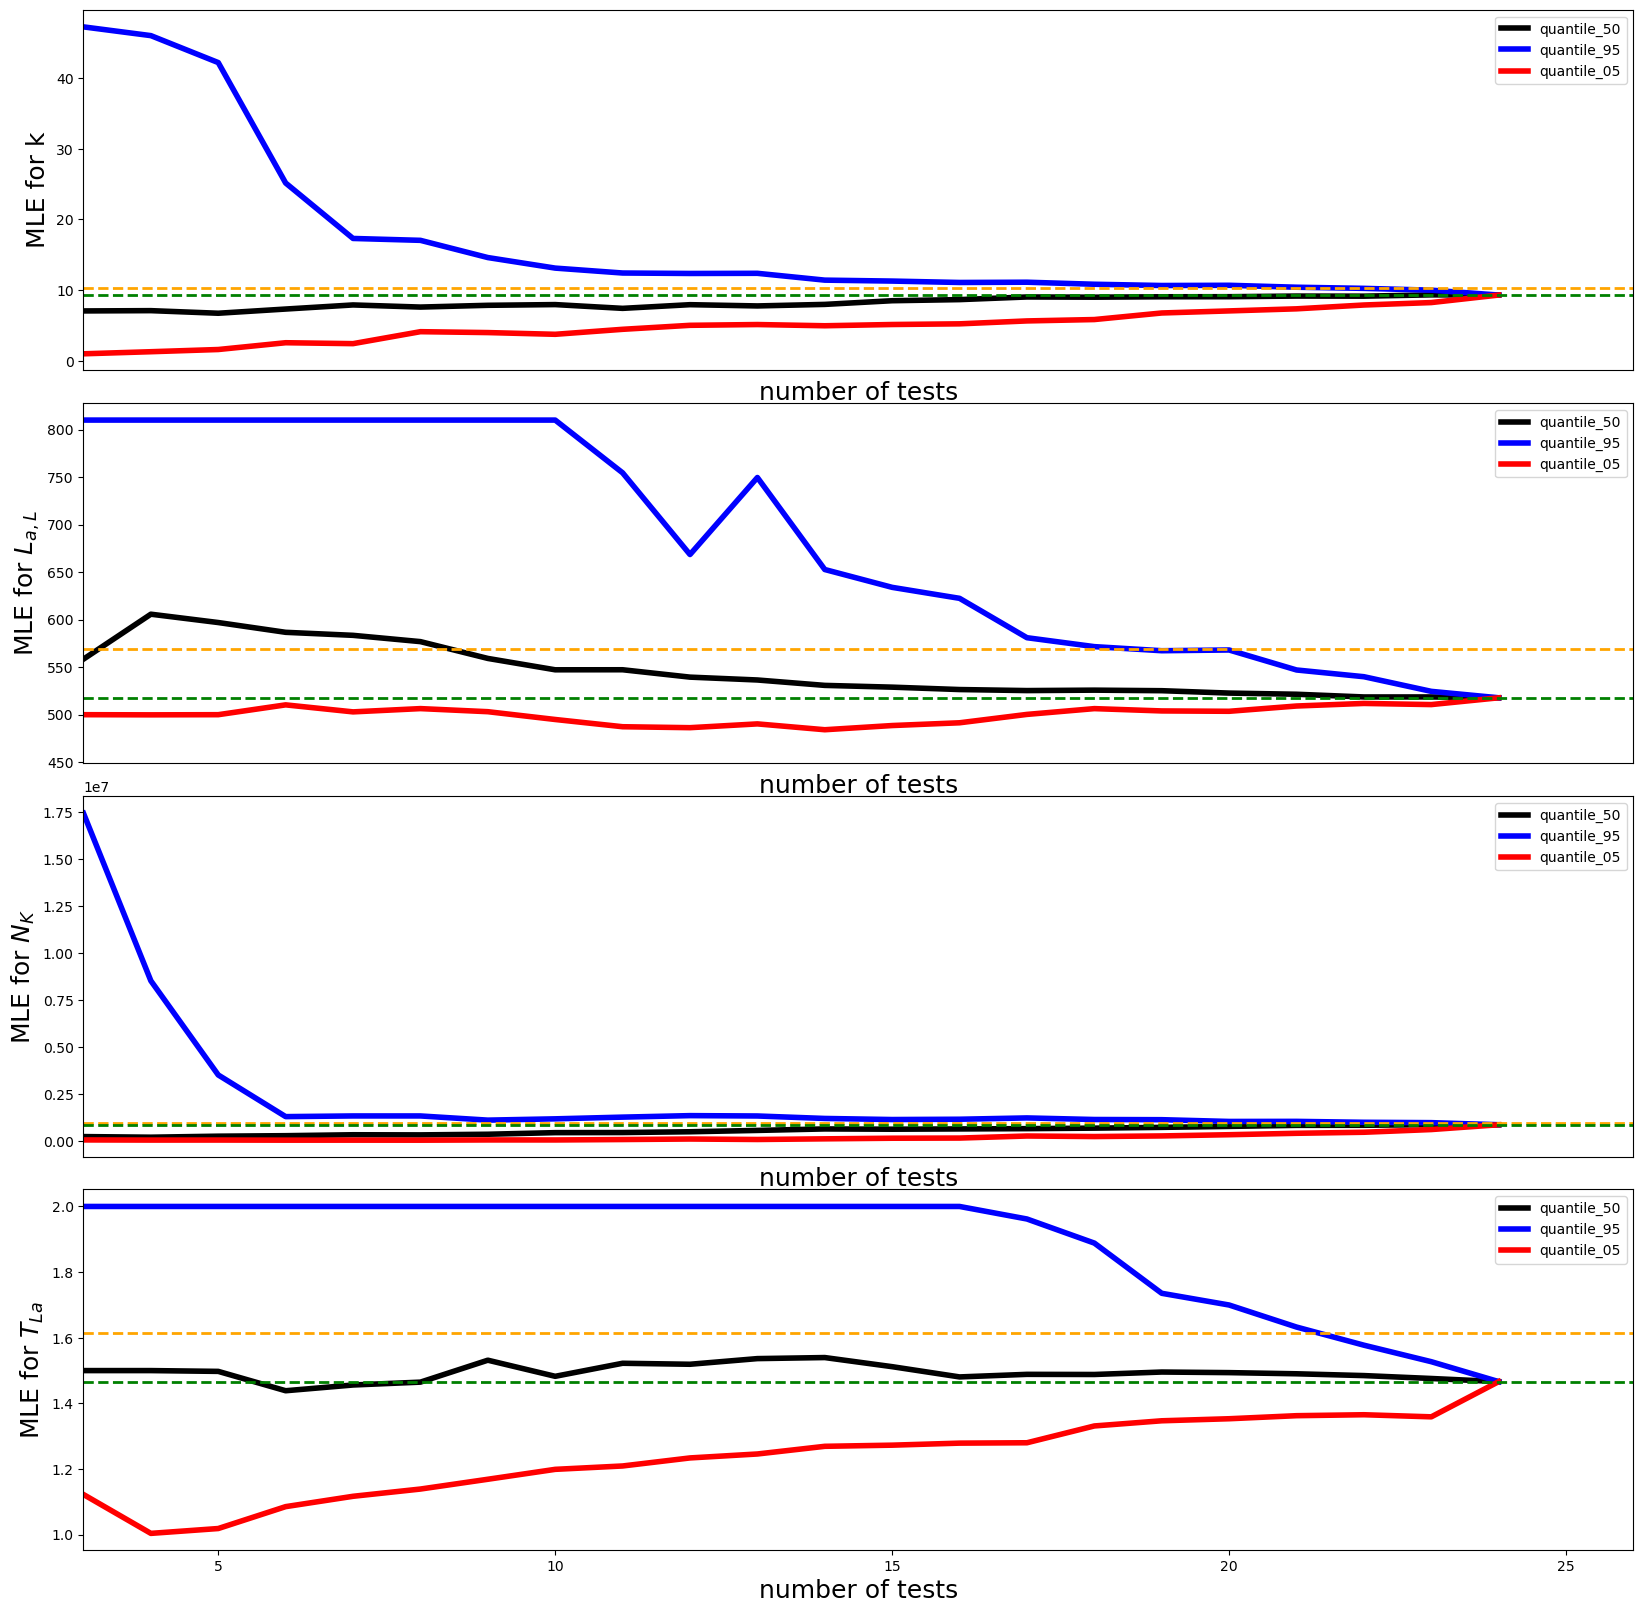

In [10]:
#plot the quantiles 
maxi = len(quantile50['k'])
tolerance = 0.10
plot_functions_T.plot_quantile(quantile50,quantile95,quantile05,0,maxi,tolerance)

In [11]:
length_of_error1 = 18
length_of_error2 = 30
er1,er2 = help_functions.exp_error(length_of_exp_all,length_of_error1,length_of_error2,num,s3,)

19.56418960604644
19.62288546652251
20.113838009949518
19.56418960604644
19.62288546652251
20.113838009949518
19.56418960604644
19.62288546652251
20.113838009949518
19.56418960604644
19.62288546652251
20.113838009949518


In [12]:
'''
err50 : is the error of the median for each parameter of all the samples
err05 : is the error of the 5% lowest values for each parameter of all the samples
err95 : is the error of the 5% highest values for each parameter of all the samples
''' 
err1_50 = [0 for i in range(length_of_error1)]
for i in range(length_of_error1):
    err1_50[i] = np.quantile(er1[i],0.5,axis=0)
    #q_one_t_s = np.append(q_one_t_s,np.quantile(s2[i][3],0.5,axis=0))

err1_95 = [0 for i in range(length_of_error1)]
for i in range(length_of_error1):
    err1_95[i] = np.quantile(er1[i],0.95,axis=0)
    
err1_05 = [0 for i in range(length_of_error1)]
for i in range(length_of_error1):
    err1_05[i] = np.quantile(er1[i],0.05,axis=0)
    
    
    
err2_50 = [0 for i in range(length_of_error2)]
for i in range(length_of_error2):
    err2_50[i] = np.quantile(er2[i],0.5,axis=0)
    #q_one_t_s = np.append(q_one_t_s,np.quantile(s2[i][3],0.5,axis=0))

err2_95 = [0 for i in range(length_of_error2)]
for i in range(length_of_error2):
    err2_95[i] = np.quantile(er2[i],0.95,axis=0)
    
err2_05 = [0 for i in range(length_of_error2)]
for i in range(length_of_error2):
    err2_05[i] = np.quantile(er2[i],0.05,axis=0)
    
print(err2_50)
print(err2_95)
print(err2_05)

[array([0.54317848, 0.09231117, 0.82128886, 0.19596902]), array([0.40748119, 0.11385938, 0.79084432, 0.11958291]), array([0.27920633, 0.10781816, 0.74266263, 0.07679176]), array([0.22751318, 0.09397833, 0.67335724, 0.05665507]), array([0.19681019, 0.07997127, 0.65614006, 0.05093078]), array([0.16527352, 0.07204823, 0.59969823, 0.04197065]), array([0.16681065, 0.06939853, 0.52666652, 0.03744367]), array([0.16021444, 0.05885279, 0.4966595 , 0.03530492]), array([0.14612977, 0.0487639 , 0.44941639, 0.02871338]), array([0.13114328, 0.04426161, 0.40576372, 0.02738807]), array([0.12596654, 0.04073523, 0.36212786, 0.02363815]), array([0.11463271, 0.03968799, 0.35522092, 0.02196376]), array([0.09898579, 0.03520408, 0.33774359, 0.01916423]), array([0.0915711 , 0.03185382, 0.32760557, 0.01732532]), array([0.0797888 , 0.02889741, 0.30888107, 0.01586671]), array([0.07672559, 0.02686211, 0.29227449, 0.01405897]), array([0.06986472, 0.02555797, 0.27445157, 0.01349423]), array([0.06480711, 0.02501513,

In [13]:
#rearranging the errors to have the error for all the samples in each test for each parameter together

error1_50, error1_05, error1_95,error2_50, error2_05, error2_95 = help_functions.arrange_errors(length_of_error1,length_of_error2,err1_50,err1_95,err1_05,err2_50,err2_95,err2_05)

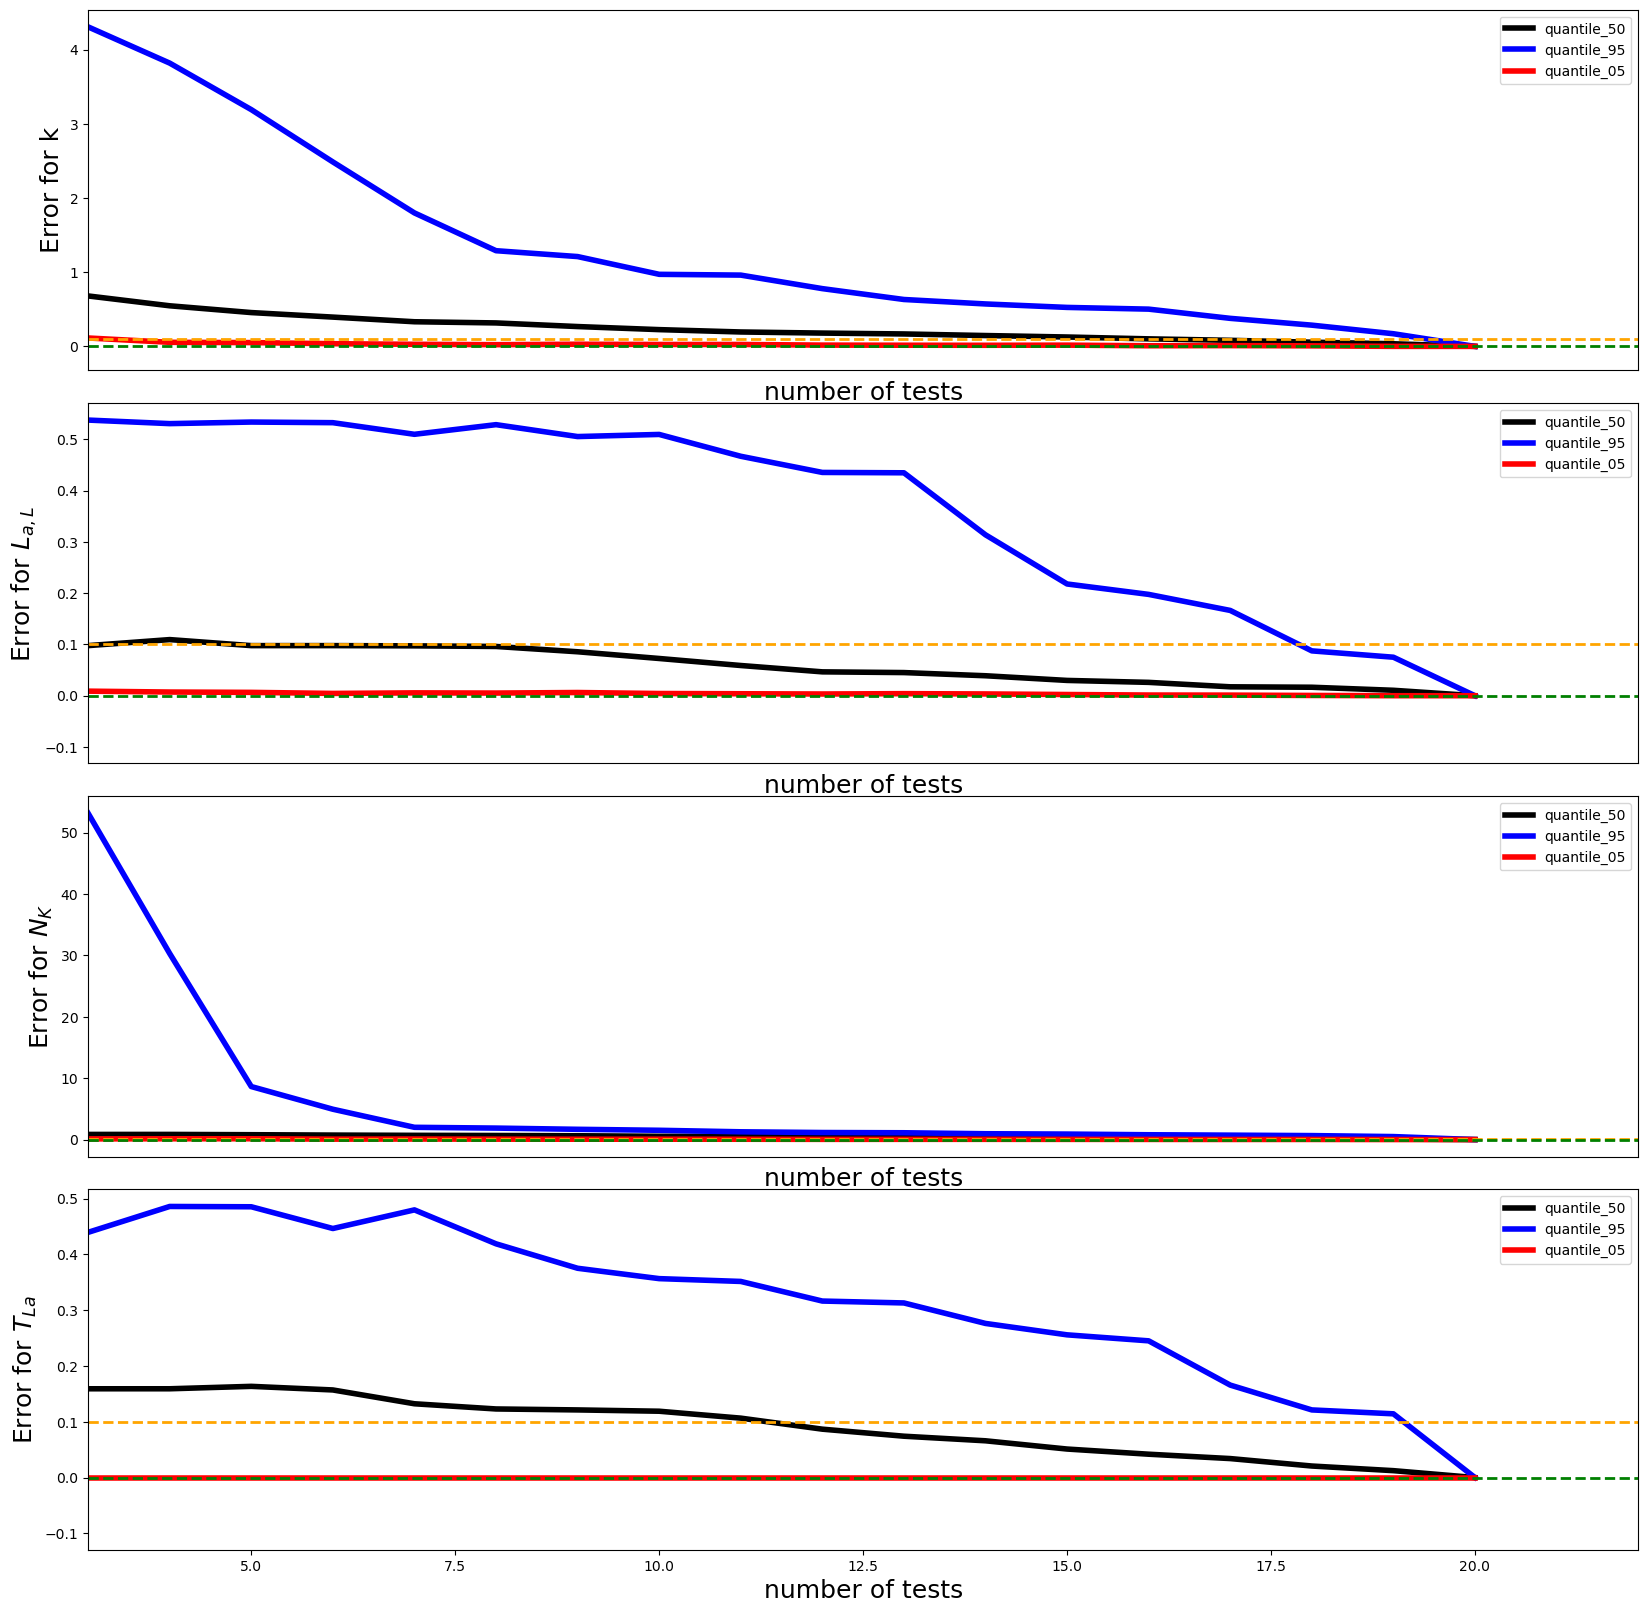

In [14]:
#plot the errors with a tolerence of 10%
maxi = len(error1_50['k'])
tolerance = 0.10
plot_functions_T.plot_quantile(error1_50,error1_95,error1_05,0,maxi,tolerance)

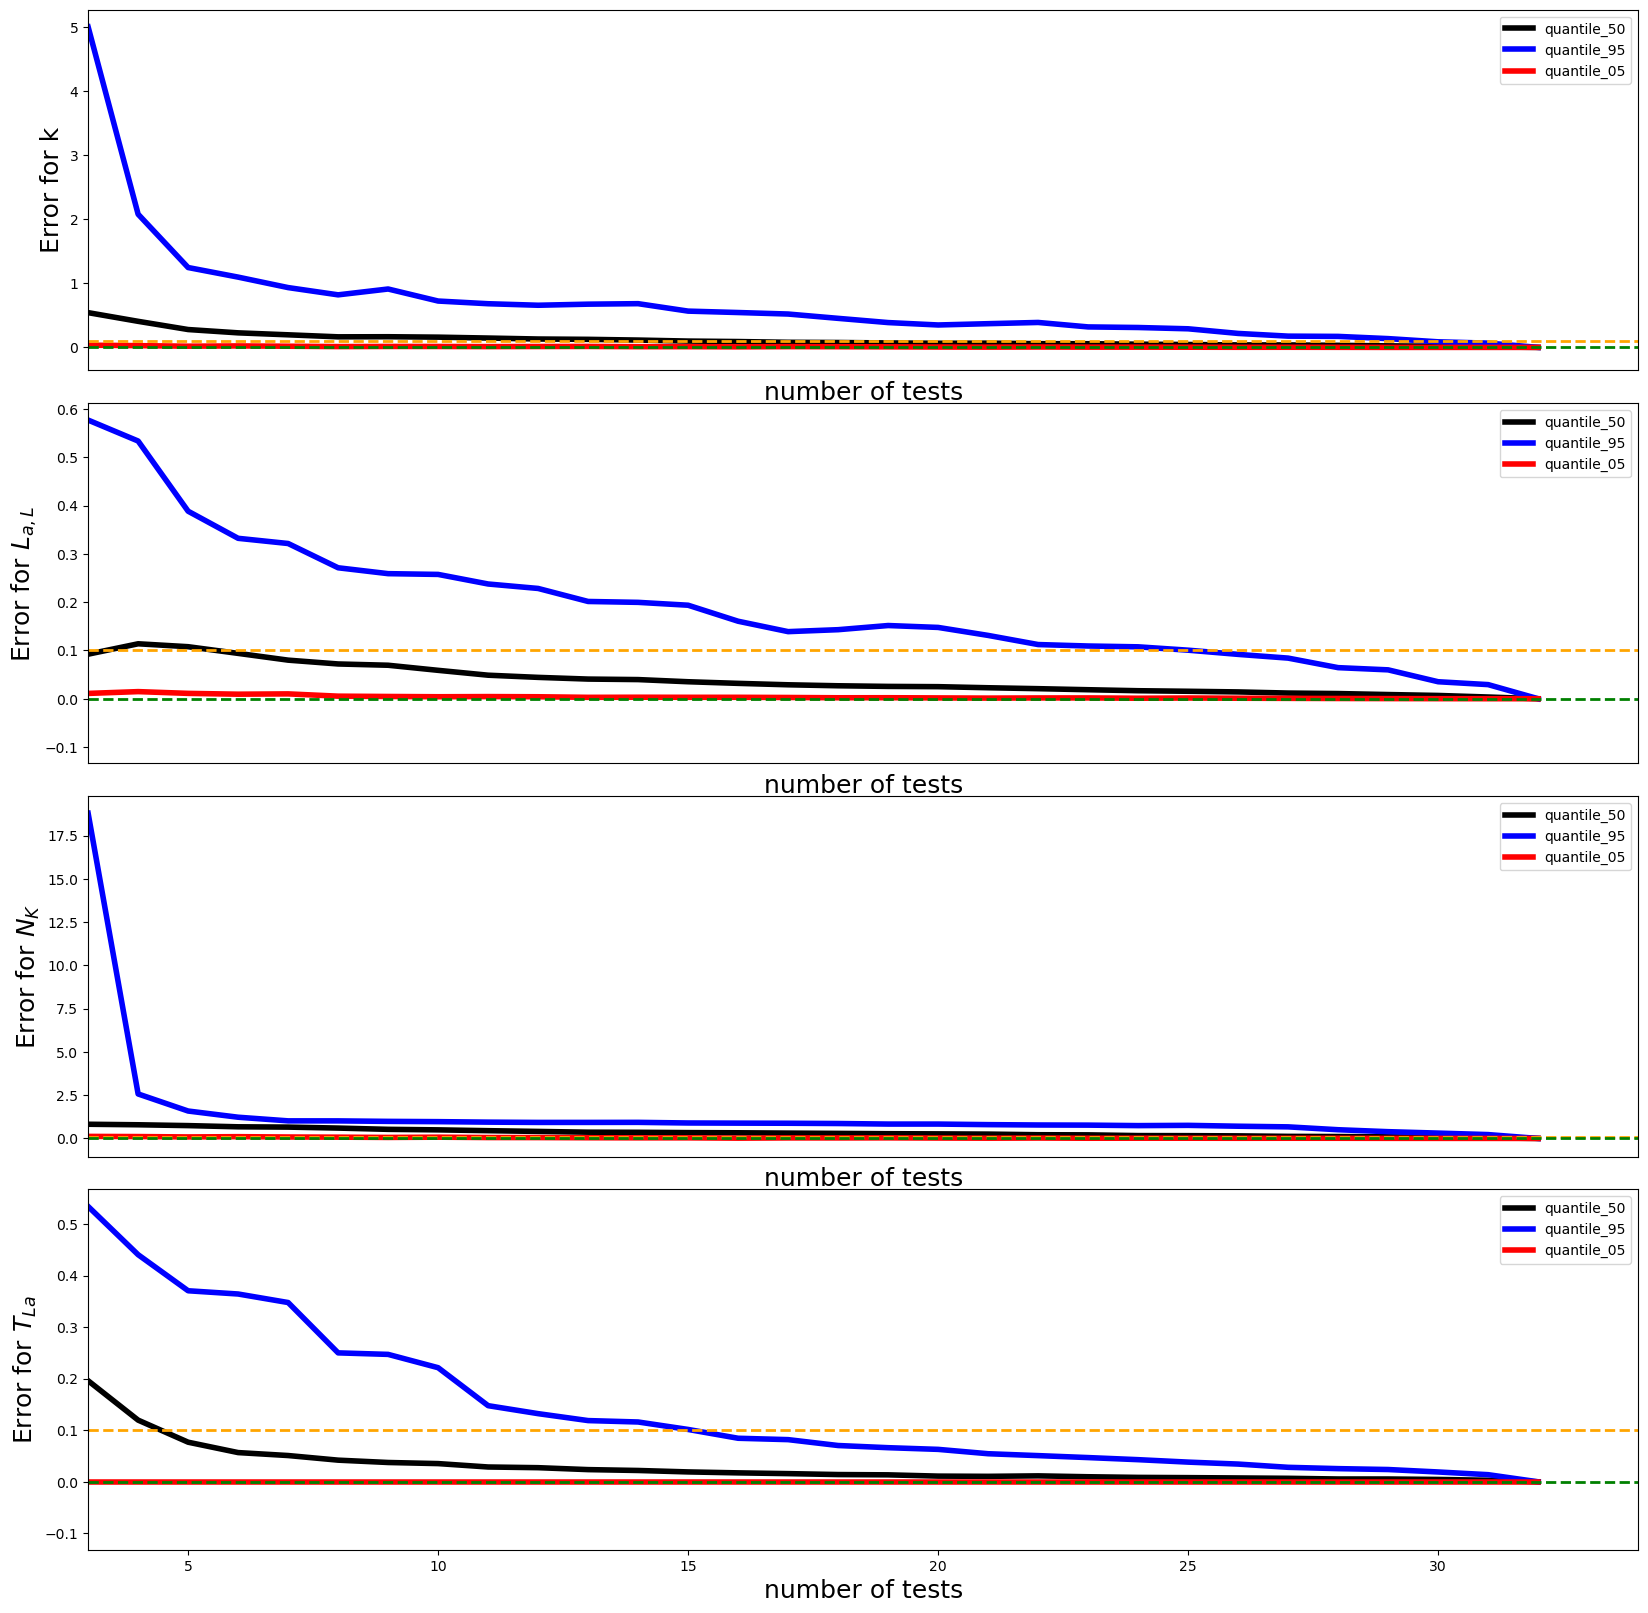

In [15]:
#plot the errors with a tolerence of 10%
maxi = len(error2_50['k'])
tolerance = 0.10
plot_functions_T.plot_quantile(error2_50,error2_95,error2_05,0,maxi,tolerance)

# Trace

In [16]:
#subtracting 3 from the experiment length because the first 3 tests are already included in the first trace run.
##check woehler points dictionary downbelow.
trace_leng = length_of_exp_all[expNum]-3

trace = []

t_enough = {}

mu = {}
mu['k'] = []
mu['s_d'] = []
mu['n_e'] = []
mu['one_t_s'] = []

std = {}
std['k'] = []
std['s_d'] = []
std['n_e'] = []
std['one_t_s'] = []

woehler_points = {}
woehler_points['s_a'] = s_a[0:3]
woehler_points['n'] = n[0:3]
woehler_points['outcome'] = outcome[0:3]


woehler_params_bayes1 = {}
woehler_params_bayes1['k'] = []
woehler_params_bayes1['s_d'] = []
woehler_params_bayes1['n_e'] = []
woehler_params_bayes1['one_t_s'] = []



for i in range(trace_leng):
    new_bays_model = BaysModel()
    woehler_params_bayes, trace, prior_distribution = new_bays_model.calc_model(woehler_points,num_samples = 100)

    woehler_points['s_a'] = np.append(woehler_points['s_a'],s_a[i+3])
    woehler_points['n'] = np.append(woehler_points['n'],n[i+3])
    woehler_points['outcome'] = np.append(woehler_points['outcome'],outcome[i+3])
    
    mu['k'] = np.append(mu['k'],statistics.mean(trace['k']))
    std['k'] = np.append(std['k'],statistics.stdev(trace['k']))
    
    mu['s_d'] = np.append(mu['s_d'],statistics.mean(trace['s_d']))
    std['s_d'] = np.append(std['s_d'],statistics.stdev(trace['s_d']))
    
    mu['n_e'] = np.append(mu['n_e'],statistics.mean(trace['n_e']))
    std['n_e'] = np.append(std['n_e'],statistics.stdev(trace['n_e']))
    
    mu['one_t_s'] = np.append(mu['one_t_s'],statistics.mean(trace['one_t_s']))
    std['one_t_s'] = np.append(std['one_t_s'],statistics.stdev(trace['one_t_s']))
    
    woehler_params_bayes1['k'] = np.append(woehler_params_bayes1['k'],woehler_params_bayes['k'])
    woehler_params_bayes1['s_d'] = np.append(woehler_params_bayes1['s_d'],woehler_params_bayes['s_d'])
    woehler_params_bayes1['n_e'] = np.append(woehler_params_bayes1['n_e'],woehler_params_bayes['n_e'])
    woehler_params_bayes1['one_t_s'] = np.append(woehler_params_bayes1['one_t_s'],woehler_params_bayes['one_t_s'])


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 31 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 36 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 34 seconds.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 27 seconds.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 25 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 23 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.9239894029430666, but should be close to 0.99. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 19 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 19 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.9595426190298768, but should be close to 0.99. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9597813055007448, but should be close to 0.99. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 20 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.9701356880592487, but should be close to 0.99. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 20 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 21 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 20 seconds.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 20 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 20 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 20 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 18 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_e, k, s_d, one_t_s]


Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 15 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


In [17]:
# first likelihood with Uniform prior which comes after at least 2 failures and 1 runout
mu1 =[]
std1 =[]
mu2 =[]
std2 =[]
mu3 =[]
std3 =[]
mu4 =[]
std4 =[]

#assuming the 2 failures and the 1 runout are the first 3 samples
for index in range(experiments[expNum]-1):
    mu1
    #mean and std of likelihood (k)
    mu1 = np.append(mu1,mu['k'][index])
    std1 = np.append(std1,std['k'][index])

    #mean and std of likelihood (s_d)
    mu2 = np.append(mu2,mu['s_d'][index])
    std2 = np.append(std2,std['s_d'][index])

    #mean and std of likelihood (n_e)
    mu3 = np.append(mu3,mu['n_e'][index])
    std3 = np.append(std3,std['n_e'][index])

    #mean and std of likelihood (one_t_s)
    mu4 = np.append(mu4,mu['one_t_s'][index])
    std4 = np.append(std4,std['one_t_s'][index])

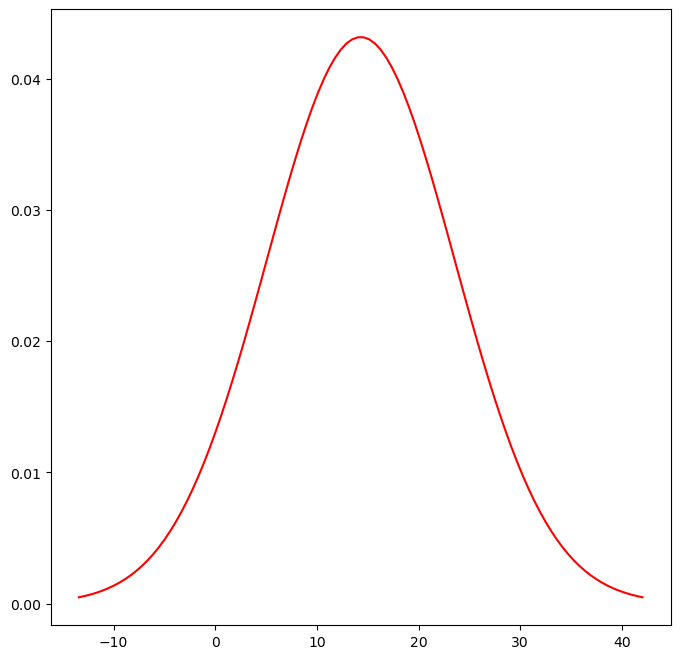

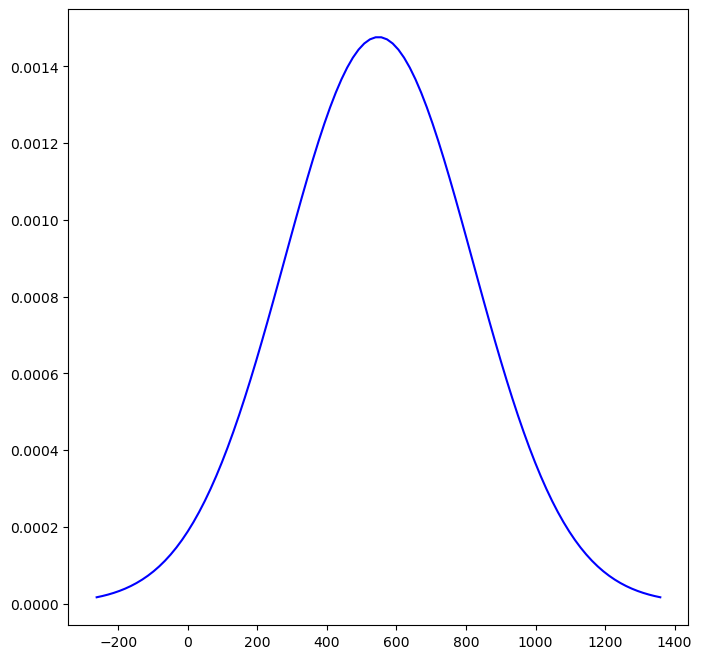

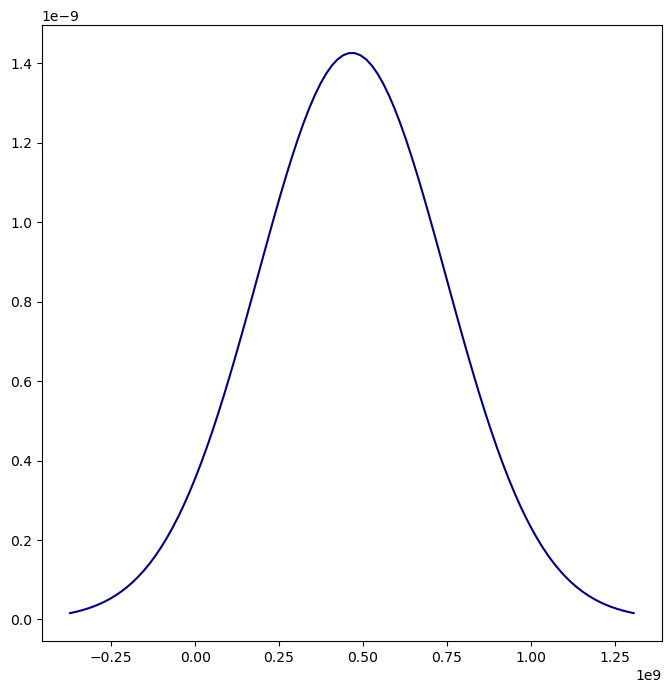

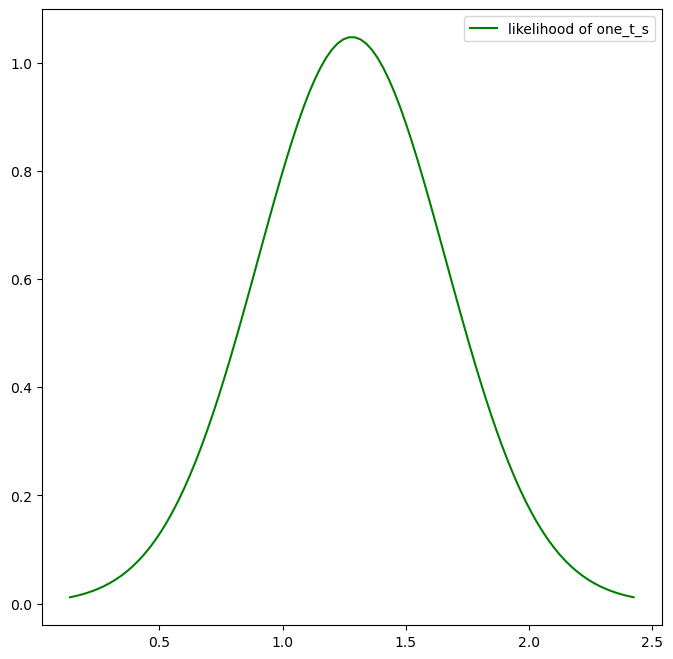

In [18]:
fig,ax = plt.subplots(figsize=(8,8))
x1 = np.linspace(mu1[0] - std1[0] * 3, mu1[0] + std1[0] * 3, 100)
ax.plot(x1, stats.norm.pdf(x1,mu1[0],std1[0]),color= 'red' , label = 'likelihood of k', linestyle = 'solid')

fig,ax = plt.subplots(figsize=(8,8))
x2 = np.linspace(mu2[0] - std2[0] * 3, mu2[0] + std2[0] * 3, 100)
ax.plot(x2, stats.norm.pdf(x2,mu2[0],std2[0]),color= 'blue' , label = 'likelihood of s_d', linestyle = 'solid')

fig,ax = plt.subplots(figsize=(8,8))
x3 = np.linspace(mu3[0] - std3[0] * 3, mu3[0] + std3[0] * 3, 100)
ax.plot(x3, stats.norm.pdf(x3,mu3[0],std3[0]),color= 'navy' , label = 'likelihood of n_e', linestyle = 'solid')

fig,ax = plt.subplots(figsize=(8,8))
x4 = np.linspace(mu4[0] - std4[0] * 3, mu4[0] + std4[0] * 3, 100)
ax.plot(x4, stats.norm.pdf(x4,mu4[0],std4[0]),color= 'green' , label = 'likelihood of one_t_s', linestyle = 'solid')

plt.legend()


In [19]:
#minimal sufficient statistic T for the first likelihood
num_samples = 100
sigma1_Ts = []
sigma2_Ts = []
sigma3_Ts = []
sigma4_Ts = []

#using the sample std from the std python command
for index in range(experiments[expNum]-1):
    sigma1_Ts = np.append(sigma1_Ts,std1[index]/num_samples)
    sigma2_Ts = np.append(sigma2_Ts,std2[index]/num_samples)
    sigma3_Ts = np.append(sigma3_Ts,std3[index]/num_samples)
    sigma4_Ts = np.append(sigma4_Ts,std4[index]/num_samples)

In [20]:
prior_checks_mean1 = []
prior_checks_std1  = []
prior_checks_mean2 = []
prior_checks_std2  = []
prior_checks_mean3 = []
prior_checks_std3  = []
prior_checks_mean4 = []
prior_checks_std4  = []



for index in range(experiments[expNum]-1):
    with pm.Model() as model1:        
        prior_pd1 = pm.Normal('prior_pd_k', mu=prior_from_ki[expNum]['k'], sd=sigma1_Ts[index]+prior_from_ki[expNum]['k_std'])# using Ts of k
        prior_pd2 = pm.Normal('prior_pd_s_d', mu=prior_from_ki[expNum]['s_d'], sd=sigma2_Ts[index]+prior_from_ki[expNum]['s_d_std'])# using Ts s_d
        prior_pd3 = pm.Normal('prior_pd_n_e', mu=prior_from_ki[expNum]['n_e'], sd=sigma3_Ts[index]+prior_from_ki[expNum]['n_e_std'])# using Ts n_e
        prior_pd4 = pm.Normal('prior_pd_one_t_s', mu=prior_from_ki[expNum]['one_t_s'], sd=sigma4_Ts[index]+prior_from_ki[expNum]['one_t_s_std'])# using Ts one_t_s

        prior_checks = pm.sample_prior_predictive(samples=100, random_seed=54)
        prior_checks_mean1 = np.append(prior_checks_mean1,statistics.mean(prior_checks['prior_pd_k']))   #mean of the prior predictive distribution
        prior_checks_std1 = np.append(prior_checks_std1,statistics.stdev(prior_checks['prior_pd_k']))   #standard deviation of the prior predictive distribution    

        prior_checks_mean2 = np.append(prior_checks_mean2,statistics.mean(prior_checks['prior_pd_s_d']))   #mean of the prior predictive distribution
        prior_checks_std2 = np.append(prior_checks_std2,statistics.stdev(prior_checks['prior_pd_s_d']))   #standard deviation of the prior predictive distribution 

        prior_checks_mean3 = np.append(prior_checks_mean3,statistics.mean(prior_checks['prior_pd_n_e']))   #mean of the prior predictive distribution
        prior_checks_std3 = np.append(prior_checks_std3,statistics.stdev(prior_checks['prior_pd_n_e']))   #standard deviation of the prior predictive distribution 

        prior_checks_mean4 = np.append(prior_checks_mean4,statistics.mean(prior_checks['prior_pd_one_t_s']))   #mean of the prior predictive distribution
        prior_checks_std4 = np.append(prior_checks_std4,statistics.stdev(prior_checks['prior_pd_one_t_s']))   #standard deviation of the prior predictive distribution 




### use the mixture of priors to fix the prior data conflict

alpha = 1 - confidence
print('alpha =',alpha)

MLE1 = [0 for i in range(8)]
MLE2 = [0 for i in range(8)]
MLE3 = [0 for i in range(8)]
MLE4 = [0 for i in range(8)]

for i in range(8):
    
    MLE1[i] = woehler_params_original[i]['k']
    MLE2[i] = woehler_params_original[i]['s_d']
    MLE3[i] = woehler_params_original[i]['n_e']
    MLE4[i] = woehler_params_original[i]['one_t_s']


alpha = 0.09999999999999998


In [21]:
#finding the MLE of the test in which the prior data conflict is being tested

curve_s = WoehlerCurve2(S_a[expNum][0:conflict_test], N[expNum][0:conflict_test], Outcome[expNum][0:conflict_test])
s = new_data_manager.transform_woehler_params(curve_s.Mali_4p_result)
MLE_k = s['k']
MLE_s_d = s['s_d']
MLE_n_e = s['n_e']
MLE_one_t_s = s['one_t_s']

self.fatg_lim 600.0
self.dict_bound {'SD_50': (300.0, 900.0), '1/TS': (0.5, 2), 'k_1': (0.2442850300107564, 4.07141716684594), 'ND_50': (21802.854681641347, 10539900.0)}
trying mystic


psi = 0
P_value = 0.03497649097864604

psi = 0.02
P_value = 0.050214045802179655

psi = 0.04
P_value = 0.06759572178038806

psi = 0.06
P_value = 0.08661274488844167

psi = 0.06999999999999999
P_value = 0.09658239404588925

psi = 0.07999999999999999
P_value = 0.10678506159338227

(6.1500926226390185, 21.28019784192117)


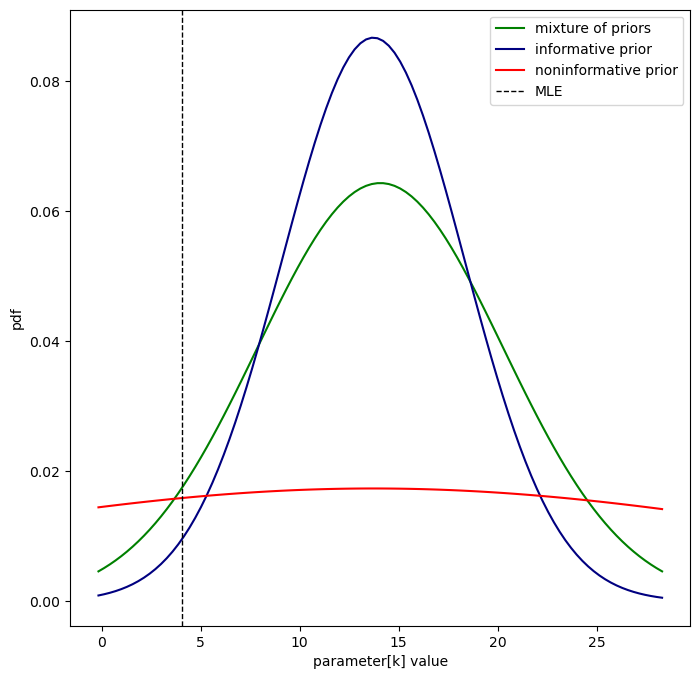

In [22]:
#for k prior

mean1 = prior_checks_mean1[conflict_test]
info_ppd_std1 = prior_checks_std1[conflict_test]
x_axis = np.linspace(mean1 - info_ppd_std1 * 3, mean1 + info_ppd_std1 * 3, 100)

cdf_og = stats.norm(loc= mean1, scale=info_ppd_std1).cdf(MLE_k)
prior_from_ki_k     = prior_from_ki[expNum]['k']
prior_from_ki_k_std = prior_from_ki[expNum]['k_std']
non_inf_k = non_inf['k']
non_inf_k_std = non_inf['k_std']
informative_prior    = [0 for i in range(experiments[expNum])]
noninformative_prior = [0 for i in range(experiments[expNum])]
mixture_prior = [0 for i in range(experiments[expNum])]
hdi_data_k = [0 for i in range(experiments[expNum])]

noninfo_ppd_std1 = prior_from_ki[expNum]['k_std']*scale + sigma1_Ts[index]
x = np.linspace(mean1 - info_ppd_std1 * 3, mean1 + info_ppd_std1 * 3, 100)
informative_prior, noninformative_prior, mixture_prior, x, sigma_Ts, num_try = plot_functions_T.prior_data_conflict_plot(mean1,
                                                                                                 info_ppd_std1,
                                                                                                 noninfo_ppd_std1,
                                                                                                 sigma1_Ts[conflict_test],MLE_k,
                                                                                                 confidence,cdf_og,x,
                                                                                                 prior_from_ki_k,prior_from_ki_k_std,
                                                                                                 non_inf_k,non_inf_k_std,conflict_test)
fig,ax = plt.subplots(figsize=(8,8))
if num_try == 0:
    ax.plot(x, informative_prior,color= 'navy' , label = 'informative prior', linestyle = 'solid')
    ax.plot(x, noninformative_prior,color= 'red' , label = 'noninformative prior', linestyle = 'solid')
    ax.set_xlabel('parameter[k] value', fontsize = 10)
    ax.set_ylabel('pdf', fontsize = 10)
    
    hdi_data_k[conflict_test] = stats.norm.interval(confidence, loc=prior_from_ki[expNum]['k'], scale=prior_from_ki[expNum]['k_std']+sigma_Ts)

if num_try > 0  :
    ax.plot(x, mixture_prior,color= 'green' , label = 'mixture of priors', linestyle = 'solid')
    ax.plot(x, informative_prior,color= 'navy' , label = 'informative prior', linestyle = 'solid')
    ax.plot(x, noninformative_prior,color= 'red' , label = 'noninformative prior', linestyle = 'solid')
    ax.set_xlabel('parameter[k] value', fontsize = 10)
    ax.set_ylabel('pdf', fontsize = 10)
    hdi_data_k[conflict_test] = stats.norm.interval(confidence, loc=prior_from_ki[expNum]['k'], scale=prior_from_ki[expNum]['k_std']+sigma_Ts)
    
print(hdi_data_k[conflict_test])
ax.axvline(MLE_k, color='k',label = 'MLE', linestyle='dashed', linewidth=1)
plt.legend()

psi = 0
P_value = 0.26988251665895746

(501.52710750025165, 872.8610018645757)


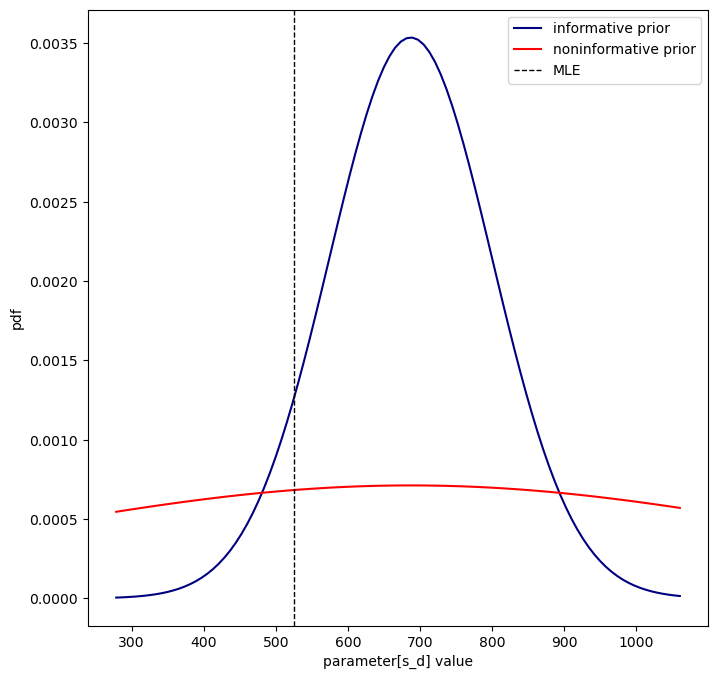

In [23]:
#for s_d prior

mean2 = prior_checks_mean2[conflict_test]
info_ppd_std2 = prior_checks_std2[conflict_test]
x_axis = np.linspace(mean2 - info_ppd_std2 * 3, mean2 + info_ppd_std2 * 3, 100)

cdf_og = stats.norm(loc= mean2, scale=info_ppd_std2).cdf(MLE_s_d)
prior_from_ki_s_d     = prior_from_ki[expNum]['s_d']
prior_from_ki_s_d_std = prior_from_ki[expNum]['s_d_std']
non_inf_s_d = non_inf['s_d']
non_inf_s_d_std = non_inf['s_d_std']
informative_prior    = [0 for i in range(experiments[expNum])]
noninformative_prior = [0 for i in range(experiments[expNum])]
mixture_prior = [0 for i in range(experiments[expNum])]
hdi_data_s_d = [0 for i in range(experiments[expNum])]
x = np.linspace(mean2 - info_ppd_std2 * 3, mean2 + info_ppd_std2 * 3, 100)


noninfo_ppd_std2 = prior_from_ki[expNum]['s_d_std']*scale + sigma2_Ts[conflict_test]
x = np.linspace(mean2 - info_ppd_std2 * 3, mean2 + info_ppd_std2 * 3, 100)
informative_prior, noninformative_prior, mixture_prior, x, sigma_Ts, num_try = plot_functions_T.prior_data_conflict_plot(mean2,
                                                                                                 info_ppd_std2,
                                                                                                 noninfo_ppd_std2,
                                                                                                 sigma2_Ts[conflict_test],MLE_s_d,
                                                                                                 confidence,cdf_og,x,
                                                                                                 prior_from_ki_s_d,prior_from_ki_s_d_std,
                                                                                                 non_inf_s_d,non_inf_s_d_std,conflict_test)
fig,ax = plt.subplots(figsize=(8,8))

if num_try == 0:
    ax.plot(x, informative_prior,color= 'navy' , label = 'informative prior', linestyle = 'solid')
    ax.plot(x, noninformative_prior,color= 'red' , label = 'noninformative prior', linestyle = 'solid')
    ax.set_xlabel('parameter[s_d] value', fontsize = 10)
    ax.set_ylabel('pdf', fontsize = 10)
    hdi_data_s_d[conflict_test] = stats.norm.interval(confidence, loc=prior_from_ki[expNum]['s_d'], scale=prior_from_ki[expNum]['s_d_std']+sigma_Ts)

if num_try > 0  :
    ax.plot(x, mixture_prior,color= 'green' , label = 'mixture of priors', linestyle = 'solid')
    ax.plot(x, informative_prior,color= 'navy' , label = 'informative prior', linestyle = 'solid')
    ax.plot(x, noninformative_prior,color= 'red' , label = 'noninformative prior', linestyle = 'solid')
    ax.set_xlabel('parameter[s_d] value', fontsize = 10)
    ax.set_ylabel('pdf', fontsize = 10)
    hdi_data_s_d[conflict_test] = stats.norm.interval(confidence, loc=prior_from_ki[expNum]['s_d'], scale=prior_from_ki[expNum]['s_d_std']+sigma_Ts)    
    
print(hdi_data_s_d[conflict_test])
ax.axvline(MLE_s_d, color='k',label = 'MLE', linestyle='dashed', linewidth=1)
plt.legend()



psi = 0
P_value = 0.7688655291330405

(-5972251.156750961, 9176343.475417625)
(-5972251.156750961, 9176343.475417625)


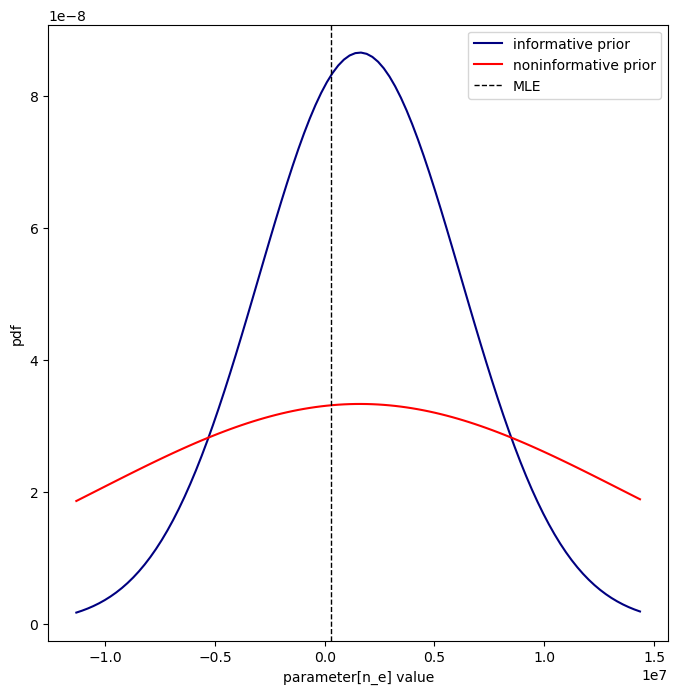

In [24]:
#for n_e prior

mean3 = prior_checks_mean3[conflict_test]
info_ppd_std3 = prior_checks_std3[conflict_test]
x_axis = np.linspace(mean3 - info_ppd_std3 * 3, mean3 + info_ppd_std3 * 3, 100)

cdf_og = stats.norm(loc= mean3, scale=info_ppd_std3).cdf(MLE_n_e)
prior_from_ki_n_e     = prior_from_ki[expNum]['n_e']
prior_from_ki_n_e_std = prior_from_ki[expNum]['n_e_std']
non_inf_n_e = non_inf['n_e']
non_inf_n_e_std = non_inf['n_e_std']
informative_prior    = [0 for i in range(experiments[expNum])]
noninformative_prior = [0 for i in range(experiments[expNum])]
mixture_prior = [0 for i in range(experiments[expNum])]
hdi_data_n_e = [0 for i in range(experiments[expNum])]

noninfo_ppd_std3 = prior_from_ki[expNum]['n_e_std']*scale + sigma3_Ts[conflict_test]
x = np.linspace(mean3 - info_ppd_std3 * 3, mean3 + info_ppd_std3 * 3, 100)
informative_prior, noninformative_prior, mixture_prior, x, sigma_Ts, num_try = plot_functions_T.prior_data_conflict_plot(mean3,
                                                                                                 info_ppd_std3,
                                                                                                 noninfo_ppd_std3,
                                                                                                 sigma3_Ts[conflict_test],MLE_n_e,
                                                                                                 confidence,cdf_og,x,
                                                                                                 prior_from_ki_n_e,prior_from_ki_n_e_std,
                                                                                                 non_inf_n_e,non_inf_n_e_std,conflict_test)
fig,ax = plt.subplots(figsize=(8,8))

if num_try == 0:
    ax.plot(x, informative_prior,color= 'navy' , label = 'informative prior', linestyle = 'solid')
    ax.plot(x, noninformative_prior,color= 'red' , label = 'noninformative prior', linestyle = 'solid')
    ax.set_xlabel('parameter[n_e] value', fontsize = 10)
    ax.set_ylabel('pdf', fontsize = 10)
    hdi_data_n_e[conflict_test] = stats.norm.interval(confidence, loc=prior_from_ki[expNum]['n_e'], scale=prior_from_ki[expNum]['n_e_std']+sigma_Ts)
    
if num_try > 0  :
    ax.plot(x, mixture_prior,color= 'green' , label = 'mixture of priors', linestyle = 'solid')
    ax.plot(x, informative_prior,color= 'navy' , label = 'informative prior', linestyle = 'solid')
    ax.plot(x, noninformative_prior,color= 'red' , label = 'noninformative prior', linestyle = 'solid')
    ax.set_xlabel('parameter[n_e] value', fontsize = 10)
    ax.set_ylabel('pdf', fontsize = 10)
    hdi_data_n_e[conflict_test] = stats.norm.interval(confidence, loc=prior_from_ki[expNum]['n_e'], scale=prior_from_ki[expNum]['n_e_std']+sigma_Ts)
    
print(hdi_data_n_e[conflict_test])
ax.axvline(MLE_n_e, color='k',label = 'MLE', linestyle='dashed', linewidth=1)
plt.legend()
#plt.ylim(0, 0.005)

print(hdi_data_n_e[conflict_test])

psi = 0
P_value = 0.0009465358812137392

psi = 0.05
P_value = 0.006534784223227064

psi = 0.1
P_value = 0.0208879735792713

psi = 0.12000000000000001
P_value = 0.029351694046006127

psi = 0.14
P_value = 0.039248178095703246

psi = 0.16
P_value = 0.050420789981595826

psi = 0.18
P_value = 0.06268869202542549

psi = 0.19999999999999998
P_value = 0.07586398377028525

psi = 0.21
P_value = 0.08273427827137203

psi = 0.22
P_value = 0.08976361895524398

psi = 0.23
P_value = 0.09693111267395027

psi = 0.24000000000000002
P_value = 0.10421691654288456

(1.0383150534187868, 1.7204521761859342)


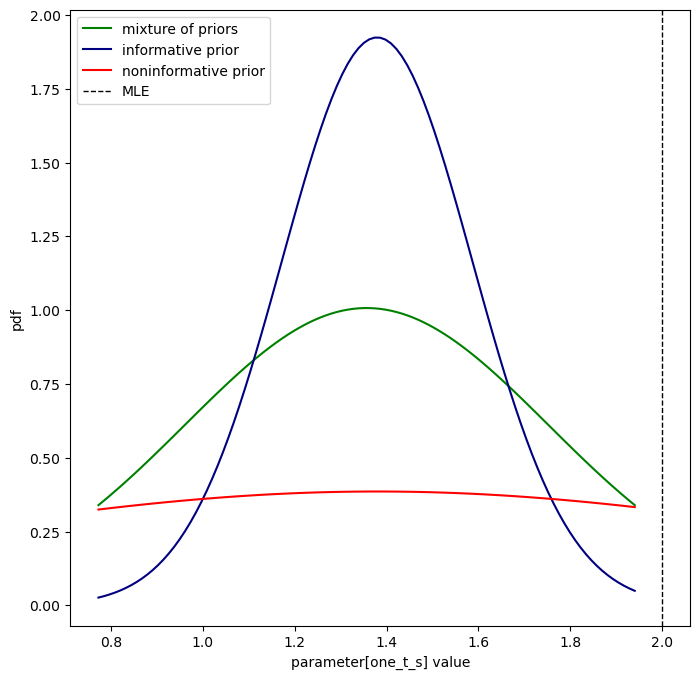

In [25]:
#for one_t_s prior

mean4 = prior_checks_mean4[conflict_test]
info_ppd_std4= prior_checks_std4[conflict_test]
x_axis = np.linspace(mean4 - info_ppd_std4* 3, mean4 + info_ppd_std4 * 3, 100)

cdf_og = stats.norm(loc= mean4, scale=info_ppd_std4).cdf(MLE_one_t_s)
prior_from_ki_one_t_s     = prior_from_ki[expNum]['one_t_s']
prior_from_ki_one_t_s_std = prior_from_ki[expNum]['one_t_s_std']
non_inf_one_t_s = non_inf['one_t_s']
non_inf_one_t_s_std = non_inf['one_t_s_std']
informative_prior    = [0 for i in range(experiments[expNum])]
noninformative_prior = [0 for i in range(experiments[expNum])]
mixture_prior = [0 for i in range(experiments[expNum])]
hdi_data_one_t_s = [0 for i in range(experiments[expNum])]


noninfo_ppd_std4 = prior_from_ki[expNum]['one_t_s_std']*scale + sigma4_Ts[conflict_test]
x = np.linspace(mean4 - info_ppd_std4 * 3, mean4 + info_ppd_std4 * 3, 100)
informative_prior, noninformative_prior, mixture_prior, x, sigma_Ts, num_try = plot_functions_T.prior_data_conflict_plot(mean4,
                                                                                                 info_ppd_std4,
                                                                                                 noninfo_ppd_std4,
                                                                                                 sigma4_Ts[conflict_test],MLE_one_t_s,
                                                                                                 confidence,cdf_og,x,
                                                                                                 prior_from_ki_one_t_s,prior_from_ki_one_t_s_std,
                                                                                                 non_inf_one_t_s,non_inf_one_t_s_std,conflict_test)
fig,ax = plt.subplots(figsize=(8,8))

if num_try == 0:
    ax.plot(x, informative_prior,color= 'navy' , label = 'informative prior', linestyle = 'solid')
    ax.plot(x, noninformative_prior,color= 'red' , label = 'noninformative prior', linestyle = 'solid')
    ax.set_xlabel('parameter[one_t_s] value', fontsize = 10)
    ax.set_ylabel('pdf', fontsize = 10)
    hdi_data_one_t_s[conflict_test] = stats.norm.interval(confidence, loc=prior_from_ki[expNum]['one_t_s'], scale=prior_from_ki[expNum]['one_t_s_std']+sigma_Ts)
    
if num_try > 0  :
    ax.plot(x, mixture_prior,color= 'green' , label = 'mixture of priors', linestyle = 'solid')
    ax.plot(x, informative_prior,color= 'navy' , label = 'informative prior', linestyle = 'solid')
    ax.plot(x, noninformative_prior,color= 'red' , label = 'noninformative prior', linestyle = 'solid')
    ax.set_xlabel('parameter[one_t_s] value', fontsize = 10)
    ax.set_ylabel('pdf', fontsize = 10)
    hdi_data_one_t_s[conflict_test] = stats.norm.interval(confidence, loc=prior_from_ki[expNum]['one_t_s'], scale=prior_from_ki[expNum]['one_t_s_std']+sigma_Ts)

print(hdi_data_one_t_s[conflict_test])
ax.axvline(MLE_one_t_s, color='k',label = 'MLE', linestyle='dashed', linewidth=1)
plt.legend()